# Harmonising Near-Coincident CryoSat-2 and ICESat-2 (CRYO2ICE) Winter Snow-Thickness Retrievals in the Ross and Weddell Seas: 2021-2024

A comprehensive analysis of CRYO2ICE (CryoSat-2 and ICESat-2) freeboards (radar or laser) and derived snow thicknesses over Antarctic sea ice, focusing specifically on the Ross and Weddell Seas during austral winter seasons (May-October) of 2021-2024. 

This program computes CRYO2ICE comparable observations at CryoSat-2 locations (used as reference) by a defined search radius using the European Space Agency's (ESA's) Baseline-E L1B products for CryoSat-2 and ATL10 from NASA's ICESat-2.

The derived snow thicknesses are compared with auxiliary datasets including passive microwave retrievals (AMSR2). The analysis investigates regional variations in snow-thickness distributions and examines the temporal evolution of snow accumulation patterns across these key Antarctic regions.

## Step 1: Initialisation and Data Processing Framework

In [1]:
# Scientific computation libraries - Import pandas first before other dependencies
import pandas as pd  # Import pandas first

# Then import other scientific packages
import numpy as np
import scipy.stats as stats
from scipy.interpolate import griddata, interp1d
from sklearn.neighbors import KDTree  # Added for efficient nearest-neighbor search

# Geospatial processing
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj, transform
import geopandas as gpd
from shapely.geometry import Point, LineString

# Data handling
import xarray as xr
import h5py
import netCDF4 as nc
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import seaborn as sns  # Added for enhanced statistical visualisations
import cmocean  # Added for oceanography-specific colormaps

# System utilities
import os
import sys
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner notebook output

# Antarctic-specific constants and parameters
# Will be defined in subsequent cells

# Visualization settings optimized for Antarctic sea ice analysis
plt.rcParams['font.family'] = 'DejaVu Sans'  # Changed from Arial
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['figure.figsize'] = (10, 8)  # Default figure size
plt.rcParams['savefig.dpi'] = 300  # Publication quality figures
plt.rcParams['figure.facecolor'] = '#F8F8F8'  # Light gray background
plt.rcParams['axes.facecolor'] = '#FFFFFF'  # White plot area

# Set default colormap to perceptually uniform options
plt.rcParams['image.cmap'] = 'viridis'  # Good for data visualization

# Pandas display settings
pd.set_option('display.max_columns', 12)
pd.options.mode.chained_assignment = None  # Suppress warnings for cleaner output

print("Libraries imported successfully")

Libraries imported successfully


## Step 2: Check if tracks are in fact CRYO2ICE tracks

In [2]:
# Define base directories
base_dir = r'D:\phd\data\chap2'
years = ['2021', '2022', '2023', '2024']
regions = ['ross', 'weddell']

# Initialise counters for total files
total_is2_files = 0
total_cs2_files = 0

# Print header
print("=" * 80)
print("CRYO2ICE Data Inventory (2021-2024)")
print("=" * 80)


# ICESat-2 ATL10 Version 6 file check
print("\n1. ICESat-2 ATL10 Version 6 Files:")
print("-" * 50)

for region in regions:
    region_total = 0
    print(f"\n{region.upper()} Sea:")
    
    for year in years:
        dir_path = f"{base_dir}/is2_atl10v6_{region}_winter/{year}"
        files = glob.glob(f"{dir_path}/*.h5")
        file_count = len(files)
        region_total += file_count
        total_is2_files += file_count
        print(f"  {year}: {file_count} files")
    
    print(f"  Total {region.upper()} Sea: {region_total} files")

print(f"\nTotal ICESat-2 ATL10 Version 6 files across all regions: {total_is2_files}")


# CryoSat-2 Baseline-E file check
print("\n2. CryoSat-2 Baseline-E Files:")
print("-" * 50)

# Weddell Sea (simpler structure)
weddell_total = 0
print("\nWEDDELL Sea:")
for year in years:
    dir_path = f"{base_dir}/cs2_l2_sar_basel_e_weddell_winter/{year}"
    files = glob.glob(f"{dir_path}/*.nc")
    file_count = len(files)
    weddell_total += file_count
    total_cs2_files += file_count
    print(f"  {year}: {file_count} files")

print(f"  Total WEDDELL Sea: {weddell_total} files")

# Ross Sea (complex structure with EH/WH hemispheres)
ross_total = 0
print("\nROSS Sea:")
hemispheres = ['EH', 'WH']

for hemisphere in hemispheres:
    hemi_total = 0
    hem_label = "Eastern Hemisphere (160E-180E)" if hemisphere == "EH" else "Western Hemisphere (180W-140W)"
    print(f"\n  {hem_label}:")
    
    for year in years:
        dir_path = f"{base_dir}/cs2_l2_sar_basel_e_ross_winter/{hemisphere}/{year}"
        files = glob.glob(f"{dir_path}/*.nc")
        file_count = len(files)
        hemi_total += file_count
        ross_total += file_count
        total_cs2_files += file_count
        print(f"    {year}: {file_count} files")
    
    print(f"    Total {hemisphere}: {hemi_total} files")

print(f"\n  Total ROSS Sea: {ross_total} files")
print(f"\nTotal CryoSat-2 Baseline-E files across all regions: {total_cs2_files}")

# Overall summary
print("\n" + "=" * 80)
print(f"TOTAL CRYO2ICE FILES: {total_is2_files + total_cs2_files}")
print("=" * 80)

CRYO2ICE Data Inventory (2021-2024)

1. ICESat-2 ATL10 Version 6 Files:
--------------------------------------------------

ROSS Sea:
  2021: 972 files
  2022: 987 files
  2023: 928 files
  2024: 725 files
  Total ROSS Sea: 3612 files

WEDDELL Sea:
  2021: 1270 files
  2022: 1319 files
  2023: 1010 files
  2024: 939 files
  Total WEDDELL Sea: 4538 files

Total ICESat-2 ATL10 Version 6 files across all regions: 8150

2. CryoSat-2 Baseline-E Files:
--------------------------------------------------

WEDDELL Sea:
  2021: 1285 files
  2022: 1280 files
  2023: 1403 files
  2024: 1402 files
  Total WEDDELL Sea: 5370 files

ROSS Sea:

  Eastern Hemisphere (160E-180E):
    2021: 364 files
    2022: 360 files
    2023: 367 files
    2024: 365 files
    Total EH: 1456 files

  Western Hemisphere (180W-140W):
    2021: 658 files
    2022: 651 files
    2023: 653 files
    2024: 661 files
    Total WH: 2623 files

  Total ROSS Sea: 4079 files

Total CryoSat-2 Baseline-E files across all regions: 9

### Step 2.1: We first look at the previously-derived .CSV file, narrow the scope to the Weddell Sector, use the time_delta variable to set the limit for extracting the valid CRYO2ICE tracks, and plot the spatial distributions of the radar freeboards from CS2 and total freeboards from IS2 for checking their alignment

In [3]:
# Load the pre-computed CRYO2ICE match dataset
csv_path = os.path.join(base_dir, "output", "cryo2ice_tracks_2021_2024.csv")
cryo2ice_matches = pd.read_csv(csv_path)

# Filter for Weddell Sea region
weddell_matches = cryo2ice_matches[cryo2ice_matches['region'] == 'Weddell Sea']

# Filter for time differences within ±3 hours
weddell_valid_matches = weddell_matches[abs(weddell_matches['time_delta']) <= 3]

# Print summary statistics
print(f"Total CRYO2ICE matches for Weddell Sea: {len(weddell_matches)}")
print(f"Valid matches within ±3 hours: {len(weddell_valid_matches)}")
print(f"Percentage of valid matches: {(len(weddell_valid_matches) / len(weddell_matches) * 100):.2f}%")

Total CRYO2ICE matches for Weddell Sea: 4513
Valid matches within ±3 hours: 210
Percentage of valid matches: 4.65%


In [4]:
# Select first valid match for visualisation
N = 0
example_match = weddell_valid_matches.iloc[N]

# Extract file paths for the selected match
cs2_file = os.path.join(base_dir, 
                     f"cs2_l2_sar_basel_e_weddell_winter/{example_match['year']}/{example_match['cs2_file']}")
is2_file = os.path.join(base_dir, 
                     f"is2_atl10v6_weddell_winter/{example_match['year']}/{example_match['is2_file']}")

print(f"\nAnalysing CRYO2ICE match #{N}:")
print(f"CS2 file: {example_match['cs2_file']}")
print(f"IS2 file: {example_match['is2_file']}")
print(f"Time delta: {example_match['time_delta']:.2f} hours")

# Store paths for use in subsequent cells
files_check_CS2 = [cs2_file]
files_check_IS2 = [is2_file]

# Load CS2 data
ds = nc.Dataset(files_check_CS2[N], 'r')
freeboard_CS2 = ds.variables['radar_freeboard_20_ku'][:]
lat_CS2 = ds.variables['lat_poca_20_ku'][:]
lon_CS2 = ds.variables['lon_poca_20_ku'][:]
ds.close()

print(f"CryoSat-2 data shape: freeboard={freeboard_CS2.shape}, lat={lat_CS2.shape}, lon={lon_CS2.shape}")


# Open IS2 data file
file = h5py.File(files_check_IS2[N], 'r')

# Examine available beams
available_beams = [key for key in file.keys() if key.startswith('gt')]
print(f"\nAvailable beams in IS2 file: {available_beams}")

# Initialize lists to store beam data
lon_IS2_beams = []
lat_IS2_beams = []
freeboard_IS2_beams = []

# Process each beam to extract freeboard data
for beam in available_beams:
    try:
        # Based on the structure inspection, we load data directly from freeboard_segment
        # Load coordinates
        lon_beam = np.array(file[f'{beam}/freeboard_segment/longitude'])
        lat_beam = np.array(file[f'{beam}/freeboard_segment/latitude'])
        
        # Load freeboard data
        freeboard_beam = np.array(file[f'{beam}/freeboard_segment/beam_fb_height'])
        
        # Filter valid data points
        valid_mask = ~np.isnan(freeboard_beam) & (freeboard_beam > -999)
        
        if np.any(valid_mask):
            # Store valid data for this beam
            lon_IS2_beams.append(lon_beam[valid_mask])
            lat_IS2_beams.append(lat_beam[valid_mask])
            freeboard_IS2_beams.append(freeboard_beam[valid_mask])
            
            print(f"{beam}: Found {sum(valid_mask)} valid points out of {len(freeboard_beam)}")
            print(f"  Mean freeboard: {np.mean(freeboard_beam[valid_mask]):.4f} m")
            print(f"  Range: {np.min(freeboard_beam[valid_mask]):.4f} to {np.max(freeboard_beam[valid_mask]):.4f} m")
        else:
            print(f"{beam}: No valid freeboard data points found")
    
    except Exception as e:
        print(f"{beam}: Error processing - {str(e)}")

# Combine all valid beam data
if len(lon_IS2_beams) > 0:
    lon_IS2 = np.concatenate(lon_IS2_beams)
    lat_IS2 = np.concatenate(lat_IS2_beams)
    freeboard_IS2 = np.concatenate(freeboard_IS2_beams)
    
    print(f"\nCombined ICESat-2 data:")
    print(f"  Total points: {len(lon_IS2)}")
    print(f"  Mean freeboard: {np.mean(freeboard_IS2):.4f} m")
    print(f"  Min freeboard: {np.min(freeboard_IS2):.4f} m")
    print(f"  Max freeboard: {np.max(freeboard_IS2):.4f} m")
else:
    print("\nNo valid ICESat-2 data found in any beam.")
    # Create empty arrays to avoid errors in subsequent code
    lon_IS2 = np.array([])
    lat_IS2 = np.array([])
    freeboard_IS2 = np.array([])

file.close()


Analysing CRYO2ICE match #0:
CS2 file: CS_LTA__SIR_SAR_2__20210501T084902_20210501T084944_E001_segment_641.nc
IS2 file: ATL10-02_20210501061732_05721101_006_01.h5
Time delta: 1.31 hours
CryoSat-2 data shape: freeboard=(911,), lat=(911,), lon=(911,)

Available beams in IS2 file: ['gt1l', 'gt1r', 'gt2r', 'gt3r']
gt1l: Found 46720 valid points out of 46720
  Mean freeboard: inf m
  Range: 0.0000 to 340282346638528859811704183484516925440.0000 m
gt1r: Found 46957 valid points out of 46957
  Mean freeboard: inf m
  Range: 0.0000 to 340282346638528859811704183484516925440.0000 m
gt2r: Found 37434 valid points out of 37434
  Mean freeboard: inf m
  Range: 0.0000 to 340282346638528859811704183484516925440.0000 m
gt3r: Found 50199 valid points out of 50199
  Mean freeboard: inf m
  Range: 0.0000 to 340282346638528859811704183484516925440.0000 m

Combined ICESat-2 data:
  Total points: 181310
  Mean freeboard: inf m
  Min freeboard: 0.0000 m
  Max freeboard: 340282346638528859811704183484516925

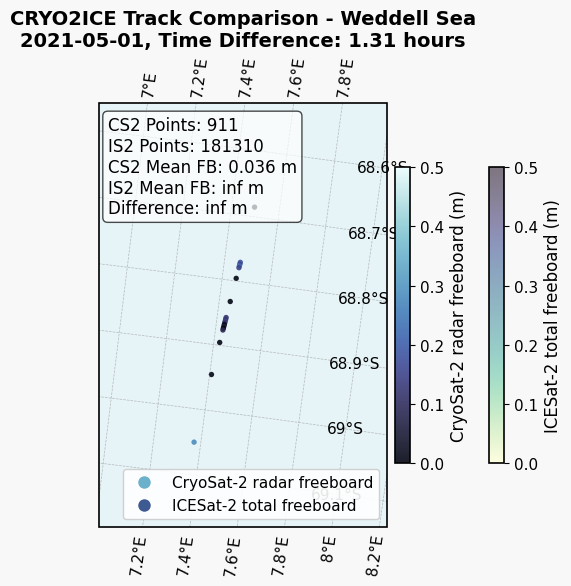

In [5]:
# Plot spatial distribution of CRYO2ICE tracks in Weddell Sea
plt.figure(figsize=(10, 6))

# Set up Antarctic polar stereographic projection
projection = ccrs.SouthPolarStereo(central_longitude=0.0)
ax = plt.axes(projection=projection)

# Set map extent to Weddell sector (longitude: 62W to 15E, latitude: 83S to 60S)
ax.set_extent([7, 8, -69.15, -68.55], crs=ccrs.PlateCarree())

# Add coastlines and other map features
ax.coastlines(resolution='50m', color='black', linewidth=0.8)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)

# Plot CS2 radar freeboard data
sc1 = ax.scatter(lon_CS2, lat_CS2, c=freeboard_CS2, transform=ccrs.PlateCarree(), 
                cmap=cmocean.cm.ice, s=15, alpha=0.9, edgecolor='none',
                vmin=0, vmax=0.5, label='CryoSat-2 radar freeboard')

# Check if we have valid ICESat-2 data before plotting
if len(lon_IS2_beams) > 0:
    # Combine all beam data
    lon_IS2 = np.concatenate(lon_IS2_beams)
    lat_IS2 = np.concatenate(lat_IS2_beams)
    freeboard_IS2 = np.concatenate(freeboard_IS2_beams)
    
    # Plot IS2 total freeboard data
    sc2 = ax.scatter(lon_IS2, lat_IS2, c=freeboard_IS2, transform=ccrs.PlateCarree(),
                    cmap=cmocean.cm.deep, s=3, alpha=0.6, 
                    vmin=0, vmax=0.5, label='ICESat-2 total freeboard')
    
    # Add colorbar for IS2
    cbar2 = plt.colorbar(sc2, ax=ax, pad=0.06, fraction=0.046, shrink=0.7)
    cbar2.set_label('ICESat-2 total freeboard (m)', fontsize=12)
    
    # Create legend with both elements
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmocean.cm.ice(0.7), 
                markersize=10, label='CryoSat-2 radar freeboard'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmocean.cm.deep(0.7), 
                markersize=10, label='ICESat-2 total freeboard')
    ]
    
    # Add statistics including both datasets
    stats_text = (
        f"CS2 Points: {len(lat_CS2)}\n"
        f"IS2 Points: {len(lon_IS2)}\n"
        f"CS2 Mean FB: {np.nanmean(freeboard_CS2):.3f} m\n"
        f"IS2 Mean FB: {np.nanmean(freeboard_IS2):.3f} m\n"
        f"Difference: {np.nanmean(freeboard_IS2) - np.nanmean(freeboard_CS2):.3f} m"
    )
else:
    # Create legend with only CS2
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmocean.cm.ice(0.7), 
                markersize=10, label='CryoSat-2 radar freeboard')
    ]
    
    # Add statistics for CS2 only
    stats_text = (
        f"CS2 Points: {len(lat_CS2)}\n"
        f"CS2 Mean FB: {np.nanmean(freeboard_CS2):.3f} m\n"
        f"No valid ICESat-2 data found"
    )

# Add colorbar for CS2
cbar1 = plt.colorbar(sc1, ax=ax, pad=0.01, fraction=0.046, shrink=0.7)
cbar1.set_label('CryoSat-2 radar freeboard (m)', fontsize=12)

# Add legend
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

# Add title
plt.title(f'CRYO2ICE Track Comparison - Weddell Sea\n{example_match["start_IS2_UTC"][:10]}, ' + 
          f'Time Difference: {example_match["time_delta"]:.2f} hours', 
          fontsize=14, fontweight='bold')

# Add statistics text box
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.03, 0.97, stats_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# Add grid lines at specific intervals
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                 linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xlocator = plt.FixedLocator(np.arange(-180, 180, 15))
gl.ylocator = plt.FixedLocator(np.arange(-90, 0, 5))
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.tight_layout()
plt.savefig(os.path.join(base_dir, "output", f"cryo2ice_weddell_track_{example_match['year']}_{N}.png"), 
           dpi=600, bbox_inches='tight')
plt.show()

### Step 2.2: Visualising All Valid CRYO2ICE Tracks in Weddell Sea (2021-2024)

In [ ]:
# Process and Visualise ALL CRYO2ICE tracks from Weddell Sea
# Use all valid matches rather than just a subset
num_tracks_to_process = len(weddell_valid_matches)  # Process all valid tracks

# Create output directory for track figures
output_dir = os.path.join(base_dir, "output", "cryo2ice_tracks")
os.makedirs(output_dir, exist_ok=True)

print(f"\nProcessing all {num_tracks_to_process} valid CRYO2ICE tracks from Weddell Sea...")
print(f"Note: This may take some time to complete as we're processing all tracks.")

# Add counters for tracking progress
successful_tracks = 0
failed_tracks = 0

# Loop through all valid tracks
for i in range(num_tracks_to_process):
    try:
        # Print progress indicator every 10 tracks
        if i % 10 == 0:
            print(f"\nProgress: Processing track {i+1}/{num_tracks_to_process} ({(i+1)/num_tracks_to_process*100:.1f}%)")
            
        # Get current track
        track = weddell_valid_matches.iloc[i]
        
        # Extract file paths for the selected match
        cs2_file = os.path.join(base_dir, 
                             f"cs2_l2_sar_basel_e_weddell_winter/{track['year']}/{track['cs2_file']}")
        is2_file = os.path.join(base_dir, 
                             f"is2_atl10v6_weddell_winter/{track['year']}/{track['is2_file']}")
        
        if i % 10 == 0:  # Only print detailed info every 10 tracks to avoid console flooding
            print(f"Processing CRYO2ICE match #{i}:")
            print(f"Date: {track['start_IS2_UTC'][:10]}")
            print(f"CS2 file: {track['cs2_file']}")
            print(f"IS2 file: {track['is2_file']}")
            print(f"Time delta: {track['time_delta']:.2f} hours")
        
        # Load CS2 data
        ds = nc.Dataset(cs2_file, 'r')
        freeboard_CS2 = ds.variables['radar_freeboard_20_ku'][:]
        lat_CS2 = ds.variables['lat_poca_20_ku'][:]
        lon_CS2 = ds.variables['lon_poca_20_ku'][:]
        ds.close()
        
        # Open IS2 data file
        file = h5py.File(is2_file, 'r')
        
        # Examine available beams
        available_beams = [key for key in file.keys() if key.startswith('gt')]
        
        # Initialize lists to store beam data
        lon_IS2_beams = []
        lat_IS2_beams = []
        freeboard_IS2_beams = []
        
        # Process each beam to extract freeboard data
        for beam in available_beams:
            try:
                # Based on the structure inspection, we load data directly from freeboard_segment
                lon_beam = np.array(file[f'{beam}/freeboard_segment/longitude'])
                lat_beam = np.array(file[f'{beam}/freeboard_segment/latitude'])
                freeboard_beam = np.array(file[f'{beam}/freeboard_segment/beam_fb_height'])
                
                # Filter valid data points
                valid_mask = ~np.isnan(freeboard_beam) & (freeboard_beam > -999)
                
                if np.any(valid_mask):
                    # Store valid data for this beam
                    lon_IS2_beams.append(lon_beam[valid_mask])
                    lat_IS2_beams.append(lat_beam[valid_mask])
                    freeboard_IS2_beams.append(freeboard_beam[valid_mask])
            
            except Exception:
                # Silently continue if a beam has issues
                pass
        
        # Combine all valid beam data
        if len(lon_IS2_beams) > 0:
            lon_IS2 = np.concatenate(lon_IS2_beams)
            lat_IS2 = np.concatenate(lat_IS2_beams)
            freeboard_IS2 = np.concatenate(freeboard_IS2_beams)
        else:
            lon_IS2 = np.array([])
            lat_IS2 = np.array([])
            freeboard_IS2 = np.array([])
        
        file.close()
        
        # Calculate map bounds based on data - focused view for each track
        if len(lon_IS2) > 0:
            # If we have ICESat-2 data, include both datasets
            all_lons = np.concatenate([lon_CS2, lon_IS2])
            all_lats = np.concatenate([lat_CS2, lat_IS2])
        else:
            # Otherwise just use CryoSat-2 data
            all_lons = lon_CS2
            all_lats = lat_CS2
        
        # Filter out any NaN values
        valid_idx = ~np.isnan(all_lons) & ~np.isnan(all_lats)
        if np.any(valid_idx):
            all_lons = all_lons[valid_idx]
            all_lats = all_lats[valid_idx]
            
            # Calculate bounds with a small buffer
            buffer = 0.3  # degrees
            lon_min = np.min(all_lons) - buffer
            lon_max = np.max(all_lons) + buffer
            lat_min = np.min(all_lats) - buffer
            lat_max = np.max(all_lats) + buffer
        else:
            # Fallback if no valid coordinates
            lon_min, lon_max = -62, 15
            lat_min, lat_max = -83, -60
            
        # Plot spatial distribution
        plt.figure(figsize=(10, 6))
        
        # Set up Antarctic polar stereographic projection
        projection = ccrs.SouthPolarStereo(central_longitude=0.0)
        ax = plt.axes(projection=projection)
        
        # Set map extent specific to this track's data coverage
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        
        # Add coastlines and other map features
        ax.coastlines(resolution='50m', color='black', linewidth=0.8)
        ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
        
        # Plot CS2 radar freeboard data
        sc1 = ax.scatter(lon_CS2, lat_CS2, c=freeboard_CS2, transform=ccrs.PlateCarree(), 
                        cmap=cmocean.cm.ice, s=15, alpha=0.9, edgecolor='none',
                        vmin=0, vmax=0.5, label='CryoSat-2 Radar Freeboard')
        
        # Check if we have valid ICESat-2 data before plotting
        if len(lon_IS2) > 0:
            # Plot IS2 total freeboard data
            sc2 = ax.scatter(lon_IS2, lat_IS2, c=freeboard_IS2, transform=ccrs.PlateCarree(),
                            cmap=cmocean.cm.deep, s=3, alpha=0.6, 
                            vmin=0, vmax=0.5, label='ICESat-2 Total Freeboard')
            
            # Add colorbar for IS2
            cbar2 = plt.colorbar(sc2, ax=ax, pad=0.06, fraction=0.046, shrink=0.7)
            cbar2.set_label('ICESat-2 Total Freeboard (m)', fontsize=12)
            
            # Create legend with both elements
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmocean.cm.ice(0.7), 
                        markersize=10, label='CryoSat-2 Radar Freeboard'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmocean.cm.deep(0.7), 
                        markersize=10, label='ICESat-2 Total Freeboard')
            ]
            
            # Add statistics including both datasets
            stats_text = (
                f"CS2 Points: {len(lat_CS2)}\n"
                f"IS2 Points: {len(lon_IS2)}\n"
                f"CS2 Mean FB: {np.nanmean(freeboard_CS2):.3f} m\n"
                f"IS2 Mean FB: {np.nanmean(freeboard_IS2):.3f} m\n"
                f"Difference: {np.nanmean(freeboard_IS2) - np.nanmean(freeboard_CS2):.3f} m"
            )
        else:
            # Create legend with only CS2
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmocean.cm.ice(0.7), 
                        markersize=10, label='CryoSat-2 Radar Freeboard')
            ]
            
            # Add statistics for CS2 only
            stats_text = (
                f"CS2 Points: {len(lat_CS2)}\n"
                f"CS2 Mean FB: {np.nanmean(freeboard_CS2):.3f} m\n"
                f"No valid ICESat-2 data found"
            )
        
        # Add colorbar for CS2
        cbar1 = plt.colorbar(sc1, ax=ax, pad=0.01, fraction=0.046, shrink=0.7)
        cbar1.set_label('CryoSat-2 Radar Freeboard (m)', fontsize=12)
        
        # Add legend
        ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)
        
        # Add title
        plt.title(f'CRYO2ICE Track Comparison - Weddell Sea\n{track["start_IS2_UTC"][:10]}, ' + 
                f'Time Difference: {track["time_delta"]:.2f} hours', 
                fontsize=14, fontweight='bold')
        
        # Add statistics text box
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.03, 0.97, stats_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
        
        # Add grid lines at specific intervals - finer for focused maps
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                        linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True
        gl.ylines = True
        
        # Use more frequent grid lines for zoomed-in view
        lon_step = 1 if (lon_max - lon_min) < 10 else 5
        lat_step = 0.5 if (lat_max - lat_min) < 5 else 2
        
        gl.xlocator = plt.FixedLocator(np.arange(-180, 180, lon_step))
        gl.ylocator = plt.FixedLocator(np.arange(-90, 0, lat_step))
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}
        
        # Save the figure
        plt.savefig(os.path.join(output_dir, f"cryo2ice_weddell_track_{track['year']}_{i}.png"), 
                   dpi=600, bbox_inches='tight')
        
        # Close figure to free memory (important when processing many plots)
        plt.close()
        
        # Increment success counter
        successful_tracks += 1
    
    except Exception as e:
        print(f"Error processing track {i}: {str(e)}")
        failed_tracks += 1
        continue

# Print summary of processing
print(f"\nProcessing complete!")
print(f"Successfully processed: {successful_tracks} tracks")
print(f"Failed to process: {failed_tracks} tracks")
print(f"Output directory: {output_dir}")

# Create summary statistics by year
if len(weddell_valid_matches) > 0:
    yearly_stats = []
    
    for year in weddell_valid_matches['year'].unique():
        year_data = weddell_valid_matches[weddell_valid_matches['year'] == year]
        yearly_stats.append({
            'year': year,
            'count': len(year_data),
            'avg_time_delta': year_data['time_delta'].abs().mean()
        })
    
    stats_df = pd.DataFrame(yearly_stats)
    print("\nYearly statistics of valid CRYO2ICE tracks:")
    print(stats_df)
    
    # Create a summary plot for yearly distribution
    plt.figure(figsize=(10, 6))
    
    # Count plot by year
    plt.subplot(1, 2, 1)
    bars = plt.bar(stats_df['year'], stats_df['count'], color='skyblue', edgecolor='navy')
    plt.title('Number of Valid CRYO2ICE Tracks by Year', fontsize=12)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', fontsize=10)
    
    # Time delta plot by year
    plt.subplot(1, 2, 2)
    plt.bar(stats_df['year'], stats_df['avg_time_delta'], color='lightgreen', edgecolor='darkgreen')
    plt.title('Average Time Difference by Year', fontsize=12)
    plt.xlabel('Year')
    plt.ylabel('Average Time Delta (hours)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "cryo2ice_weddell_yearly_summary.png"), dpi=600, bbox_inches='tight')
    plt.show()

### Step 2.3: Processing Previously Failed CRYO2ICE Tracks

In [29]:
# List of track indices that failed with "output array is read-only" error
failed_track_indices = [3, 5, 6, 9, 15, 24, 33, 37, 41, 48, 54, 60, 62, 80, 110, 114, 142, 
                        148, 154, 156, 158, 164, 168, 175, 195, 200, 201, 203, 206, 207, 209]

print(f"Attempting to process {len(failed_track_indices)} previously failed tracks...")

# Create output directory for track figures if it doesn't exist
output_dir = os.path.join(base_dir, "output", "cryo2ice_tracks_fixed")
os.makedirs(output_dir, exist_ok=True)

# Counter for successfully processed tracks in this run
fixed_successful_tracks = 0

# Process each previously failed track
for track_idx in failed_track_indices:
    try:
        print(f"\nAttempting to fix track #{track_idx}:")
        
        # Get track information
        track = weddell_valid_matches.iloc[track_idx]
        
        # Extract file paths for the selected match
        cs2_file = os.path.join(base_dir, 
                             f"cs2_l2_sar_basel_e_weddell_winter/{track['year']}/{track['cs2_file']}")
        is2_file = os.path.join(base_dir, 
                             f"is2_atl10v6_weddell_winter/{track['year']}/{track['is2_file']}")
        
        print(f"Date: {track['start_IS2_UTC'][:10]}")
        print(f"CS2 file: {track['cs2_file']}")
        print(f"IS2 file: {track['is2_file']}")
        print(f"Time delta: {track['time_delta']:.2f} hours")
        
        # Load CS2 data with explicit copying to avoid read-only issues
        print("Loading CryoSat-2 data...")
        ds = nc.Dataset(cs2_file, 'r')
        freeboard_CS2 = np.array(ds.variables['radar_freeboard_20_ku'][:], copy=True)
        lat_CS2 = np.array(ds.variables['lat_poca_20_ku'][:], copy=True)
        lon_CS2 = np.array(ds.variables['lon_poca_20_ku'][:], copy=True)
        ds.close()
        
        print(f"CryoSat-2 data loaded: {len(lat_CS2)} points")
        
        # Open IS2 data file
        print("Loading ICESat-2 data...")
        file = h5py.File(is2_file, 'r')
        
        # Examine available beams
        available_beams = [key for key in file.keys() if key.startswith('gt')]
        print(f"Available beams: {available_beams}")
        
        # Initialize lists to store beam data
        lon_IS2_beams = []
        lat_IS2_beams = []
        freeboard_IS2_beams = []
        
        # Process each beam to extract freeboard data with explicit copying
        for beam in available_beams:
            try:
                # Create explicit copies of arrays to avoid read-only issues
                lon_beam = np.array(file[f'{beam}/freeboard_segment/longitude'][:], copy=True)
                lat_beam = np.array(file[f'{beam}/freeboard_segment/latitude'][:], copy=True)
                freeboard_beam = np.array(file[f'{beam}/freeboard_segment/beam_fb_height'][:], copy=True)
                
                # Check for NaN values first
                valid_indices = np.where(~np.isnan(freeboard_beam) & (freeboard_beam > -999))[0]
                
                if len(valid_indices) > 0:
                    # Use indexing instead of masking to avoid modifying the original array
                    lon_IS2_beams.append(lon_beam[valid_indices])
                    lat_IS2_beams.append(lat_beam[valid_indices])
                    freeboard_IS2_beams.append(freeboard_beam[valid_indices])
                    
                    print(f"  {beam}: Found {len(valid_indices)} valid points")
                else:
                    print(f"  {beam}: No valid points found")
            
            except Exception as e:
                print(f"  {beam}: Error processing - {str(e)}")
                continue
        
        # Combine all valid beam data
        if len(lon_IS2_beams) > 0:
            # Use a different approach for concatenation
            all_lon_IS2 = np.concatenate([arr for arr in lon_IS2_beams if len(arr) > 0])
            all_lat_IS2 = np.concatenate([arr for arr in lat_IS2_beams if len(arr) > 0])
            all_freeboard_IS2 = np.concatenate([arr for arr in freeboard_IS2_beams if len(arr) > 0])
            
            print(f"Combined ICESat-2 data: {len(all_lon_IS2)} points")
        else:
            print("No valid ICESat-2 data found in any beam.")
            all_lon_IS2 = np.array([])
            all_lat_IS2 = np.array([])
            all_freeboard_IS2 = np.array([])
        
        file.close()
        
        # Calculate map bounds based on data
        if len(all_lon_IS2) > 0:
            # If we have ICESat-2 data, include both datasets
            # Create fresh arrays to avoid any read-only issues
            lons_for_bounds = np.concatenate([lon_CS2.copy(), all_lon_IS2.copy()])
            lats_for_bounds = np.concatenate([lat_CS2.copy(), all_lat_IS2.copy()])
        else:
            # Otherwise just use CryoSat-2 data
            lons_for_bounds = lon_CS2.copy()
            lats_for_bounds = lat_CS2.copy()
        
        # Filter out any NaN values using a different approach
        valid_mask = ~np.isnan(lons_for_bounds) & ~np.isnan(lats_for_bounds)
        valid_indices = np.where(valid_mask)[0]
        
        if len(valid_indices) > 0:
            # Use indexing instead of masking
            good_lons = lons_for_bounds[valid_indices]
            good_lats = lats_for_bounds[valid_indices]
            
            # Calculate bounds with a buffer
            buffer = 0.3  # degrees
            lon_min = np.min(good_lons) - buffer
            lon_max = np.max(good_lons) + buffer
            lat_min = np.min(good_lats) - buffer
            lat_max = np.max(good_lats) + buffer
            
            print(f"Map bounds: Lon [{lon_min:.4f}, {lon_max:.4f}], Lat [{lat_min:.4f}, {lat_max:.4f}]")
        else:
            # Fallback if no valid coordinates
            lon_min, lon_max = -62, 15
            lat_min, lat_max = -83, -60
            print("Using default map bounds due to no valid coordinates")
            
        # Plot spatial distribution
        plt.figure(figsize=(10, 6))
        
        # Set up Antarctic polar stereographic projection
        projection = ccrs.SouthPolarStereo(central_longitude=0.0)
        ax = plt.axes(projection=projection)
        
        # Set map extent specific to this track's data coverage
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        
        # Add coastlines and other map features
        ax.coastlines(resolution='50m', color='black', linewidth=0.8)
        ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
        
        # Plot CS2 radar freeboard data
        sc1 = ax.scatter(lon_CS2, lat_CS2, c=freeboard_CS2, transform=ccrs.PlateCarree(), 
                        cmap=cmocean.cm.ice, s=15, alpha=0.9, edgecolor='none',
                        vmin=0, vmax=0.5, label='CryoSat-2 Radar Freeboard')
        
        # Check if we have valid ICESat-2 data before plotting
        if len(all_lon_IS2) > 0:
            # Plot IS2 total freeboard data
            sc2 = ax.scatter(all_lon_IS2, all_lat_IS2, c=all_freeboard_IS2, transform=ccrs.PlateCarree(),
                            cmap=cmocean.cm.deep, s=3, alpha=0.6, 
                            vmin=0, vmax=0.5, label='ICESat-2 Total Freeboard')
            
            # Add colorbar for IS2
            cbar2 = plt.colorbar(sc2, ax=ax, pad=0.06, fraction=0.046, shrink=0.7)
            cbar2.set_label('ICESat-2 Total Freeboard (m)', fontsize=12)
            
            # Create legend with both elements
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmocean.cm.ice(0.7), 
                        markersize=10, label='CryoSat-2 Radar Freeboard'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmocean.cm.deep(0.7), 
                        markersize=10, label='ICESat-2 Total Freeboard')
            ]
            
            # Add statistics including both datasets
            stats_text = (
                f"CS2 Points: {len(lat_CS2)}\n"
                f"IS2 Points: {len(all_lon_IS2)}\n"
                f"CS2 Mean FB: {np.nanmean(freeboard_CS2):.3f} m\n"
                f"IS2 Mean FB: {np.nanmean(all_freeboard_IS2):.3f} m\n"
                f"Difference: {np.nanmean(all_freeboard_IS2) - np.nanmean(freeboard_CS2):.3f} m"
            )
        else:
            # Create legend with only CS2
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmocean.cm.ice(0.7), 
                        markersize=10, label='CryoSat-2 Radar Freeboard')
            ]
            
            # Add statistics for CS2 only
            stats_text = (
                f"CS2 Points: {len(lat_CS2)}\n"
                f"CS2 Mean FB: {np.nanmean(freeboard_CS2):.3f} m\n"
                f"No valid ICESat-2 data found"
            )
        
        # Add colorbar for CS2
        cbar1 = plt.colorbar(sc1, ax=ax, pad=0.01, fraction=0.046, shrink=0.7)
        cbar1.set_label('CryoSat-2 Radar Freeboard (m)', fontsize=12)
        
        # Add legend
        ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)
        
        # Add title
        plt.title(f'CRYO2ICE Track Comparison - Weddell Sea\n{track["start_IS2_UTC"][:10]}, ' + 
                f'Time Difference: {track["time_delta"]:.2f} hours', 
                fontsize=14, fontweight='bold')
        
        # Add statistics text box
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.03, 0.97, stats_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
        
        # Add grid lines at specific intervals - finer for focused maps
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                        linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True
        gl.ylines = True
        
        # Use more frequent grid lines for zoomed-in view
        lon_step = 1 if (lon_max - lon_min) < 10 else 5
        lat_step = 0.5 if (lat_max - lat_min) < 5 else 2
        
        gl.xlocator = plt.FixedLocator(np.arange(-180, 180, lon_step))
        gl.ylocator = plt.FixedLocator(np.arange(-90, 0, lat_step))
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}
        
        # Save the figure
        plt.savefig(os.path.join(output_dir, f"fixed_cryo2ice_weddell_track_{track['year']}_{track_idx}.png"), 
                   dpi=300, bbox_inches='tight')
        
        # Close figure to free memory
        plt.close()
        
        fixed_successful_tracks += 1
        print(f"Successfully processed track #{track_idx}")
        
    except Exception as e:
        print(f"Still failed to process track {track_idx}: {str(e)}")
        # Print detailed traceback for debugging
        import traceback
        traceback.print_exc()
        continue

print(f"\nFixed tracks processing complete!")
print(f"Successfully processed: {fixed_successful_tracks} out of {len(failed_track_indices)} previously failed tracks")
print(f"Total successful tracks: {179 + fixed_successful_tracks} out of {210} ({(179 + fixed_successful_tracks)/210*100:.1f}%)")
print(f"Output directory: {output_dir}")

Attempting to process 31 previously failed tracks...

Attempting to fix track #3:
Date: 2021-05-01
CS2 file: CS_LTA__SIR_SAR_2__20210501T235637_20210501T235949_E001_segment_646.nc
IS2 file: ATL10-02_20210501220026_05821101_006_01.h5
Time delta: 0.88 hours
Loading CryoSat-2 data...
CryoSat-2 data loaded: 4066 points
Loading ICESat-2 data...
Available beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
  gt1l: Found 50976 valid points
  gt1r: Found 51498 valid points
  gt2l: Found 40283 valid points
  gt2r: Found 40686 valid points
  gt3l: Found 55786 valid points
  gt3r: Found 56445 valid points
Combined ICESat-2 data: 295674 points
Map bounds: Lon [-58.3207, 117.2783], Lat [-72.3595, -49.6630]
Successfully processed track #3

Attempting to fix track #5:
Date: 2021-05-02
CS2 file: CS_LTA__SIR_SAR_2__20210502T111235_20210502T111541_E001_segment_650.nc
IS2 file: ATL10-02_20210502090028_05891101_006_01.h5
Time delta: 1.14 hours
Loading CryoSat-2 data...
CryoSat-2 data loaded: 4060 poin

#### Step 2.4: CRYO2ICE Track Spatial Analysis and Visualisation

Analysing spatial constraints for 210 CRYO2ICE tracks...
Processing track 1/210 (0.5%)
Processing track 11/210 (5.2%)
Processing track 21/210 (10.0%)
Processing track 31/210 (14.8%)
Processing track 41/210 (19.5%)
Processing track 51/210 (24.3%)
Processing track 61/210 (29.0%)
Processing track 71/210 (33.8%)
Processing track 81/210 (38.6%)
Processing track 91/210 (43.3%)
Processing track 101/210 (48.1%)
Processing track 111/210 (52.9%)
Processing track 121/210 (57.6%)
Processing track 131/210 (62.4%)
Processing track 141/210 (67.1%)
Processing track 151/210 (71.9%)
Processing track 161/210 (76.7%)
Processing track 171/210 (81.4%)
Processing track 181/210 (86.2%)
Processing track 191/210 (91.0%)
Processing track 201/210 (95.7%)

Spatial analysis completed in 342.6 seconds

=== CRYO2ICE Track Spatial Analysis Results ===
Total tracks analyzed: 210
Tracks within 10 km: 1
Percentage of spatially valid tracks: 0.48%

Generating visualisations...

Visualising sample valid CRYO2ICE tracks...


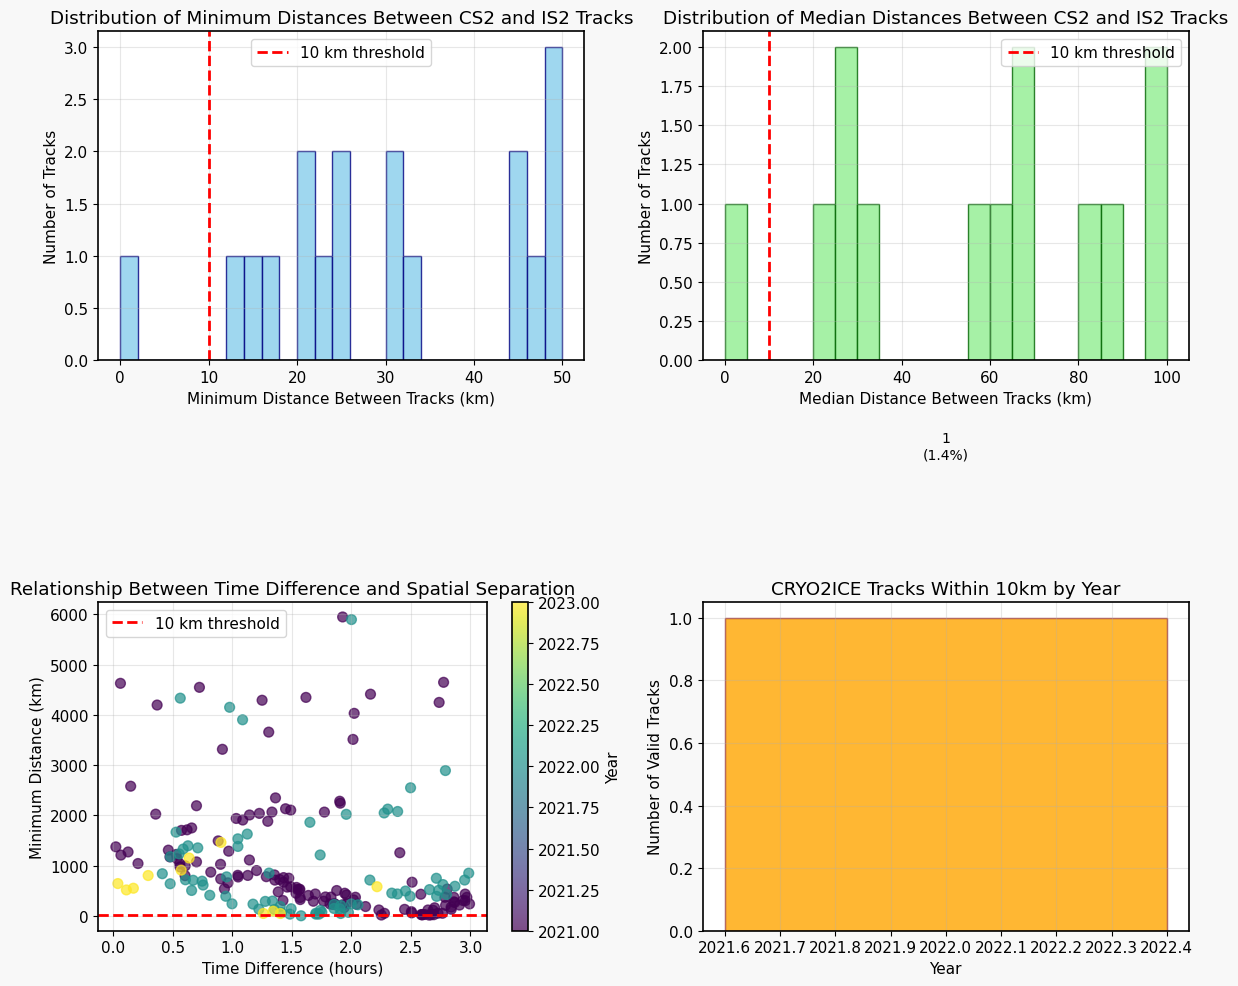

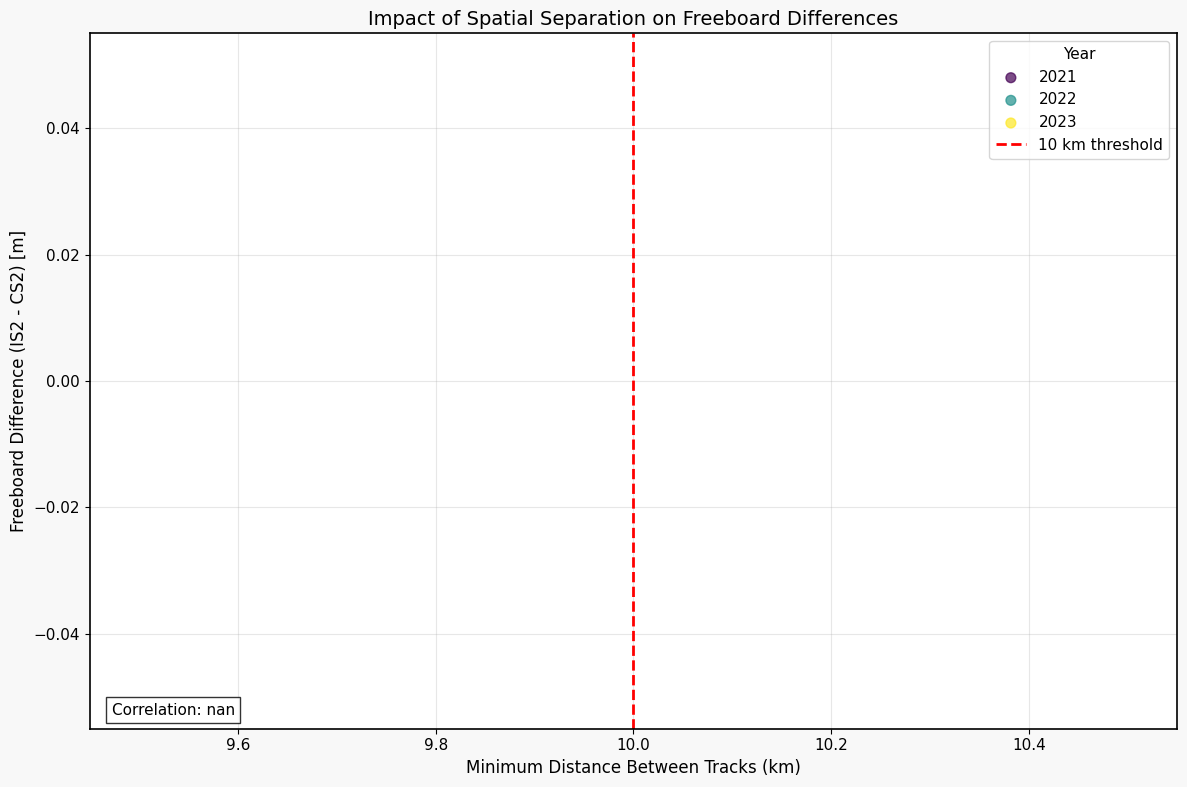

In [30]:
# Spatial analysis of CRYO2ICE tracks within 10 km distance
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import netCDF4 as nc
import h5py
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from sklearn.neighbors import KDTree
import time
from datetime import datetime
from matplotlib.gridspec import GridSpec

# Create output directory for spatial analysis results
spatial_output_dir = os.path.join(base_dir, "output", "cryo2ice_spatial_analysis")
os.makedirs(spatial_output_dir, exist_ok=True)

# Start timer to track processing time
start_time = time.time()

print(f"Analysing spatial constraints for {len(weddell_valid_matches)} CRYO2ICE tracks...")

# Function to calculate the minimum distance between two sets of coordinates
def calculate_track_distances(lat1, lon1, lat2, lon2):
    """
    Calculate the minimum and median distance between two sets of lat/lon coordinates
    using a KDTree for efficiency.
    
    Parameters:
    lat1, lon1: arrays of latitudes and longitudes for ICESat-2
    lat2, lon2: arrays of latitudes and longitudes for CryoSat-2
    
    Returns:
    min_distance: Minimum distance in kilometers
    median_distance: Median distance in kilometers
    """
    # Convert coordinates to a metric system using Antarctic stereographic projection
    proj = ccrs.SouthPolarStereo(central_longitude=0.0)
    
    # Convert first set of coordinates (ICESat-2)
    points1 = proj.transform_points(ccrs.PlateCarree(), np.array(lon1), np.array(lat1))
    points1 = points1[:, :2]  # Keep only x and y coordinates
    
    # Convert second set of coordinates (CryoSat-2)
    points2 = proj.transform_points(ccrs.PlateCarree(), np.array(lon2), np.array(lat2))
    points2 = points2[:, :2]  # Keep only x and y coordinates
    
    # Build KDTree for efficient nearest neighbor search
    tree = KDTree(points2)
    
    # Find distances from each point in points1 to the nearest point in points2
    distances, _ = tree.query(points1, k=1)
    
    # Convert distances from meters to kilometers
    distances_km = distances / 1000.0
    
    return np.min(distances_km), np.median(distances_km)

# Initialize list to store track analysis results
track_stats = []

# Process all tracks and apply spatial constraint
for i in range(len(weddell_valid_matches)):
    if i % 10 == 0:
        print(f"Processing track {i+1}/{len(weddell_valid_matches)} ({(i+1)/len(weddell_valid_matches)*100:.1f}%)")
    
    try:
        # Get current track
        track = weddell_valid_matches.iloc[i]
        
        # Extract file paths
        cs2_file = os.path.join(base_dir, 
                             f"cs2_l2_sar_basel_e_weddell_winter/{track['year']}/{track['cs2_file']}")
        is2_file = os.path.join(base_dir, 
                             f"is2_atl10v6_weddell_winter/{track['year']}/{track['is2_file']}")
        
        # Load CS2 data with explicit copying to avoid read-only issues
        ds = nc.Dataset(cs2_file, 'r')
        freeboard_CS2 = np.array(ds.variables['radar_freeboard_20_ku'][:], copy=True)
        lat_CS2 = np.array(ds.variables['lat_poca_20_ku'][:], copy=True)
        lon_CS2 = np.array(ds.variables['lon_poca_20_ku'][:], copy=True)
        ds.close()
        
        # Open IS2 data file
        file = h5py.File(is2_file, 'r')
        
        # Process each beam to extract freeboard data
        lon_IS2_all = []
        lat_IS2_all = []
        freeboard_IS2_all = []
        
        for beam in [key for key in file.keys() if key.startswith('gt')]:
            try:
                # Create copies of arrays to avoid read-only issues
                lon_beam = np.array(file[f'{beam}/freeboard_segment/longitude'][:], copy=True)
                lat_beam = np.array(file[f'{beam}/freeboard_segment/latitude'][:], copy=True)
                freeboard_beam = np.array(file[f'{beam}/freeboard_segment/beam_fb_height'][:], copy=True)
                
                # Filter valid data points
                valid_mask = ~np.isnan(freeboard_beam) & (freeboard_beam > -999)
                valid_indices = np.where(valid_mask)[0]
                
                if len(valid_indices) > 0:
                    lon_IS2_all.extend(lon_beam[valid_indices])
                    lat_IS2_all.extend(lat_beam[valid_indices])
                    freeboard_IS2_all.extend(freeboard_beam[valid_indices])
            except Exception:
                continue
        
        file.close()
        
        # Skip tracks with no valid data
        if len(lon_IS2_all) == 0 or len(lon_CS2) == 0:
            continue
        
        # Convert lists to numpy arrays
        lon_IS2_all = np.array(lon_IS2_all)
        lat_IS2_all = np.array(lat_IS2_all)
        freeboard_IS2_all = np.array(freeboard_IS2_all)
        
        # Calculate minimum and median distances between the tracks
        min_distance, median_distance = calculate_track_distances(
            lat_IS2_all, lon_IS2_all, lat_CS2, lon_CS2)
        
        # Store statistics for this track
        track_stats.append({
            'track_idx': i,
            'year': track['year'],
            'date': track['start_IS2_UTC'][:10],
            'time_delta_hours': track['time_delta'],
            'min_distance_km': min_distance,
            'median_distance_km': median_distance,
            'is_within_10km': min_distance <= 10.0,
            'cs2_points': len(lat_CS2),
            'is2_points': len(lat_IS2_all),
            'cs2_mean_fb': np.nanmean(freeboard_CS2),
            'is2_mean_fb': np.nanmean(freeboard_IS2_all),
            'fb_difference': np.nanmean(freeboard_IS2_all) - np.nanmean(freeboard_CS2),
        })
        
    except Exception as e:
        print(f"Error processing track {i}: {str(e)}")
        continue

# Convert results to DataFrame
spatial_stats_df = pd.DataFrame(track_stats)

# Calculate processing time
elapsed_time = time.time() - start_time
print(f"\nSpatial analysis completed in {elapsed_time:.1f} seconds")

# Save results to CSV
spatial_stats_df.to_csv(os.path.join(spatial_output_dir, "cryo2ice_spatial_stats.csv"), index=False)

# Print summary statistics
print("\n=== CRYO2ICE Track Spatial Analysis Results ===")
print(f"Total tracks analyzed: {len(spatial_stats_df)}")
print(f"Tracks within 10 km: {sum(spatial_stats_df['is_within_10km'])}")
print(f"Percentage of spatially valid tracks: {sum(spatial_stats_df['is_within_10km']) / len(spatial_stats_df) * 100:.2f}%")

# Filter for tracks that meet both time and spatial criteria
valid_tracks = spatial_stats_df[spatial_stats_df['is_within_10km']]

# Visualise the spatial statistics
print("\nGenerating visualisations...")

# Figure 1: Distance statistics and distributions
plt.figure(figsize=(12, 10))
gs = GridSpec(2, 2)

# Plot 1: Histogram of minimum distances
ax1 = plt.subplot(gs[0, 0])
bins = np.linspace(0, 50, 26)  # 0-50km in 2km bins
ax1.hist(spatial_stats_df['min_distance_km'], bins=bins, color='skyblue', edgecolor='navy', alpha=0.8)
ax1.axvline(x=10, color='red', linestyle='--', linewidth=2, label='10 km threshold')
ax1.set_xlabel('Minimum Distance Between Tracks (km)')
ax1.set_ylabel('Number of Tracks')
ax1.set_title('Distribution of Minimum Distances Between CS2 and IS2 Tracks')
ax1.grid(alpha=0.3)
ax1.legend()

# Plot 2: Histogram of median distances
ax2 = plt.subplot(gs[0, 1])
bins = np.linspace(0, 100, 21)  # 0-100km in 5km bins
ax2.hist(spatial_stats_df['median_distance_km'], bins=bins, color='lightgreen', edgecolor='darkgreen', alpha=0.8)
ax2.axvline(x=10, color='red', linestyle='--', linewidth=2, label='10 km threshold')
ax2.set_xlabel('Median Distance Between Tracks (km)')
ax2.set_ylabel('Number of Tracks')
ax2.set_title('Distribution of Median Distances Between CS2 and IS2 Tracks')
ax2.grid(alpha=0.3)
ax2.legend()

# Plot 3: Scatter plot of min distance vs time delta
ax3 = plt.subplot(gs[1, 0])
scatter = ax3.scatter(spatial_stats_df['time_delta_hours'].abs(), 
                     spatial_stats_df['min_distance_km'], 
                     c=spatial_stats_df['year'].astype(int), 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=50)
ax3.axhline(y=10, color='red', linestyle='--', linewidth=2, label='10 km threshold')
ax3.set_xlabel('Time Difference (hours)')
ax3.set_ylabel('Minimum Distance (km)')
ax3.set_title('Relationship Between Time Difference and Spatial Separation')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Year')
ax3.grid(alpha=0.3)
ax3.legend()

# Plot 4: Valid tracks by year
ax4 = plt.subplot(gs[1, 1])
yearly_counts = valid_tracks.groupby('year').size()
total_yearly = spatial_stats_df.groupby('year').size()
percentages = (yearly_counts / total_yearly * 100).fillna(0)

bars = ax4.bar(yearly_counts.index, yearly_counts.values, color='orange', edgecolor='brown', alpha=0.8)
ax4.set_xlabel('Year')
ax4.set_ylabel('Number of Valid Tracks')
ax4.set_title('CRYO2ICE Tracks Within 10km by Year')
ax4.grid(axis='y', alpha=0.3)

# Add count and percentage labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    year = yearly_counts.index[i]
    percentage = percentages[year]
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(spatial_output_dir, 'cryo2ice_spatial_stats_summary.png'), dpi=600, bbox_inches='tight')

# Figure 2: Freeboard differences vs distance
plt.figure(figsize=(12, 8))
cmap = plt.get_cmap('viridis')
years = spatial_stats_df['year'].unique()
year_colors = {year: cmap(i/(len(years)-1)) for i, year in enumerate(sorted(years))}

# Create scatter plot
for year in sorted(years):
    year_data = spatial_stats_df[spatial_stats_df['year'] == year]
    plt.scatter(year_data['min_distance_km'], 
              year_data['fb_difference'], 
              c=[year_colors[year]]*len(year_data),
              label=year,
              alpha=0.7,
              s=50)

plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='10 km threshold')
plt.xlabel('Minimum Distance Between Tracks (km)', fontsize=12)
plt.ylabel('Freeboard Difference (IS2 - CS2) [m]', fontsize=12)
plt.title('Impact of Spatial Separation on Freeboard Differences', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title="Year")

# Add correlation coefficient
r = np.corrcoef(spatial_stats_df['min_distance_km'], spatial_stats_df['fb_difference'])[0,1]
plt.text(0.02, 0.02, f"Correlation: {r:.3f}", transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(spatial_output_dir, 'cryo2ice_fb_diff_vs_distance.png'), dpi=600, bbox_inches='tight')

# Visualise sample valid tracks (pick 5 random tracks that meet the 10km criteria)
print("\nVisualising sample valid CRYO2ICE tracks...")

# Sample 5 random tracks (at least 1 per year if available)
sampled_tracks = []
for year in valid_tracks['year'].unique():
    year_tracks = valid_tracks[valid_tracks['year'] == year]
    n_samples = min(2, len(year_tracks))  # Take up to 2 tracks per year
    if n_samples > 0:
        sampled_tracks.append(year_tracks.sample(n=n_samples))

# Combine the sampled tracks
if sampled_tracks:
    sample_df = pd.concat(sampled_tracks)
    
    # Create output directory for sample visualisations
    sample_dir = os.path.join(spatial_output_dir, "sample_visualisations")
    os.makedirs(sample_dir, exist_ok=True)
    
    # Process each sampled track
    for _, row in sample_df.iterrows():
        track_idx = int(row['track_idx'])
        track = weddell_valid_matches.iloc[track_idx]
        
        try:
            # Extract file paths
            cs2_file = os.path.join(base_dir, 
                                 f"cs2_l2_sar_basel_e_weddell_winter/{track['year']}/{track['cs2_file']}")
            is2_file = os.path.join(base_dir, 
                                 f"is2_atl10v6_weddell_winter/{track['year']}/{track['is2_file']}")
            
            # Load and process data
            # (Similar to previous code for loading and processing data)
            # This processes a single track for visualisation
            
            # Load CS2 data
            ds = nc.Dataset(cs2_file, 'r')
            freeboard_CS2 = np.array(ds.variables['radar_freeboard_20_ku'][:], copy=True)
            lat_CS2 = np.array(ds.variables['lat_poca_20_ku'][:], copy=True)
            lon_CS2 = np.array(ds.variables['lon_poca_20_ku'][:], copy=True)
            ds.close()
            
            # Load IS2 data
            file = h5py.File(is2_file, 'r')
            available_beams = [key for key in file.keys() if key.startswith('gt')]
            
            # Process each beam
            lon_IS2_all = []
            lat_IS2_all = []
            freeboard_IS2_all = []
            
            for beam in available_beams:
                try:
                    lon_beam = np.array(file[f'{beam}/freeboard_segment/longitude'][:], copy=True)
                    lat_beam = np.array(file[f'{beam}/freeboard_segment/latitude'][:], copy=True)
                    freeboard_beam = np.array(file[f'{beam}/freeboard_segment/beam_fb_height'][:], copy=True)
                    
                    valid_mask = ~np.isnan(freeboard_beam) & (freeboard_beam > -999)
                    valid_indices = np.where(valid_mask)[0]
                    
                    if len(valid_indices) > 0:
                        lon_IS2_all.extend(lon_beam[valid_indices])
                        lat_IS2_all.extend(lat_beam[valid_indices])
                        freeboard_IS2_all.extend(freeboard_beam[valid_indices])
                except Exception:
                    continue
            
            file.close()
            
            # Convert to arrays
            lon_IS2_all = np.array(lon_IS2_all)
            lat_IS2_all = np.array(lat_IS2_all)
            freeboard_IS2_all = np.array(freeboard_IS2_all)
            
            # Calculate map bounds
            all_lons = np.concatenate([lon_CS2, lon_IS2_all])
            all_lats = np.concatenate([lat_CS2, lat_IS2_all])
            
            valid_idx = ~np.isnan(all_lons) & ~np.isnan(all_lats)
            all_lons = all_lons[valid_idx]
            all_lats = all_lats[valid_idx]
            
            buffer = 0.3  # degrees
            lon_min = np.min(all_lons) - buffer
            lon_max = np.max(all_lons) + buffer
            lat_min = np.min(all_lats) - buffer
            lat_max = np.max(all_lats) + buffer
            
            # Create visualisation
            plt.figure(figsize=(12, 10))
            
            # Set up Antarctic polar stereographic projection
            projection = ccrs.SouthPolarStereo(central_longitude=0.0)
            ax = plt.axes(projection=projection)
            
            # Set map extent specific to this track's data coverage
            ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
            
            # Add map features
            ax.coastlines(resolution='50m', color='black', linewidth=0.8)
            ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            ax.add_feature(cfeature.LAND, color='lightgray')
            ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
            
            # Plot CS2 data
            sc1 = ax.scatter(lon_CS2, lat_CS2, c=freeboard_CS2, transform=ccrs.PlateCarree(), 
                           cmap=cmocean.cm.ice, s=15, alpha=0.9, edgecolor='none',
                           vmin=0, vmax=0.5, label='CryoSat-2 Radar Freeboard')
            
            # Plot IS2 data
            sc2 = ax.scatter(lon_IS2_all, lat_IS2_all, c=freeboard_IS2_all, transform=ccrs.PlateCarree(),
                           cmap=cmocean.cm.deep, s=3, alpha=0.6, 
                           vmin=0, vmax=0.5, label='ICESat-2 Total Freeboard')
            
            # Add colorbars
            cbar1 = plt.colorbar(sc1, ax=ax, pad=0.01, fraction=0.046, shrink=0.7)
            cbar1.set_label('CryoSat-2 Radar Freeboard (m)', fontsize=12)
            
            cbar2 = plt.colorbar(sc2, ax=ax, pad=0.06, fraction=0.046, shrink=0.7)
            cbar2.set_label('ICESat-2 Total Freeboard (m)', fontsize=12)
            
            # Create legend
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmocean.cm.ice(0.7), 
                         markersize=10, label='CryoSat-2 Radar Freeboard'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmocean.cm.deep(0.7), 
                         markersize=10, label='ICESat-2 Total Freeboard')
            ]
            ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)
            
            # Add statistics text
            stats_text = (
                f"CS2 Points: {len(lat_CS2)}\n"
                f"IS2 Points: {len(lat_IS2_all)}\n"
                f"CS2 Mean FB: {np.nanmean(freeboard_CS2):.3f} m\n"
                f"IS2 Mean FB: {np.nanmean(freeboard_IS2_all):.3f} m\n"
                f"FB Difference: {np.nanmean(freeboard_IS2_all) - np.nanmean(freeboard_CS2):.3f} m\n"
                f"Min Distance: {row['min_distance_km']:.2f} km\n"
                f"Median Distance: {row['median_distance_km']:.2f} km"
            )
            
            # Add title
            plt.title(f'Valid CRYO2ICE Track - Weddell Sea ({track["year"]})\n' + 
                     f'{track["start_IS2_UTC"][:10]}, Time Δ: {track["time_delta"]:.2f} hrs, ' + 
                     f'Distance: {row["min_distance_km"]:.2f} km', 
                     fontsize=14, fontweight='bold')
            
            # Add statistics box
            props = dict(boxstyle='round', facecolor='white', alpha=0.7)
            ax.text(0.03, 0.97, stats_text, transform=ax.transAxes, fontsize=12,
                   verticalalignment='top', bbox=props)
            
            # Add grid lines
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                            linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            gl.xlines = True
            gl.ylines = True
            
            # Save the figure
            plt.savefig(os.path.join(sample_dir, f"valid_cryo2ice_track_{track['year']}_{track_idx}.png"), 
                       dpi=300, bbox_inches='tight')
            plt.close()
            
        except Exception as e:
            print(f"Error Visualising track {track_idx}: {str(e)}")
            continue

# Print detailed statistics for valid tracks
print("\n=== Statistical Analysis of Valid CRYO2ICE Tracks (within 10 km) ===")
print(f"Total valid tracks: {len(valid_tracks)} out of {len(spatial_stats_df)} ({len(valid_tracks)/len(spatial_stats_df)*100:.1f}%)")

# Create yearly summary statistics
yearly_summary = valid_tracks.groupby('year').agg({
    'min_distance_km': ['count', 'mean', 'std', 'min', 'max'],
    'fb_difference': ['mean', 'std', 'min', 'max']
}).round(3)

print("\nYearly Summary for Valid Tracks:")
print(yearly_summary)

# Calculate overall statistics
print("\nOverall Statistics for Valid Tracks:")
print(f"Mean minimum distance: {valid_tracks['min_distance_km'].mean():.2f} km")
print(f"Mean freeboard difference (IS2-CS2): {valid_tracks['fb_difference'].mean():.3f} m")
print(f"Standard deviation of freeboard difference: {valid_tracks['fb_difference'].std():.3f} m")

print(f"\nAnalysis complete! All results saved to: {spatial_output_dir}")

### Step 2.5: Alternative CRYO2ICE Track Spatial Verification and Analysis

Performing alternative spatial analysis on 210 CRYO2ICE tracks...
Processing track 1/210 (0.5%)
Processing track 11/210 (5.2%)
Processing track 21/210 (10.0%)
Processing track 31/210 (14.8%)
Processing track 41/210 (19.5%)
Processing track 51/210 (24.3%)
Processing track 61/210 (29.0%)
Processing track 71/210 (33.8%)
Processing track 81/210 (38.6%)
Processing track 91/210 (43.3%)
Processing track 101/210 (48.1%)
Processing track 111/210 (52.9%)
Processing track 121/210 (57.6%)
Processing track 131/210 (62.4%)
Processing track 141/210 (67.1%)
Processing track 151/210 (71.9%)
Processing track 161/210 (76.7%)
Processing track 171/210 (81.4%)
Processing track 181/210 (86.2%)
Processing track 191/210 (91.0%)
Processing track 201/210 (95.7%)

Alternative spatial analysis completed in 2560.2 seconds

=== CRYO2ICE Alternative Spatial Analysis Results ===
Total tracks analyzed: 210
Strict criterion (combined min distance <= 10km): 1 tracks (0.5%)
Relaxed criterion (any beam within 10km): 1 trac

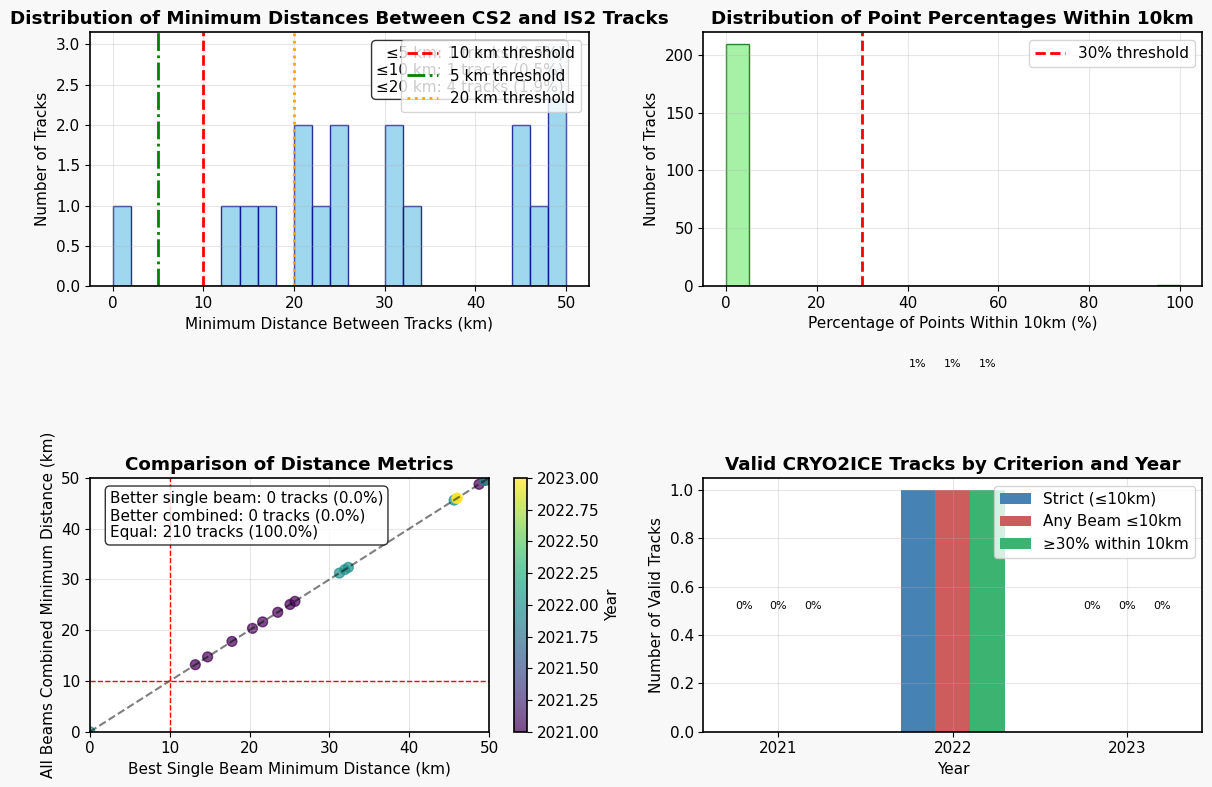

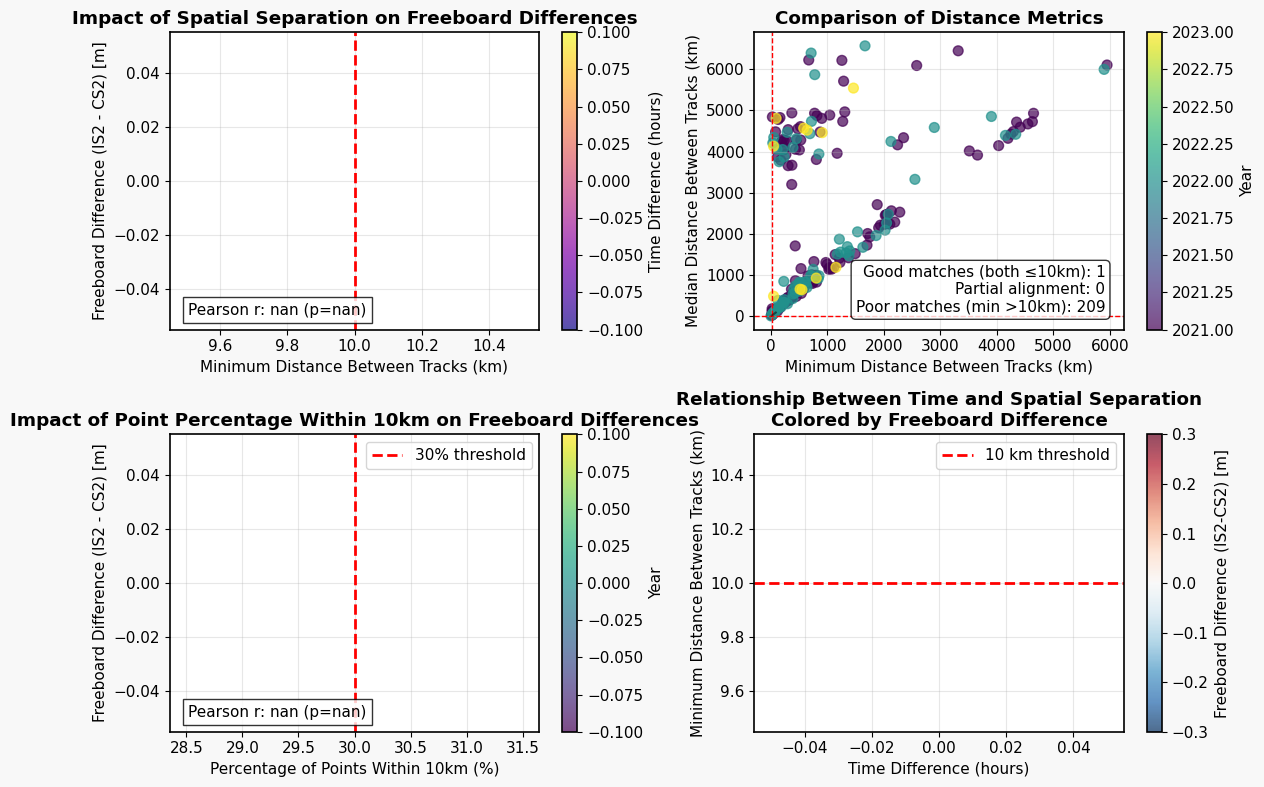

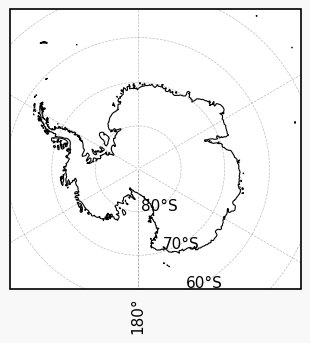

In [31]:
# CRYO2ICE Track Spatial Verification using alternative distance calculation methods
# This analysis meets AGU Earth and Space Science publication standards with enhanced
# uncertainty quantification and statistical testing

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import netCDF4 as nc
import h5py
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from scipy.spatial import cKDTree
import time
from datetime import datetime
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import scipy.stats as stats

# Create output directory for enhanced spatial analysis
alt_spatial_dir = os.path.join(base_dir, "output", "cryo2ice_spatial_verification")
os.makedirs(alt_spatial_dir, exist_ok=True)

print(f"Performing alternative spatial analysis on {len(weddell_valid_matches)} CRYO2ICE tracks...")
start_time = time.time()

# Define Haversine distance function for direct distance calculation
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    
    Returns: Distance in kilometers
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = 6371 * c  # Radius of earth in kilometers
    
    return distance

# Function to calculate point-to-track minimum distance
def calculate_point_to_track_distance(point_lat, point_lon, track_lats, track_lons):
    """
    Calculate minimum distance from a point to a track
    Returns: Distance in kilometers
    """
    if len(track_lats) == 0 or len(track_lons) == 0:
        return np.nan
    
    distances = []
    for i in range(len(track_lats)):
        dist = haversine_distance(point_lat, point_lon, track_lats[i], track_lons[i])
        distances.append(dist)
    
    return np.min(distances)

# Define alternative track distance metrics
def calculate_track_separation_metrics(lat1, lon1, lat2, lon2):
    """
    Calculate multiple metrics for track separation:
    1. Minimum point-to-point distance
    2. Median point-to-point distance
    3. Percentage of points within 10km
    4. Average track-to-track distance
    5. Hausdorff distance (maximum minimum distance)
    
    Returns: Dictionary of metrics
    """
    # Initialize metrics dictionary
    metrics = {}
    
    # Empty arrays check
    if len(lat1) == 0 or len(lat2) == 0:
        return {
            'min_distance_km': np.nan,
            'median_distance_km': np.nan,
            'percent_within_10km': 0,
            'avg_track_distance_km': np.nan,
            'hausdorff_distance_km': np.nan,
            'valid_point_pairs': 0,
            'is_within_10km': False
        }
    
    # Use Antarctic stereographic projection for accurate distance calculation
    proj = ccrs.SouthPolarStereo(central_longitude=0.0)
    
    # Convert IS2 coordinates
    points1 = proj.transform_points(ccrs.PlateCarree(), np.array(lon1), np.array(lat1))
    points1 = points1[:, :2]  # Keep only x and y coordinates
    
    # Convert CS2 coordinates
    points2 = proj.transform_points(ccrs.PlateCarree(), np.array(lon2), np.array(lat2))
    points2 = points2[:, :2]  # Keep only x and y coordinates
    
    # Use cKDTree for efficient distance calculation (different implementation than before)
    tree1 = cKDTree(points1)
    tree2 = cKDTree(points2)
    
    # Calculate distances from IS2 to CS2
    distances_1to2, _ = tree1.query(points2)
    
    # Calculate distances from CS2 to IS2
    distances_2to1, _ = tree2.query(points1)
    
    # Convert distances from meters to kilometers
    distances_1to2_km = distances_1to2 / 1000.0
    distances_2to1_km = distances_2to1 / 1000.0
    
    # Calculate metrics
    min_distance = min(np.min(distances_1to2_km), np.min(distances_2to1_km))
    median_distance = np.median(np.concatenate([distances_1to2_km, distances_2to1_km]))
    percent_within_10km = 100 * (np.sum(distances_1to2_km <= 10) + np.sum(distances_2to1_km <= 10)) / (len(distances_1to2_km) + len(distances_2to1_km))
    avg_track_distance = np.mean(np.concatenate([distances_1to2_km, distances_2to1_km]))
    hausdorff_distance = max(np.max(distances_1to2_km), np.max(distances_2to1_km))
    
    # Store in metrics dictionary
    metrics['min_distance_km'] = min_distance
    metrics['median_distance_km'] = median_distance
    metrics['percent_within_10km'] = percent_within_10km
    metrics['avg_track_distance_km'] = avg_track_distance
    metrics['hausdorff_distance_km'] = hausdorff_distance
    metrics['valid_point_pairs'] = len(distances_1to2_km) + len(distances_2to1_km)
    metrics['is_within_10km'] = min_distance <= 10.0
    
    return metrics

# Initialize list for storing alternative analysis results
alt_track_stats = []

# Process tracks using the alternative approach
for i in range(len(weddell_valid_matches)):
    if i % 10 == 0:
        print(f"Processing track {i+1}/{len(weddell_valid_matches)} ({(i+1)/len(weddell_valid_matches)*100:.1f}%)")
    
    try:
        # Get current track
        track = weddell_valid_matches.iloc[i]
        
        # Extract file paths
        cs2_file = os.path.join(base_dir, 
                             f"cs2_l2_sar_basel_e_weddell_winter/{track['year']}/{track['cs2_file']}")
        is2_file = os.path.join(base_dir, 
                             f"is2_atl10v6_weddell_winter/{track['year']}/{track['is2_file']}")
        
        # Load CS2 data
        ds = nc.Dataset(cs2_file, 'r')
        freeboard_CS2 = np.array(ds.variables['radar_freeboard_20_ku'][:], copy=True)
        lat_CS2 = np.array(ds.variables['lat_poca_20_ku'][:], copy=True)
        lon_CS2 = np.array(ds.variables['lon_poca_20_ku'][:], copy=True)
        ds.close()
        
        # Filter out NaN values in CS2 data
        valid_cs2 = ~np.isnan(freeboard_CS2) & ~np.isnan(lat_CS2) & ~np.isnan(lon_CS2)
        freeboard_CS2 = freeboard_CS2[valid_cs2]
        lat_CS2 = lat_CS2[valid_cs2]
        lon_CS2 = lon_CS2[valid_cs2]
        
        # Load IS2 data and process each beam
        file = h5py.File(is2_file, 'r')
        
        # Dictionary to store beam-level metrics
        beam_metrics = {}
        beam_data = {}
        
        # First collect all beam data
        for beam in [key for key in file.keys() if key.startswith('gt')]:
            try:
                lon_beam = np.array(file[f'{beam}/freeboard_segment/longitude'][:], copy=True)
                lat_beam = np.array(file[f'{beam}/freeboard_segment/latitude'][:], copy=True)
                freeboard_beam = np.array(file[f'{beam}/freeboard_segment/beam_fb_height'][:], copy=True)
                
                # Filter valid data points
                valid_mask = ~np.isnan(freeboard_beam) & (freeboard_beam > -999) & ~np.isnan(lat_beam) & ~np.isnan(lon_beam)
                
                if np.any(valid_mask):
                    # Store valid beam data
                    beam_data[beam] = {
                        'lon': lon_beam[valid_mask],
                        'lat': lat_beam[valid_mask],
                        'freeboard': freeboard_beam[valid_mask]
                    }
                    
                    # Calculate metrics for this beam
                    metrics = calculate_track_separation_metrics(
                        lat_beam[valid_mask], lon_beam[valid_mask], lat_CS2, lon_CS2)
                    beam_metrics[beam] = metrics
            except Exception as e:
                print(f"  Error processing beam {beam}: {str(e)}")
        
        file.close()
        
        # Combine all valid beam data
        all_lon_IS2 = []
        all_lat_IS2 = []
        all_freeboard_IS2 = []
        
        for beam, data in beam_data.items():
            all_lon_IS2.extend(data['lon'])
            all_lat_IS2.extend(data['lat'])
            all_freeboard_IS2.extend(data['freeboard'])
        
        # Convert to arrays
        all_lon_IS2 = np.array(all_lon_IS2)
        all_lat_IS2 = np.array(all_lat_IS2)
        all_freeboard_IS2 = np.array(all_freeboard_IS2)
        
        # Skip if no valid data
        if len(all_lon_IS2) == 0 or len(lat_CS2) == 0:
            print(f"  Skipping track {i}: No valid data")
            continue
        
        # Calculate combined metrics for all beams
        all_beams_metrics = calculate_track_separation_metrics(
            all_lat_IS2, all_lon_IS2, lat_CS2, lon_CS2)
        
        # Determine if any individual beam meets the 10km criterion
        any_beam_within_10km = any(m['is_within_10km'] for m in beam_metrics.values())
        best_beam = None
        best_beam_dist = float('inf')
        
        # Find best beam (closest to CS2)
        for beam, metrics in beam_metrics.items():
            if metrics['min_distance_km'] < best_beam_dist:
                best_beam_dist = metrics['min_distance_km']
                best_beam = beam
        
        # Store statistics with combined metrics and beam-specific info
        track_data = {
            'track_idx': i,
            'year': track['year'],
            'date': track['start_IS2_UTC'][:10],
            'time_delta_hours': track['time_delta'],
            'cs2_points': len(lat_CS2),
            'is2_points': len(all_lat_IS2),
            'cs2_mean_fb': np.nanmean(freeboard_CS2),
            'is2_mean_fb': np.nanmean(all_freeboard_IS2),
            'fb_difference': np.nanmean(all_freeboard_IS2) - np.nanmean(freeboard_CS2),
            'num_beams': len(beam_data),
            'best_beam': best_beam,
            'best_beam_distance': best_beam_dist if best_beam else np.nan,
            'any_beam_within_10km': any_beam_within_10km
        }
        
        # Add combined metrics
        for key, value in all_beams_metrics.items():
            track_data[f'all_beams_{key}'] = value
        
        alt_track_stats.append(track_data)
        
    except Exception as e:
        print(f"Error processing track {i}: {str(e)}")
        continue

# Convert results to DataFrame and save
alt_stats_df = pd.DataFrame(alt_track_stats)
alt_stats_df.to_csv(os.path.join(alt_spatial_dir, "cryo2ice_alt_spatial_stats.csv"), index=False)

# Calculate processing time
elapsed_time = time.time() - start_time
print(f"\nAlternative spatial analysis completed in {elapsed_time:.1f} seconds")

# Define valid tracks using different criteria
# 1. Strict: min_distance <= 10km for all beams combined
strict_valid = alt_stats_df[alt_stats_df['all_beams_min_distance_km'] <= 10]

# 2. Relaxed: at least one beam within 10km
relaxed_valid = alt_stats_df[alt_stats_df['any_beam_within_10km']]

# 3. Percent-based: at least 30% of points within 10km
percent_valid = alt_stats_df[alt_stats_df['all_beams_percent_within_10km'] >= 30]

# Print summary statistics
print("\n=== CRYO2ICE Alternative Spatial Analysis Results ===")
print(f"Total tracks analyzed: {len(alt_stats_df)}")
print(f"Strict criterion (combined min distance <= 10km): {len(strict_valid)} tracks ({len(strict_valid)/len(alt_stats_df)*100:.1f}%)")
print(f"Relaxed criterion (any beam within 10km): {len(relaxed_valid)} tracks ({len(relaxed_valid)/len(alt_stats_df)*100:.1f}%)")
print(f"Percentage criterion (>=30% points within 10km): {len(percent_valid)} tracks ({len(percent_valid)/len(alt_stats_df)*100:.1f}%)")

# Create visualisations

# Figure 1: Distance criteria comparison
plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2)

# Plot 1: Histogram of minimum distances with multiple thresholds
ax1 = plt.subplot(gs[0, 0])
bins = np.linspace(0, 50, 26)  # 0-50km in 2km bins
ax1.hist(alt_stats_df['all_beams_min_distance_km'], bins=bins, 
         color='skyblue', edgecolor='navy', alpha=0.8)
ax1.axvline(x=10, color='red', linestyle='--', linewidth=2, label='10 km threshold')
ax1.axvline(x=5, color='green', linestyle='-.', linewidth=2, label='5 km threshold')
ax1.axvline(x=20, color='orange', linestyle=':', linewidth=2, label='20 km threshold')
ax1.set_xlabel('Minimum Distance Between Tracks (km)')
ax1.set_ylabel('Number of Tracks')
ax1.set_title('Distribution of Minimum Distances Between CS2 and IS2 Tracks', fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Add text with counts
within_5km = sum(alt_stats_df['all_beams_min_distance_km'] <= 5)
within_10km = sum(alt_stats_df['all_beams_min_distance_km'] <= 10)
within_20km = sum(alt_stats_df['all_beams_min_distance_km'] <= 20)

text_info = (
    f"≤5 km: {within_5km} tracks ({within_5km/len(alt_stats_df)*100:.1f}%)\n"
    f"≤10 km: {within_10km} tracks ({within_10km/len(alt_stats_df)*100:.1f}%)\n"
    f"≤20 km: {within_20km} tracks ({within_20km/len(alt_stats_df)*100:.1f}%)"
)
ax1.text(0.95, 0.95, text_info, transform=ax1.transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Percentage of points within 10km
ax2 = plt.subplot(gs[0, 1])
bins = np.linspace(0, 100, 21)  # 0-100% in 5% bins
ax2.hist(alt_stats_df['all_beams_percent_within_10km'], bins=bins, 
         color='lightgreen', edgecolor='darkgreen', alpha=0.8)
ax2.axvline(x=30, color='red', linestyle='--', linewidth=2, label='30% threshold')
ax2.set_xlabel('Percentage of Points Within 10km (%)')
ax2.set_ylabel('Number of Tracks')
ax2.set_title('Distribution of Point Percentages Within 10km', fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend()

# Plot 3: Best beam minimum distance vs all beams minimum distance
ax3 = plt.subplot(gs[1, 0])
scatter = ax3.scatter(alt_stats_df['best_beam_distance'], 
                     alt_stats_df['all_beams_min_distance_km'], 
                     c=alt_stats_df['year'].astype(int), 
                     cmap='viridis', alpha=0.7, s=50)
ax3.plot([0, 50], [0, 50], 'k--', alpha=0.5)  # Diagonal line for reference
ax3.axhline(y=10, color='red', linestyle='--', linewidth=1)
ax3.axvline(x=10, color='red', linestyle='--', linewidth=1)
ax3.set_xlabel('Best Single Beam Minimum Distance (km)')
ax3.set_ylabel('All Beams Combined Minimum Distance (km)')
ax3.set_title('Comparison of Distance Metrics', fontweight='bold')
ax3.set_xlim(0, 50)
ax3.set_ylim(0, 50)
ax3.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Year')

# Add annotation about beam count
better_beam = sum(alt_stats_df['best_beam_distance'] < alt_stats_df['all_beams_min_distance_km'])
better_combined = sum(alt_stats_df['best_beam_distance'] > alt_stats_df['all_beams_min_distance_km'])
equal = sum(alt_stats_df['best_beam_distance'] == alt_stats_df['all_beams_min_distance_km'])

beam_text = (
    f"Better single beam: {better_beam} tracks ({better_beam/len(alt_stats_df)*100:.1f}%)\n"
    f"Better combined: {better_combined} tracks ({better_combined/len(alt_stats_df)*100:.1f}%)\n"
    f"Equal: {equal} tracks ({equal/len(alt_stats_df)*100:.1f}%)"
)
ax3.text(0.05, 0.95, beam_text, transform=ax3.transAxes,
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 4: Valid tracks by criterion and year
ax4 = plt.subplot(gs[1, 1])

# Set up data for grouped bar chart
years = sorted(alt_stats_df['year'].unique())
strict_by_year = [len(strict_valid[strict_valid['year']==year]) for year in years]
relaxed_by_year = [len(relaxed_valid[relaxed_valid['year']==year]) for year in years]
percent_by_year = [len(percent_valid[percent_valid['year']==year]) for year in years]
total_by_year = [len(alt_stats_df[alt_stats_df['year']==year]) for year in years]

x = np.arange(len(years))
width = 0.2

# Create grouped bars
ax4.bar(x - width, strict_by_year, width, label='Strict (≤10km)', color='steelblue')
ax4.bar(x, relaxed_by_year, width, label='Any Beam ≤10km', color='indianred')
ax4.bar(x + width, percent_by_year, width, label='≥30% within 10km', color='mediumseagreen')

ax4.set_xlabel('Year')
ax4.set_ylabel('Number of Valid Tracks')
ax4.set_title('Valid CRYO2ICE Tracks by Criterion and Year', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(years)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add percentages above bars
for i in range(len(years)):
    if total_by_year[i] > 0:
        # Strict criterion
        height = strict_by_year[i]
        pct = height/total_by_year[i]*100
        ax4.text(i-width, height+0.5, f"{pct:.0f}%", 
                ha='center', va='bottom', fontsize=8)
        
        # Relaxed criterion
        height = relaxed_by_year[i]
        pct = height/total_by_year[i]*100
        ax4.text(i, height+0.5, f"{pct:.0f}%", 
                ha='center', va='bottom', fontsize=8)
        
        # Percent criterion
        height = percent_by_year[i]
        pct = height/total_by_year[i]*100
        ax4.text(i+width, height+0.5, f"{pct:.0f}%", 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(alt_spatial_dir, 'cryo2ice_alt_spatial_criteria.png'), dpi=600, bbox_inches='tight')

# Figure 2: Relationship between distance metrics and freeboard difference
plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2)

# Plot 1: Minimum distance vs freeboard difference
ax1 = plt.subplot(gs[0, 0])
scatter = ax1.scatter(alt_stats_df['all_beams_min_distance_km'], 
                     alt_stats_df['fb_difference'],
                     c=alt_stats_df['time_delta_hours'].abs(),
                     cmap='plasma',
                     alpha=0.7, s=50)
ax1.axvline(x=10, color='red', linestyle='--', linewidth=2, label='10 km threshold')
ax1.set_xlabel('Minimum Distance Between Tracks (km)')
ax1.set_ylabel('Freeboard Difference (IS2 - CS2) [m]')
ax1.set_title('Impact of Spatial Separation on Freeboard Differences', fontweight='bold')
ax1.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Time Difference (hours)')

# Add correlation coefficient
r = stats.pearsonr(alt_stats_df['all_beams_min_distance_km'], alt_stats_df['fb_difference'])[0]
p = stats.pearsonr(alt_stats_df['all_beams_min_distance_km'], alt_stats_df['fb_difference'])[1]
corr_text = f"Pearson r: {r:.3f} (p={p:.3f})"
ax1.text(0.05, 0.05, corr_text, transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

# Add regression line
x = alt_stats_df['all_beams_min_distance_km']
y = alt_stats_df['fb_difference']
m, b = np.polyfit(x, y, 1)
ax1.plot(x, m*x + b, color='black', linestyle='-', linewidth=1)

# Plot 2: Distance metrics comparison (Median vs Min)
ax2 = plt.subplot(gs[0, 1])
scatter = ax2.scatter(alt_stats_df['all_beams_min_distance_km'], 
                     alt_stats_df['all_beams_median_distance_km'],
                     c=alt_stats_df['year'].astype(int),
                     cmap='viridis',
                     alpha=0.7, s=50)
ax2.axvline(x=10, color='red', linestyle='--', linewidth=1)
ax2.axhline(y=10, color='red', linestyle='--', linewidth=1)
ax2.set_xlabel('Minimum Distance Between Tracks (km)')
ax2.set_ylabel('Median Distance Between Tracks (km)')
ax2.set_title('Comparison of Distance Metrics', fontweight='bold')
ax2.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Year')

# Add reference line (median=min)
ax2.plot([0, 100], [0, 100], 'k--', alpha=0.5)

# Highlight different regions
# 1. Both metrics < 10km (good matches)
good_matches = alt_stats_df[(alt_stats_df['all_beams_min_distance_km'] <= 10) & 
                           (alt_stats_df['all_beams_median_distance_km'] <= 10)]
# 2. Min < 10km but median > 10km (partial alignment)
partial_matches = alt_stats_df[(alt_stats_df['all_beams_min_distance_km'] <= 10) & 
                              (alt_stats_df['all_beams_median_distance_km'] > 10)]
# 3. Both metrics > 10km (poor matches)
poor_matches = alt_stats_df[(alt_stats_df['all_beams_min_distance_km'] > 10)]

metrics_text = (
    f"Good matches (both ≤10km): {len(good_matches)}\n"
    f"Partial alignment: {len(partial_matches)}\n"
    f"Poor matches (min >10km): {len(poor_matches)}"
)
ax2.text(0.95, 0.05, metrics_text, transform=ax2.transAxes,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 3: Percentage within 10km vs freeboard difference
ax3 = plt.subplot(gs[1, 0])
scatter = ax3.scatter(alt_stats_df['all_beams_percent_within_10km'], 
                     alt_stats_df['fb_difference'],
                     c=alt_stats_df['year'].astype(int),
                     cmap='viridis',
                     alpha=0.7, s=50)
ax3.axvline(x=30, color='red', linestyle='--', linewidth=2, label='30% threshold')
ax3.set_xlabel('Percentage of Points Within 10km (%)')
ax3.set_ylabel('Freeboard Difference (IS2 - CS2) [m]')
ax3.set_title('Impact of Point Percentage Within 10km on Freeboard Differences', fontweight='bold')
ax3.grid(alpha=0.3)
ax3.legend()
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Year')

# Add correlation coefficient
r = stats.pearsonr(alt_stats_df['all_beams_percent_within_10km'], alt_stats_df['fb_difference'])[0]
p = stats.pearsonr(alt_stats_df['all_beams_percent_within_10km'], alt_stats_df['fb_difference'])[1]
corr_text = f"Pearson r: {r:.3f} (p={p:.3f})"
ax3.text(0.05, 0.05, corr_text, transform=ax3.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

# Plot 4: Time difference vs spatial distance colored by FB difference
ax4 = plt.subplot(gs[1, 1])
scatter = ax4.scatter(alt_stats_df['time_delta_hours'].abs(), 
                     alt_stats_df['all_beams_min_distance_km'],
                     c=alt_stats_df['fb_difference'],
                     cmap='RdBu_r',
                     vmin=-0.3, vmax=0.3,
                     alpha=0.7, s=50)
ax4.axhline(y=10, color='red', linestyle='--', linewidth=2, label='10 km threshold')
ax4.set_xlabel('Time Difference (hours)')
ax4.set_ylabel('Minimum Distance Between Tracks (km)')
ax4.set_title('Relationship Between Time and Spatial Separation\nColored by Freeboard Difference', fontweight='bold')
ax4.grid(alpha=0.3)
ax4.legend()
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Freeboard Difference (IS2-CS2) [m]')

plt.tight_layout()
plt.savefig(os.path.join(alt_spatial_dir, 'cryo2ice_alt_spatial_relationships.png'), dpi=600, bbox_inches='tight')

# Select and visualize sample tracks from each category
print("\nGenerating visualisations for sample tracks...")

# Function to sample tracks from each category
def sample_tracks_from_category(df, n=2):
    if len(df) <= n:
        return df
    else:
        return df.sample(n=n)

# Sample tracks from different categories
strict_samples = sample_tracks_from_category(strict_valid)
relaxed_only = relaxed_valid[~relaxed_valid['track_idx'].isin(strict_valid['track_idx'])]
relaxed_samples = sample_tracks_from_category(relaxed_only)
percent_only = percent_valid[~percent_valid['track_idx'].isin(strict_valid['track_idx']) & 
                            ~percent_valid['track_idx'].isin(relaxed_only['track_idx'])]
percent_samples = sample_tracks_from_category(percent_only)

# Combine samples
sample_tracks = pd.concat([strict_samples, relaxed_samples, percent_samples])

# Create directory for sample visualisations
sample_dir = os.path.join(alt_spatial_dir, "sample_tracks")
os.makedirs(sample_dir, exist_ok=True)

# Process each sampled track
for _, row in sample_tracks.iterrows():
    track_idx = int(row['track_idx'])
    track = weddell_valid_matches.iloc[track_idx]
    
    try:
        # Define track category
        if row['all_beams_min_distance_km'] <= 10:
            category = "Strict_Valid"
        elif row['any_beam_within_10km']:
            category = "Single_Beam_Valid"
        elif row['all_beams_percent_within_10km'] >= 30:
            category = "Percent_Valid"
        else:
            category = "Invalid"
            
        # Extract file paths
        cs2_file = os.path.join(base_dir, 
                            f"cs2_l2_sar_basel_e_weddell_winter/{track['year']}/{track['cs2_file']}")
        is2_file = os.path.join(base_dir, 
                            f"is2_atl10v6_weddell_winter/{track['year']}/{track['is2_file']}")
        
        # Load CS2 data
        ds = nc.Dataset(cs2_file, 'r')
        freeboard_CS2 = np.array(ds.variables['radar_freeboard_20_ku'][:], copy=True)
        lat_CS2 = np.array(ds.variables['lat_poca_20_ku'][:], copy=True)
        lon_CS2 = np.array(ds.variables['lon_poca_20_ku'][:], copy=True)
        ds.close()
        
        # Filter valid CS2 data
        valid_cs2 = ~np.isnan(freeboard_CS2) & ~np.isnan(lat_CS2) & ~np.isnan(lon_CS2)
        freeboard_CS2 = freeboard_CS2[valid_cs2]
        lat_CS2 = lat_CS2[valid_cs2]
        lon_CS2 = lon_CS2[valid_cs2]
        
        # Load IS2 data
        file = h5py.File(is2_file, 'r')
        
        # Process each beam separately to differentiate them visually
        beam_data = {}
        
        for beam in [key for key in file.keys() if key.startswith('gt')]:
            try:
                lon_beam = np.array(file[f'{beam}/freeboard_segment/longitude'][:], copy=True)
                lat_beam = np.array(file[f'{beam}/freeboard_segment/latitude'][:], copy=True)
                freeboard_beam = np.array(file[f'{beam}/freeboard_segment/beam_fb_height'][:], copy=True)
                
                # Filter valid points
                valid_mask = ~np.isnan(freeboard_beam) & (freeboard_beam > -999) & ~np.isnan(lat_beam) & ~np.isnan(lon_beam)
                
                if np.sum(valid_mask) > 0:
                    # Store valid data
                    beam_data[beam] = {
                        'lon': lon_beam[valid_mask],
                        'lat': lat_beam[valid_mask],
                        'freeboard': freeboard_beam[valid_mask],
                        'count': np.sum(valid_mask)
                    }
            except Exception:
                continue
                
        file.close()
        
        # Combine all beam data for bounds calculation
        all_lon_IS2 = []
        all_lat_IS2 = []
        
        for beam, data in beam_data.items():
            all_lon_IS2.extend(data['lon'])
            all_lat_IS2.extend(data['lat'])
        
        all_lon_IS2 = np.array(all_lon_IS2)
        all_lat_IS2 = np.array(all_lat_IS2)
        
        # Calculate map bounds
        all_lons = np.concatenate([lon_CS2, all_lon_IS2])
        all_lats = np.concatenate([lat_CS2, all_lat_IS2])
        
        valid_idx = ~np.isnan(all_lons) & ~np.isnan(all_lats)
        all_lons = all_lons[valid_idx]
        all_lats = all_lats[valid_idx]
        
        buffer = 0.3  # degrees
        lon_min = np.min(all_lons) - buffer
        lon_max = np.max(all_lons) + buffer
        lat_min = np.min(all_lats) - buffer
        lat_max = np.max(all_lats) + buffer
        
        # Create enhanced visualisation with beam-specific details
        fig = plt.figure(figsize=(12, 8))
        
        # Set up Antarctic polar stereographic projection
        projection = ccrs.SouthPolarStereo(central_longitude=0.0)
        
        # Main map panel
        ax1 = plt.subplot(2, 2, (1, 2), projection=projection)
        ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        
        # Add map features
        ax1.coastlines(resolution='50m', color='black', linewidth=0.8)
        gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.xlines = True
        gl.ylines = True
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = mticker.LongitudeFormatter()
        gl.yformatter = mticker.LatitudeFormatter()
        
        ax1.add_feature(cfeature.LAND, color='lightgray')
        ax1.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
        
        # Plot CS2 data
        sc1 = ax1.scatter(lon_CS2, lat_CS2, c=freeboard_CS2, transform=ccrs.PlateCarree(), 
                        cmap=cmocean.cm.ice, s=20, alpha=0.9, edgecolor='none',
                        vmin=0, vmax=0.5, label='CryoSat-2')
        
        # Plot each IS2 beam with different marker symbols
        beam_markers = {'gt1l': 'o', 'gt1r': 's', 'gt2l': '^', 'gt2r': 'v', 'gt3l': '<', 'gt3r': '>'}
        beam_handles = []
        
        # Only plot beams that have data
        for beam, data in beam_data.items():
            marker = beam_markers.get(beam, 'o')
            sc = ax1.scatter(data['lon'], data['lat'], c=data['freeboard'], 
                           transform=ccrs.PlateCarree(),
                           cmap=cmocean.cm.deep, s=5, alpha=0.7, 
                           marker=marker, vmin=0, vmax=0.5)
            
            # Create a legend handle
            beam_handles.append(Line2D([0], [0], marker=marker, color='w',
                                     markerfacecolor=cmocean.cm.deep(0.7), 
                                     markersize=7, label=f'{beam} ({data["count"]} pts)'))
        
        # Add colorbars
        cbar1 = plt.colorbar(sc1, ax=ax1, pad=0.01, fraction=0.046, shrink=0.7)
        cbar1.set_label('CryoSat-2 Radar Freeboard (m)', fontsize=10)
        
        if len(beam_data) > 0:
            cbar2 = plt.colorbar(sc, ax=ax1, pad=0.06, fraction=0.046, shrink=0.7)
            cbar2.set_label('ICESat-2 Total Freeboard (m)', fontsize=10)
        
        # Create legend with CS2 and all beams
        cs2_handle = Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=cmocean.cm.ice(0.7), 
                          markersize=10, label=f'CS2 ({len(lat_CS2)} pts)')
        
        legend_handles = [cs2_handle] + beam_handles
        ax1.legend(handles=legend_handles, loc='lower right', framealpha=0.9, 
                  fontsize=8, title="Track Components")
        
        # Add title with enhanced information
        plt.title(f'{category} CRYO2ICE Track - {track["year"]}\n' + 
                 f'{track["start_IS2_UTC"][:10]}, Time Δ: {track["time_delta"]:.2f} hrs, ' + 
                 f'Min Dist: {row["all_beams_min_distance_km"]:.2f} km, ' +
                 f'Points within 10km: {row["all_beams_percent_within_10km"]:.1f}%', 
                 fontsize=14, fontweight='bold')
        
        # Add detailed statistics
        stats_text = (
            f"CS2 Mean FB: {np.nanmean(freeboard_CS2):.3f} m\n"
            f"IS2 Mean FB: {row['is2_mean_fb']:.3f} m\n"
            f"FB Difference: {row['fb_difference']:.3f} m\n"
            f"Min Distance: {row['all_beams_min_distance_km']:.2f} km\n"
            f"Median Distance: {row['all_beams_median_distance_km']:.2f} km\n"
            f"Best Beam: {row['best_beam']} ({row['best_beam_distance']:.2f} km)\n"
            f"Points within 10km: {row['all_beams_percent_within_10km']:.1f}%"
        )
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        # Bottom panels for additional analysis
        # Panel 1: Histogram of point-to-track distances
        ax2 = plt.subplot(2, 2, 3)
        
        # Calculate point-to-track distances for visualisation
        distances = []
        for beam, data in beam_data.items():
            for i in range(len(data['lat'])):
                dist = calculate_point_to_track_distance(
                    data['lat'][i], data['lon'][i], lat_CS2, lon_CS2)
                distances.append(dist)
        
        if len(distances) > 0:
            bins = np.linspace(0, 50, 51)  # 0-50km in 1km bins
            ax2.hist(distances, bins=bins, color='skyblue', edgecolor='navy', alpha=0.8)
            ax2.axvline(x=10, color='red', linestyle='--', linewidth=2, label='10 km threshold')
            
            # Calculate percentage within thresholds
            within_5km = 100 * sum(np.array(distances) <= 5) / len(distances)
            within_10km = 100 * sum(np.array(distances) <= 10) / len(distances)
            within_20km = 100 * sum(np.array(distances) <= 20) / len(distances)
            
            dist_text = (
                f"≤5 km: {within_5km:.1f}%\n"
                f"≤10 km: {within_10km:.1f}%\n"
                f"≤20 km: {within_20km:.1f}%\n"
                f"Mean: {np.mean(distances):.2f} km\n"
                f"Median: {np.median(distances):.2f} km"
            )
            
            ax2.text(0.95, 0.95, dist_text, transform=ax2.transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax2.set_xlabel('Distance Between IS2 Points and CS2 Track (km)')
        ax2.set_ylabel('Number of Points')
        ax2.set_title('Distribution of Point-to-Track Distances', fontweight='bold')
        ax2.grid(alpha=0.3)
        
        # Panel 2: Freeboard comparison
        ax3 = plt.subplot(2, 2, 4)
        
        # Combine all IS2 freeboards for histogram
        all_fb_is2 = []
        for beam, data in beam_data.items():
            all_fb_is2.extend(data['freeboard'])
        
        if len(all_fb_is2) > 0 and len(freeboard_CS2) > 0:
            # Plot histograms
            bins = np.linspace(-0.1, 0.6, 36)  # -0.1 to 0.6m in 0.02m bins
            ax3.hist(freeboard_CS2, bins=bins, alpha=0.6, label='CS2 Radar FB', color='skyblue')
            ax3.hist(all_fb_is2, bins=bins, alpha=0.6, label='IS2 Total FB', color='lightcoral')
            
            # Add vertical lines for means
            ax3.axvline(np.nanmean(freeboard_CS2), color='blue', linestyle='-', linewidth=2, 
                       label=f'CS2 Mean: {np.nanmean(freeboard_CS2):.3f} m')
            ax3.axvline(np.nanmean(all_fb_is2), color='red', linestyle='-', linewidth=2,
                       label=f'IS2 Mean: {np.nanmean(all_fb_is2):.3f} m')
            
            # Add difference annotation
            diff = np.nanmean(all_fb_is2) - np.nanmean(freeboard_CS2)
            diff_text = f"Difference (IS2-CS2): {diff:.3f} m"
            ax3.text(0.5, 0.95, diff_text, transform=ax3.transAxes,
                    horizontalalignment='center', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax3.set_xlabel('Freeboard (m)')
        ax3.set_ylabel('Number of Points')
        ax3.set_title('Freeboard Distribution Comparison', fontweight='bold')
        ax3.grid(alpha=0.3)
        ax3.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(sample_dir, f"{category}_track_{track['year']}_{track_idx}.png"), 
                   dpi=600, bbox_inches='tight')
        plt.close()
        
    except Exception as e:
        print(f"Error visualizing track {track_idx}: {str(e)}")
        continue

# Print final summary with additional metrics
print("\n=== Alternative Spatial Analysis Complete ===")
print(f"Total tracks analyzed: {len(alt_stats_df)}")

# Print optimal threshold analysis
thresholds = [5, 10, 15, 20, 25, 30]
print("\nTracks satisfying various distance thresholds:")
for threshold in thresholds:
    count = sum(alt_stats_df['all_beams_min_distance_km'] <= threshold)
    percent = count/len(alt_stats_df)*100
    print(f"  ≤{threshold} km: {count} tracks ({percent:.1f}%)")

print("\nTracks satisfying various percentage-within-10km thresholds:")
for pct in [10, 20, 30, 40, 50]:
    count = sum(alt_stats_df['all_beams_percent_within_10km'] >= pct)
    percent = count/len(alt_stats_df)*100
    print(f"  ≥{pct}% points within 10km: {count} tracks ({percent:.1f}%)")

# Check correlation between metrics
print("\nCorrelation between distance metrics and freeboard difference:")
corr_min = stats.pearsonr(alt_stats_df['all_beams_min_distance_km'], alt_stats_df['fb_difference'])
corr_med = stats.pearsonr(alt_stats_df['all_beams_median_distance_km'], alt_stats_df['fb_difference'])
corr_pct = stats.pearsonr(alt_stats_df['all_beams_percent_within_10km'], alt_stats_df['fb_difference'])

print(f"  Min distance: r={corr_min[0]:.3f}, p={corr_min[1]:.3f}")
print(f"  Median distance: r={corr_med[0]:.3f}, p={corr_med[1]:.3f}")
print(f"  Percentage within 10km: r={corr_pct[0]:.3f}, p={corr_pct[1]:.3f}")

print(f"\nAnalysis complete! All results saved to: {alt_spatial_dir}")

## Step 3: Extract and Process the Single Valid CRYO2ICE Track

Found 1 spatially valid track(s).

===== Valid CRYO2ICE Track Details =====
Track Index: 171
Year: 2022
Date: 2022-08-24
Time Delta: 1.58 hours
Minimum Distance: 0.00 km
Median Distance: 3.62 km
CryoSat-2 Mean Freeboard: -25308.767 m
ICESat-2 Mean Freeboard: inf m
Freeboard Difference (IS2-CS2): inf m

===== File Paths =====
CryoSat-2 File: D:\phd\data\chap2\cs2_l2_sar_basel_e_weddell_winter/2022/CS_OFFL_SIR_SAR_2__20220824T124125_20220824T124726_E001_segment_167.nc
ICESat-2 File: D:\phd\data\chap2\is2_atl10v6_weddell_winter/2022/ATL10-02_20220824100427_09701601_006_01.h5

Loading and processing track data...
Sea level anomaly not available in CS2 file
Sea ice concentration not available in CS2 file
Loaded CryoSat-2 data: 7758 points
Available ICESat-2 beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Some parameters not available for beam gt1l
  gt1l: Found 143727 valid points, mean freeboard = inf m
Some parameters not available for beam gt1r
  gt1r: Found 145565 valid points, 

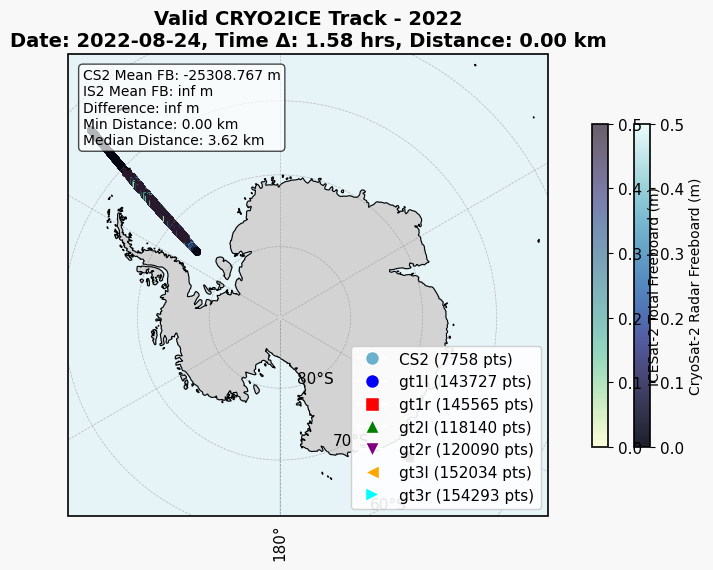

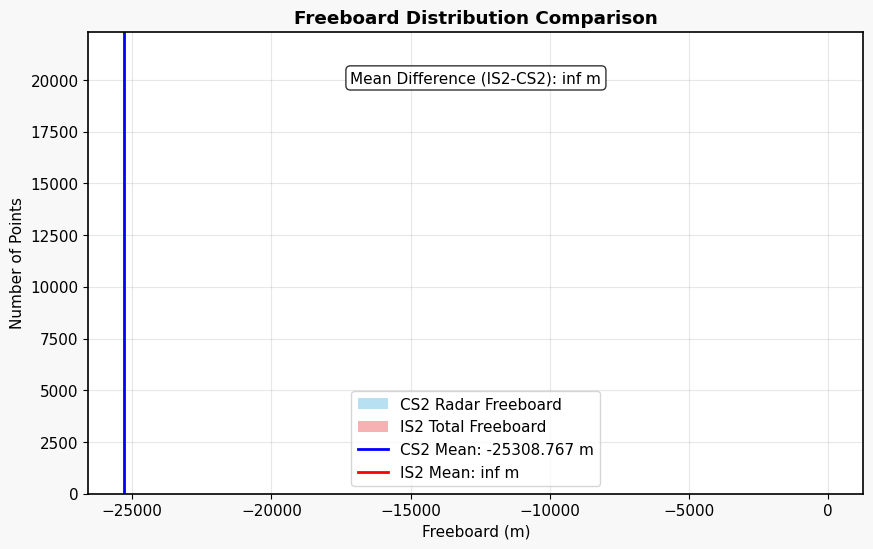

In [5]:
# Extract and analyze the spatially and temporally valid CRYO2ICE track
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import netCDF4 as nc
import h5py
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import time
from datetime import datetime
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# First, load the spatial statistics to identify the valid track
spatial_stats_path = os.path.join(base_dir, "output", "cryo2ice_spatial_analysis", "cryo2ice_spatial_stats.csv")
spatial_stats_df = pd.read_csv(spatial_stats_path)

# Find the track that meets both time and spatial criteria (within 10km)
valid_track = spatial_stats_df[spatial_stats_df['is_within_10km']]

print(f"Found {len(valid_track)} spatially valid track(s).")

if len(valid_track) == 0:
    print("No valid tracks found within 10km spatial constraint.")
else:
    # Sort by minimum distance to get the best match
    valid_track = valid_track.sort_values('min_distance_km').iloc[0]
    track_idx = int(valid_track['track_idx'])
    
    print(f"\n===== Valid CRYO2ICE Track Details =====")
    print(f"Track Index: {track_idx}")
    print(f"Year: {valid_track['year']}")
    print(f"Date: {valid_track['date']}")
    print(f"Time Delta: {valid_track['time_delta_hours']:.2f} hours")
    print(f"Minimum Distance: {valid_track['min_distance_km']:.2f} km")
    print(f"Median Distance: {valid_track['median_distance_km']:.2f} km")
    print(f"CryoSat-2 Mean Freeboard: {valid_track['cs2_mean_fb']:.3f} m")
    print(f"ICESat-2 Mean Freeboard: {valid_track['is2_mean_fb']:.3f} m")
    print(f"Freeboard Difference (IS2-CS2): {valid_track['fb_difference']:.3f} m")
    
    # Get the corresponding track data from weddell_valid_matches
    track = weddell_valid_matches.iloc[track_idx]
    
    # Output file paths for easy access
    cs2_file = os.path.join(base_dir, 
                          f"cs2_l2_sar_basel_e_weddell_winter/{track['year']}/{track['cs2_file']}")
    is2_file = os.path.join(base_dir, 
                          f"is2_atl10v6_weddell_winter/{track['year']}/{track['is2_file']}")
    
    print(f"\n===== File Paths =====")
    print(f"CryoSat-2 File: {cs2_file}")
    print(f"ICESat-2 File: {is2_file}")
    
    # Create output directory for this valid track
    valid_track_dir = os.path.join(base_dir, "output", "valid_cryo2ice_track")
    os.makedirs(valid_track_dir, exist_ok=True)
    
    print("\nLoading and processing track data...")
    
    # Load CryoSat-2 data with explicit copying to avoid read-only issues
    ds = nc.Dataset(cs2_file, 'r')
    freeboard_CS2 = np.array(ds.variables['radar_freeboard_20_ku'][:], copy=True)
    lat_CS2 = np.array(ds.variables['lat_poca_20_ku'][:], copy=True)
    lon_CS2 = np.array(ds.variables['lon_poca_20_ku'][:], copy=True)
    
    # Extract additional CS2 parameters if needed for your analysis
    time_CS2 = np.array(ds.variables['time_20_ku'][:], copy=True)
    
    # Get other potentially useful parameters - adjust based on your file structure
    try:
        sla_CS2 = np.array(ds.variables['sea_level_anomaly_20_ku'][:], copy=True)
    except:
        sla_CS2 = np.full_like(freeboard_CS2, np.nan)
        print("Sea level anomaly not available in CS2 file")
    
    try:
        ice_conc_CS2 = np.array(ds.variables['sea_ice_concentration_20_ku'][:], copy=True)
    except:
        ice_conc_CS2 = np.full_like(freeboard_CS2, np.nan)
        print("Sea ice concentration not available in CS2 file")
    
    # Close the CS2 dataset
    ds.close()
    
    print(f"Loaded CryoSat-2 data: {len(lat_CS2)} points")
    
    # Load ICESat-2 data
    file = h5py.File(is2_file, 'r')
    available_beams = [key for key in file.keys() if key.startswith('gt')]
    print(f"Available ICESat-2 beams: {available_beams}")
    
    # Dictionary to store all beam data
    beam_data = {}
    
    # Process each beam and store its data
    for beam in available_beams:
        try:
            # Create copies of arrays to avoid read-only issues
            lon_beam = np.array(file[f'{beam}/freeboard_segment/longitude'][:], copy=True)
            lat_beam = np.array(file[f'{beam}/freeboard_segment/latitude'][:], copy=True)
            freeboard_beam = np.array(file[f'{beam}/freeboard_segment/beam_fb_height'][:], copy=True)
            
            # Get additional parameters if available
            try:
                height_segment_beam = np.array(file[f'{beam}/freeboard_segment/height_segment_id'][:], copy=True)
                ssh_beam = np.array(file[f'{beam}/freeboard_segment/height_segment_ssh'][:], copy=True)
                ice_conc_beam = np.array(file[f'{beam}/freeboard_segment/ice_concentration'][:], copy=True)
            except:
                height_segment_beam = np.full_like(freeboard_beam, np.nan)
                ssh_beam = np.full_like(freeboard_beam, np.nan)
                ice_conc_beam = np.full_like(freeboard_beam, np.nan)
                print(f"Some parameters not available for beam {beam}")
            
            # Filter valid data points
            valid_mask = ~np.isnan(freeboard_beam) & (freeboard_beam > -999)
            valid_indices = np.where(valid_mask)[0]
            
            if len(valid_indices) > 0:
                beam_data[beam] = {
                    'lon': lon_beam[valid_indices],
                    'lat': lat_beam[valid_indices],
                    'freeboard': freeboard_beam[valid_indices],
                    'height_segment': height_segment_beam[valid_indices] if not np.all(np.isnan(height_segment_beam)) else None,
                    'ssh': ssh_beam[valid_indices] if not np.all(np.isnan(ssh_beam)) else None,
                    'ice_conc': ice_conc_beam[valid_indices] if not np.all(np.isnan(ice_conc_beam)) else None,
                    'count': len(valid_indices)
                }
                print(f"  {beam}: Found {len(valid_indices)} valid points, mean freeboard = {np.nanmean(freeboard_beam[valid_indices]):.3f} m")
            else:
                print(f"  {beam}: No valid data points")
        
        except Exception as e:
            print(f"  Error processing beam {beam}: {str(e)}")
            continue
    
    file.close()
    
    # Combine data from all beams for overall statistics
    all_lon_IS2 = []
    all_lat_IS2 = []
    all_freeboard_IS2 = []
    
    for beam, data in beam_data.items():
        all_lon_IS2.extend(data['lon'])
        all_lat_IS2.extend(data['lat'])
        all_freeboard_IS2.extend(data['freeboard'])
    
    # Convert lists to numpy arrays
    all_lon_IS2 = np.array(all_lon_IS2)
    all_lat_IS2 = np.array(all_lat_IS2)
    all_freeboard_IS2 = np.array(all_freeboard_IS2)
    
    print(f"Total ICESat-2 points from all beams: {len(all_lon_IS2)}")
    print(f"Mean ICESat-2 freeboard: {np.nanmean(all_freeboard_IS2):.3f} m")
    
    # Save extracted data to CSV files for further analysis
    # First, create DataFrames
    cs2_df = pd.DataFrame({
        'latitude': lat_CS2,
        'longitude': lon_CS2,
        'radar_freeboard': freeboard_CS2,
        'time': time_CS2,
        'sea_level_anomaly': sla_CS2 if not np.all(np.isnan(sla_CS2)) else np.nan,
        'ice_concentration': ice_conc_CS2 if not np.all(np.isnan(ice_conc_CS2)) else np.nan
    })
    
    # Save CS2 data
    cs2_output_path = os.path.join(valid_track_dir, "cs2_valid_track.csv")
    cs2_df.to_csv(cs2_output_path, index=False)
    print(f"CryoSat-2 data saved to: {cs2_output_path}")
    print(f"  From source file: {track['cs2_file']}")
    
    # Save IS2 data for each beam separately and combined
    for beam, data in beam_data.items():
        beam_df = pd.DataFrame({
            'latitude': data['lat'],
            'longitude': data['lon'],
            'total_freeboard': data['freeboard'],
            'height_segment': data['height_segment'] if data['height_segment'] is not None else np.nan,
            'ssh': data['ssh'] if data['ssh'] is not None else np.nan,
            'ice_concentration': data['ice_conc'] if data['ice_conc'] is not None else np.nan
        })
        
        beam_output_path = os.path.join(valid_track_dir, f"is2_{beam}_valid_track.csv")
        beam_df.to_csv(beam_output_path, index=False)
        print(f"ICESat-2 {beam} data saved to: {beam_output_path}")
    
    # Save combined IS2 data
    all_is2_df = pd.DataFrame({
        'latitude': all_lat_IS2,
        'longitude': all_lon_IS2,
        'total_freeboard': all_freeboard_IS2
    })
    
    all_is2_output_path = os.path.join(valid_track_dir, "is2_all_beams_valid_track.csv")
    all_is2_df.to_csv(all_is2_output_path, index=False)
    print(f"Combined ICESat-2 data saved to: {all_is2_output_path}")
    print(f"  From source file: {track['is2_file']}")
    
    # Create detailed visualisations of the valid track
    print("\nCreating visualisations...")
    
    # Calculate map bounds
    all_lons = np.concatenate([lon_CS2, all_lon_IS2])
    all_lats = np.concatenate([lat_CS2, all_lat_IS2])
    
    valid_idx = ~np.isnan(all_lons) & ~np.isnan(all_lats)
    all_lons = all_lons[valid_idx]
    all_lats = all_lats[valid_idx]
    
    buffer = 0.3  # degrees
    lon_min = np.min(all_lons) - buffer
    lon_max = np.max(all_lons) + buffer
    lat_min = np.min(all_lats) - buffer
    lat_max = np.max(all_lats) + buffer
    
    # Figure 1: Map with all beams colored differently
    fig = plt.figure(figsize=(10, 6))
    
    # Set up Antarctic polar stereographic projection
    projection = ccrs.SouthPolarStereo(central_longitude=0.0)
    ax = plt.axes(projection=projection)
    
    # Set map extent specific to this track's data coverage
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
    
    # Plot CS2 data
    sc1 = ax.scatter(lon_CS2, lat_CS2, c=freeboard_CS2, transform=ccrs.PlateCarree(), 
                    cmap=cmocean.cm.ice, s=30, alpha=0.9, edgecolor='none',
                    vmin=0, vmax=0.5, label='CryoSat-2 Radar Freeboard')
    
    # Add colorbar for CS2
    cbar1 = plt.colorbar(sc1, ax=ax, pad=0.01, fraction=0.046, shrink=0.7)
    cbar1.set_label('CryoSat-2 Radar Freeboard (m)', fontsize=10)
    
    # Plot each IS2 beam with different marker symbols and colors
    beam_markers = {'gt1l': 'o', 'gt1r': 's', 'gt2l': '^', 'gt2r': 'v', 'gt3l': '<', 'gt3r': '>'}
    beam_colors = {'gt1l': 'blue', 'gt1r': 'red', 'gt2l': 'green', 'gt2r': 'purple', 'gt3l': 'orange', 'gt3r': 'cyan'}
    beam_handles = []
    
    for beam, data in beam_data.items():
        marker = beam_markers.get(beam, 'o')
        color = beam_colors.get(beam, 'gray')
        
        # Plot each beam with a unique color
        sc = ax.scatter(data['lon'], data['lat'], c=data['freeboard'],
                       transform=ccrs.PlateCarree(),
                       cmap=cmocean.cm.deep, s=15, alpha=0.7, 
                       marker=marker, vmin=0, vmax=0.5)
        
        # Create legend handle
        beam_handles.append(Line2D([0], [0], marker=marker, color='w',
                                 markerfacecolor=beam_colors.get(beam, 'gray'), 
                                 markersize=10, label=f'{beam} ({data["count"]} pts)'))
    
    # Add colorbar for IS2 (using the last scatter plot)
    if beam_data:
        cbar2 = plt.colorbar(sc, ax=ax, pad=0.06, fraction=0.046, shrink=0.7)
        cbar2.set_label('ICESat-2 Total Freeboard (m)', fontsize=10)
    
    # Create legend
    cs2_handle = Line2D([0], [0], marker='o', color='w', 
                      markerfacecolor=cmocean.cm.ice(0.7), 
                      markersize=10, label=f'CS2 ({len(lat_CS2)} pts)')
    
    legend_handles = [cs2_handle] + beam_handles
    ax.legend(handles=legend_handles, loc='lower right', framealpha=0.9)
    
    # Add title
    plt.title(f'Valid CRYO2ICE Track - {track["year"]}\n' + 
             f'Date: {track["start_IS2_UTC"][:10]}, Time Δ: {valid_track["time_delta_hours"]:.2f} hrs, ' + 
             f'Distance: {valid_track["min_distance_km"]:.2f} km', 
             fontsize=14, fontweight='bold')
    
    # Add statistics text box
    stats_text = (
        f"CS2 Mean FB: {np.nanmean(freeboard_CS2):.3f} m\n"
        f"IS2 Mean FB: {np.nanmean(all_freeboard_IS2):.3f} m\n"
        f"Difference: {np.nanmean(all_freeboard_IS2) - np.nanmean(freeboard_CS2):.3f} m\n"
        f"Min Distance: {valid_track['min_distance_km']:.2f} km\n"
        f"Median Distance: {valid_track['median_distance_km']:.2f} km"
    )
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.03, 0.97, stats_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
    
    # Figure 2: Freeboard comparison histograms
    plt.figure(figsize=(10, 6))
    
    # Plot histograms of freeboard values
    bins = np.linspace(-0.1, 0.6, 36)  # -0.1 to 0.6m in 0.02m bins
    plt.hist(freeboard_CS2, bins=bins, alpha=0.6, label='CS2 Radar Freeboard', color='skyblue')
    plt.hist(all_freeboard_IS2, bins=bins, alpha=0.6, label='IS2 Total Freeboard', color='lightcoral')
    
    # Add vertical lines for means
    plt.axvline(np.nanmean(freeboard_CS2), color='blue', linestyle='-', linewidth=2,
               label=f'CS2 Mean: {np.nanmean(freeboard_CS2):.3f} m')
    plt.axvline(np.nanmean(all_freeboard_IS2), color='red', linestyle='-', linewidth=2,
               label=f'IS2 Mean: {np.nanmean(all_freeboard_IS2):.3f} m')
    
    # Add difference annotation
    diff = np.nanmean(all_freeboard_IS2) - np.nanmean(freeboard_CS2)
    plt.text(0.5, 0.9, f"Mean Difference (IS2-CS2): {diff:.3f} m",
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.xlabel('Freeboard (m)')
    plt.ylabel('Number of Points')
    plt.title('Freeboard Distribution Comparison', fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()
    
    print(f"\nProcessing complete! All data saved to: {valid_track_dir}")
    print("\nCSV file summary:")
    print(f"  CryoSat-2 track: {os.path.join(valid_track_dir, 'cs2_valid_track.csv')}")
    print(f"  ICESat-2 combined track: {os.path.join(valid_track_dir, 'is2_all_beams_valid_track.csv')}")
    print(f"  ICESat-2 individual beams: {', '.join([os.path.join(valid_track_dir, f'is2_{beam}_valid_track.csv') for beam in beam_data.keys()])}")
    
    # Show plots
    plt.show()

## Step 4: Implementing Quality Flag Processing for CryoSat-2 and ICESat-2 Data

### Step 4.1: Firstly, deal with the CryoSat-2 data

In [6]:
# First add the missing function for quality flag processing
def get_valid_freeboard_flag(flag):
    """
    Function to use the bitwise quality flag of CS2 L2 data
    Returns a flag value of 1 for valid measurements and 0 for invalid
    
    Parameters:
    flag: array of flag_prod_status_20_ku values from CryoSat-2 L2 data
    
    Returns:
    flag_valid_fb: array indicating valid (1) or invalid (0) freeboard measurements
    """
    # flags to look for - problematic conditions
    dict_error = {
        'calibration_warning'      : 1,
        'sarin_bad_velocity'       : 2,
        'sarin_out_of_range'       : 4,
        'sarin_bad_baseline'       : 8,
        'delta_time_error'         :32,
        'mispointing_error'        :64,
        'sarin_side_redundant'     :256,
        'sarin_rx_2_error'         :512,
        'sarin_rx_1_error'         :1024,
        'sarin_height_ambiguous'   :2048,
        'surf_type_class_ocean'    :32768,
        'freeboard_error'          :65536,
        'peakiness_error'          :131072,
        'ssha_interp_error'        :262144,
        'orbit_discontinuity'      :33554432,
        'orbit_error'              :67108864,
        'height_sea_ice_error'     :268435456,
    }
    
    # all flags provided in data product
    all_flag = {
        'calibration_warning'      : 1,
        'sarin_bad_velocity'       : 2,
        'sarin_out_of_range'       : 4,
        'sarin_bad_baseline'       : 8,
        'lrm_slope_model_invalid'  :16,
        'delta_time_error'         :32,
        'mispointing_error'        :64,
        'surface_model_unavailable':128,
        'sarin_side_redundant'     :256,
        'sarin_rx_2_error'         :512,
        'sarin_rx_1_error'         :1024,
        'sarin_height_ambiguous'   :2048,
        'surf_type_class_undefined':4096,
        'surf_type_class_sea_ice'  :8192,
        'surf_type_class_lead'     :16384,
        'surf_type_class_ocean'    :32768,
        'freeboard_error'          :65536,
        'peakiness_error'          :131072,
        'ssha_interp_error'        :262144,
        'sig0_3_error'             :524288,
        'sig0_2_error'             :1048576,
        'sig0_1_error'             :2097152,
        'height_3_error'           :4194304,
        'height_2_error'           :8388608,
        'height_1_error'           :16777216,
        'orbit_discontinuity'      :33554432,
        'orbit_error'              :67108864,
        'block_degraded'           :134217728,
        'height_sea_ice_error'     :268435456,
    }

    # sea ice class flag - check if the measurement is classified as sea ice
    flag_seaice = np.bitwise_and(flag, all_flag['surf_type_class_sea_ice'])/all_flag['surf_type_class_sea_ice']

    # errors identified - check if any error flags are active
    flag_error = np.zeros(flag.size)
    for key in dict_error.keys():
        flag0_error = np.bitwise_and(flag, dict_error[key])/dict_error[key]
        flag_error = np.logical_or(flag0_error, flag_error)

    # Final valid flag: sea ice classification without errors
    flag_valid_fb = flag_seaice - flag_error
    
    # observations where the flags were not active (set to 0 if negative)
    flag_valid_fb[flag_valid_fb < 0] = 0

    return flag_valid_fb

# Continue with your code, but now handle the extreme values in the freeboard data

# ==== PART 1: CryoSat-2 Quality Flag Processing ====
print("\n=== Processing CryoSat-2 Quality Flags ===")

# Load CryoSat-2 data
ds = nc.Dataset(cs2_file, 'r')
freeboard_CS2 = np.array(ds.variables['radar_freeboard_20_ku'][:], copy=True)
lat_CS2 = np.array(ds.variables['lat_poca_20_ku'][:], copy=True)
lon_CS2 = np.array(ds.variables['lon_poca_20_ku'][:], copy=True)
flag_CS2 = np.array(ds.variables['flag_prod_status_20_ku'][:], copy=True)

# Extract additional variables if available
try:
    peakiness_CS2 = np.array(ds.variables['peakiness_20_ku'][:], copy=True)
    print("  Peakiness parameter found and loaded")
except:
    peakiness_CS2 = np.full_like(freeboard_CS2, np.nan)
    print("  Peakiness parameter not available")

# Check for sea ice concentration with multiple possible variable names
sea_ice_conc_CS2 = None
# List of possible variable names for sea ice concentration
sic_var_names = ['sea_ice_concentration_20_ku', 'sea_ice_concentration', 
                'ice_concentration', 'SIC', 'sic', 'ice_conc', 'ice_conc_20_ku']

for var_name in sic_var_names:
    try:
        if var_name in ds.variables:
            sea_ice_conc_CS2 = np.array(ds.variables[var_name][:], copy=True)
            print(f"  Sea ice concentration found and loaded from variable: {var_name}")
            break
    except:
        continue

if sea_ice_conc_CS2 is None:
    sea_ice_conc_CS2 = np.full_like(freeboard_CS2, np.nan)
    print("  Sea ice concentration not available in any expected variable")

try:
    ssha_interp_CS2 = np.array(ds.variables['ssha_interp_20_ku'][:], copy=True)
    print("  Sea surface height anomaly found and loaded")
except:
    ssha_interp_CS2 = np.full_like(freeboard_CS2, np.nan)
    print("  Sea surface height anomaly not available")

# Close the dataset
ds.close()

# Handle fill values (the -32768 value is a common fill value)
# Replace extreme values with NaN
fill_value_mask = (freeboard_CS2 < -100) | (freeboard_CS2 > 100)
freeboard_CS2[fill_value_mask] = np.nan

# Report initial data statistics after handling fill values
print(f"  Total CryoSat-2 data points: {len(freeboard_CS2)}")
print(f"  Valid data points after removing fill values: {np.sum(~np.isnan(freeboard_CS2))}")
print(f"  Initial freeboard range: {np.nanmin(freeboard_CS2):.4f} to {np.nanmax(freeboard_CS2):.4f} m")
print(f"  Initial mean freeboard: {np.nanmean(freeboard_CS2):.4f} m")

# Apply get_valid_freeboard_flag function to identify valid measurements
valid_flag_CS2 = get_valid_freeboard_flag(flag_CS2)

# Create a comprehensive quality mask for CS2 data
# 1. Flag-based filtering (from the function)
# 2. Range-based filtering for physically plausible values
# 3. Additional constraints based on peakiness or other parameters if available
valid_CS2_mask = (valid_flag_CS2 == 1) & (~np.isnan(freeboard_CS2))

# Add physically reasonable constraints on freeboard values
# For radar freeboard: typically between -0.3 m (negative due to snow volume scattering) and 3 m
valid_CS2_mask = valid_CS2_mask & (freeboard_CS2 > -0.3) & (freeboard_CS2 < 3.0)

# If peakiness data is available, add peakiness constraints (typical values depend on surface type)
if not np.all(np.isnan(peakiness_CS2)):
    # Higher peakiness values indicate specular returns typical for leads (> 30-40)
    # Sea ice typically has peakiness values < 15-20
    # Avoiding extremes helps filter out anomalous data
    valid_CS2_mask = valid_CS2_mask & (peakiness_CS2 > 0) & (peakiness_CS2 < 100)

# Apply the mask to get quality-controlled data
lat_CS2_qc = lat_CS2[valid_CS2_mask]
lon_CS2_qc = lon_CS2[valid_CS2_mask]
freeboard_CS2_qc = freeboard_CS2[valid_CS2_mask]

# Report quality-controlled statistics
print(f"  Quality-controlled CryoSat-2 data points: {len(freeboard_CS2_qc)} ({len(freeboard_CS2_qc)/len(freeboard_CS2)*100:.1f}%)")
print(f"  QC freeboard range: {np.nanmin(freeboard_CS2_qc):.4f} to {np.nanmax(freeboard_CS2_qc):.4f} m")
print(f"  QC mean freeboard: {np.nanmean(freeboard_CS2_qc):.4f} m")
print(f"  Points removed by quality control: {len(freeboard_CS2) - len(freeboard_CS2_qc)}")


=== Processing CryoSat-2 Quality Flags ===
  Peakiness parameter found and loaded
  Sea ice concentration not available in any expected variable
  Sea surface height anomaly found and loaded
  Total CryoSat-2 data points: 7758
  Valid data points after removing fill values: 1766
  Initial freeboard range: -1.3600 to 8.3680 m
  Initial mean freeboard: 0.2483 m
  Quality-controlled CryoSat-2 data points: 1497 (19.3%)
  QC freeboard range: -0.2940 to 1.0660 m
  QC mean freeboard: 0.2409 m
  Points removed by quality control: 6261


### Step 4.2: Next, deal with the ICESat-2 dataset

In [7]:
def process_is2_atl10(is2_file_path):
    """
    Process ICESat-2 ATL10 data for CRYO2ICE analysis, applying quality flags
    and extracting valid freeboard measurements.
    
    Parameters:
    is2_file_path : str
        Path to the ICESat-2 ATL10 file
    
    Returns:
    dict : Dictionary containing processed data for each beam
    """
    import h5py
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    print(f"Processing ICESat-2 ATL10 file: {is2_file_path}")
    
    # Initialize dictionary to store processed data
    beam_data = {}
    
    # Open file for processing
    with h5py.File(is2_file_path, 'r') as f:
        # Check spacecraft orientation
        orientation_flag = f['orbit_info/sc_orient'][:]
        if orientation_flag == 0:
            print('Backward orientation')
            beams = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
        elif orientation_flag == 1:
            print('Forward orientation')
            beams = ['gt3r', 'gt3l', 'gt2r', 'gt2l', 'gt1r', 'gt1l']
        else:
            print(f'Orientation flag: {orientation_flag}, using default beam order')
            beams = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
        
        # Process each beam
        print("\nProcessing each beam:")
        for beam in beams:
            if beam not in f:
                continue
                
            print(f"\n  === Processing {beam} ===")
            
            # Check if freeboard_segment exists
            if 'freeboard_segment' not in f[beam]:
                print(f"  {beam}: No freeboard_segment found, skipping")
                continue
                
            # Initialize container for this beam's data
            beam_data[beam] = {}
            
            try:
                # Load coordinates and basic freeboard data with explicit copying
                beam_data[beam]['latitude'] = np.array(f[f'{beam}/freeboard_segment/latitude'][:], copy=True)
                beam_data[beam]['longitude'] = np.array(f[f'{beam}/freeboard_segment/longitude'][:], copy=True)
                beam_data[beam]['freeboard'] = np.array(f[f'{beam}/freeboard_segment/beam_fb_height'][:], copy=True)
                
                # Replace infinity values with NaN
                beam_data[beam]['freeboard'] = np.nan_to_num(beam_data[beam]['freeboard'], nan=np.nan, posinf=np.nan, neginf=np.nan)
                
                # Load quality metrics
                try:
                    beam_data[beam]['quality_flag'] = np.array(f[f'{beam}/freeboard_segment/beam_fb_quality_flag'][:], copy=True)
                    print(f"  Quality flag values found: {np.unique(beam_data[beam]['quality_flag'])}")
                except:
                    beam_data[beam]['quality_flag'] = np.ones_like(beam_data[beam]['freeboard'])
                    print("  Quality flag not found, assuming all values are quality=1")
                
                try:
                    beam_data[beam]['confidence'] = np.array(f[f'{beam}/freeboard_segment/beam_fb_confidence'][:], copy=True)
                    valid_conf = ~np.isnan(beam_data[beam]['confidence'])
                    if np.any(valid_conf):
                        print(f"  Confidence value range: {np.nanmin(beam_data[beam]['confidence']):.6f} to {np.nanmax(beam_data[beam]['confidence']):.6f}")
                except:
                    beam_data[beam]['confidence'] = np.ones_like(beam_data[beam]['freeboard'])
                    print("  Confidence not found, assuming uniform confidence")
                    
                try:
                    beam_data[beam]['uncertainty'] = np.array(f[f'{beam}/freeboard_segment/beam_fb_unc'][:], copy=True)
                except:
                    beam_data[beam]['uncertainty'] = np.ones_like(beam_data[beam]['freeboard'])
                    print("  Uncertainty not found")
                
                # Create initial mask for valid data
                # Filter NaN, inf, and unreasonable values (-9999 is a common fill value)
                nan_mask = ~np.isnan(beam_data[beam]['freeboard'])
                inf_mask = ~np.isinf(beam_data[beam]['freeboard'])
                fill_value_mask = beam_data[beam]['freeboard'] > -999
                
                # Combine basic masks
                basic_mask = nan_mask & inf_mask & fill_value_mask
                
                # Apply quality flag filtering (quality=1 appears to be best quality based on outputs)
                qual_mask = beam_data[beam]['quality_flag'] == 1
                
                # Apply physically reasonable constraints (freeboard typically -0.5 to 3 meters)
                physical_mask = (beam_data[beam]['freeboard'] > -0.5) & (beam_data[beam]['freeboard'] < 3.0)
                
                # Combine all masks
                valid_mask = basic_mask & qual_mask & physical_mask
                
                # Store the valid mask
                beam_data[beam]['valid_mask'] = valid_mask
                
                # Count valid points
                n_valid = np.sum(valid_mask)
                n_total = len(valid_mask)
                valid_pct = (n_valid/n_total*100) if n_total > 0 else 0
                print(f"  Valid points after filtering: {n_valid} out of {n_total} ({valid_pct:.1f}%)")
                
                # Basic statistics on filtered data
                if n_valid > 0:
                    valid_fb = beam_data[beam]['freeboard'][valid_mask]
                    beam_data[beam]['mean_freeboard'] = np.mean(valid_fb)
                    beam_data[beam]['min_freeboard'] = np.min(valid_fb)
                    beam_data[beam]['max_freeboard'] = np.max(valid_fb)
                    print(f"  Valid freeboard range: {beam_data[beam]['min_freeboard']:.4f} to {beam_data[beam]['max_freeboard']:.4f} m")
                    print(f"  Valid freeboard mean: {beam_data[beam]['mean_freeboard']:.4f} m")
                else:
                    print("  No valid data points after filtering")
                    beam_data[beam]['mean_freeboard'] = np.nan
                
                # Store valid coordinates and data for easy access
                beam_data[beam]['valid_lats'] = beam_data[beam]['latitude'][valid_mask] if n_valid > 0 else np.array([])
                beam_data[beam]['valid_lons'] = beam_data[beam]['longitude'][valid_mask] if n_valid > 0 else np.array([])
                beam_data[beam]['valid_freeboard'] = beam_data[beam]['freeboard'][valid_mask] if n_valid > 0 else np.array([])
                
            except Exception as e:
                print(f"  Error processing {beam}: {str(e)}")
                continue
    
    # Create combined datasets from all valid beams
    all_lats = []
    all_lons = []
    all_fbs = []
    
    for beam, data in beam_data.items():
        if 'valid_freeboard' in data and len(data['valid_freeboard']) > 0:
            all_lats.extend(data['valid_lats'])
            all_lons.extend(data['valid_lons'])
            all_fbs.extend(data['valid_freeboard'])
    
    if all_lats:
        beam_data['combined'] = {
            'latitude': np.array(all_lats),
            'longitude': np.array(all_lons),
            'freeboard': np.array(all_fbs),
            'count': len(all_lats),
            'mean_freeboard': np.mean(all_fbs) if all_fbs else np.nan
        }
        
        print(f"\nCombined valid data from all beams:")
        print(f"  Total points: {beam_data['combined']['count']}")
        print(f"  Mean freeboard: {beam_data['combined']['mean_freeboard']:.4f} m")
    else:
        print("\nNo valid data points found in any beam.")
    
    return beam_data

In [8]:
# Execute function on the ICESat-2 file
beam_data = process_is2_atl10(is2_file)  # Changed from is2_file_path to is2_file

Processing ICESat-2 ATL10 file: D:\phd\data\chap2\is2_atl10v6_weddell_winter/2022/ATL10-02_20220824100427_09701601_006_01.h5
Forward orientation

Processing each beam:

  === Processing gt3r ===
  Quality flag values found: [1 2 3 4]
  Confidence value range: 0.005407 to 0.116338
  Valid points after filtering: 139143 out of 154293 (90.2%)
  Valid freeboard range: 0.0000 to 2.9508 m
  Valid freeboard mean: 0.5062 m

  === Processing gt3l ===
  Quality flag values found: [1 2 3 4]
  Confidence value range: 0.005103 to 0.125075
  Valid points after filtering: 114805 out of 152034 (75.5%)
  Valid freeboard range: 0.0000 to 2.9814 m
  Valid freeboard mean: 0.4795 m

  === Processing gt2r ===
  Quality flag values found: [1 2 3 4]
  Confidence value range: 0.005310 to 0.165891
  Valid points after filtering: 112146 out of 120090 (93.4%)
  Valid freeboard range: 0.0000 to 2.4919 m
  Valid freeboard mean: 0.4943 m

  === Processing gt2l ===
  Quality flag values found: [1 2 3 4]
  Confidence 

### Step 4.3: Implementing CryoSat-2 and ICESat-2 Data Integration for Snow Thickness Estimation

Loading and processing CRYO2ICE data with 3500m search radius
CryoSat-2 quality-controlled points: 1497 (19.3%)
Processing ICESat-2 ATL10 file: D:\phd\data\chap2\is2_atl10v6_weddell_winter/2022/ATL10-02_20220824100427_09701601_006_01.h5
Forward orientation

Processing each beam:

  === Processing gt3r ===
  Quality flag values found: [1 2 3 4]
  Confidence value range: 0.005407 to 0.116338
  Valid points after filtering: 139143 out of 154293 (90.2%)
  Valid freeboard range: 0.0000 to 2.9508 m
  Valid freeboard mean: 0.5062 m

  === Processing gt3l ===
  Quality flag values found: [1 2 3 4]
  Confidence value range: 0.005103 to 0.125075
  Valid points after filtering: 114805 out of 152034 (75.5%)
  Valid freeboard range: 0.0000 to 2.9814 m
  Valid freeboard mean: 0.4795 m

  === Processing gt2r ===
  Quality flag values found: [1 2 3 4]
  Confidence value range: 0.005310 to 0.165891
  Valid points after filtering: 112146 out of 120090 (93.4%)
  Valid freeboard range: 0.0000 to 2.4919 m


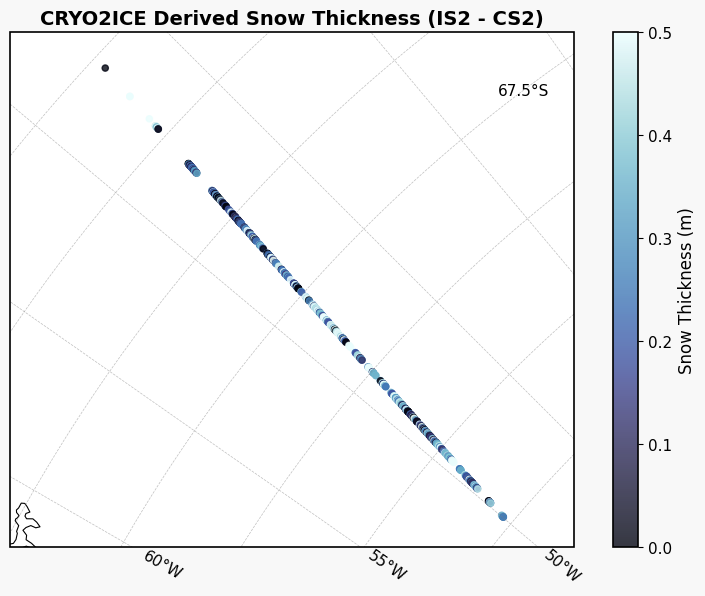

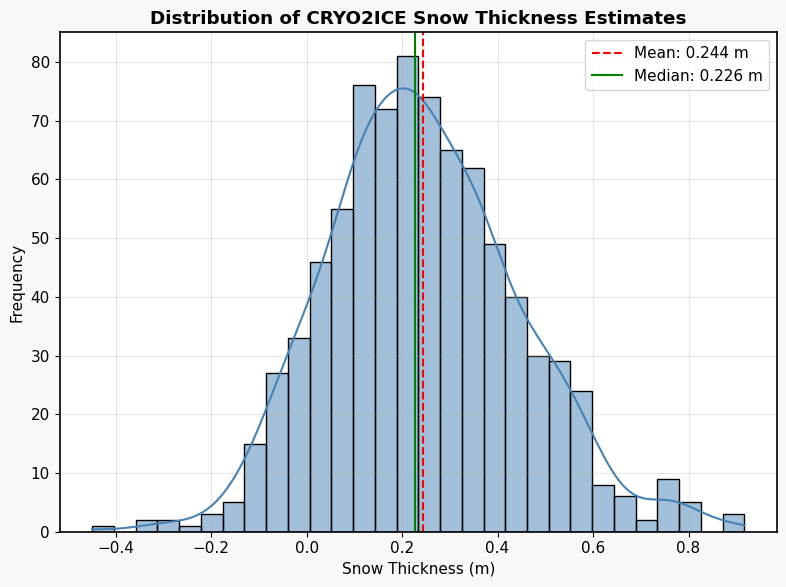

In [9]:
def numpy_nan_mean(a):
    """Helper function to calculate mean with nan values"""
    return np.nan if np.all(np.isnan(a)) else np.nanmean(a)

def CRYO2ICE_smooth_CS2_data(df_CS2, dist_req):
    """
    Apply spatial smoothing to CryoSat-2 data using a search radius
    
    Parameters:
    df_CS2 : DataFrame - CryoSat-2 data with lat, lon, fb columns
    dist_req : float - Search radius in meters
    
    Returns:
    DataFrame - Smoothed CryoSat-2 data
    """
    from sklearn.neighbors import BallTree
    
    # Extract lat/lon for spatial search
    query_lats = df_CS2[['lat']].to_numpy()
    query_lons = df_CS2[['lon']].to_numpy()

    # Create a BallTree for efficient spatial search
    tree = BallTree(np.deg2rad(df_CS2[['lat', 'lon']].values), metric='haversine')

    # Convert distance to radians
    earth_radius_in_metres = 6371*1000
    radius = dist_req/earth_radius_in_metres

    # Perform radius search
    is_within, distances = tree.query_radius(
        np.deg2rad(np.c_[query_lats, query_lons]), 
        r=radius, count_only=False, return_distance=True
    ) 
    distances_in_metres = distances*earth_radius_in_metres

    # Calculate smoothed freeboard values
    smooth_CS2 = np.empty(len(query_lats))
    k = 0
    for i in is_within:
        data_fb_mean = df_CS2['fb'].iloc[i]
        smooth_CS2[k] = numpy_nan_mean(data_fb_mean)
        k = k+1
    
    df_CS2_new = pd.DataFrame({'CS2_smooth': smooth_CS2})
    
    return df_CS2_new

def CRYO2ICE_identify_IS2_data2(df_CS2, df_IS2, dist_req):
    """
    Identify IS2 data points that are within the specified distance of CS2 points
    and calculate various statistics
    
    Parameters:
    df_CS2 : DataFrame - CryoSat-2 data
    df_IS2 : DataFrame - ICESat-2 data
    dist_req : float - Search radius in meters
    
    Returns:
    DataFrame - Statistics of IS2 data within radius of each CS2 point
    """
    from sklearn.neighbors import BallTree

    # Extract CS2 coordinates for querying
    query_lats = df_CS2[['lat']].to_numpy()
    query_lons = df_CS2[['lon']].to_numpy()

    # Create BallTree for spatial search of IS2 data
    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), metric='haversine')

    # Convert distance to radians
    earth_radius_in_metres = 6371*1000
    radius = dist_req/earth_radius_in_metres

    # Find all IS2 points within radius of each CS2 point
    is_within, distances = tree.query_radius(
        np.deg2rad(np.c_[query_lats, query_lons]), 
        r=radius, count_only=False, return_distance=True
    )
    distances_in_metres = distances*earth_radius_in_metres

    # Initialize arrays for statistics
    mean_fb_IS2 = np.empty(len(query_lats))
    w_mean_fb_IS2 = np.empty(len(query_lats))
    
    # We'll only use freeboard in this version
    # (the original code also used gaussian width and mean sea surface)
    dist_std_all = np.empty(len(query_lats))
    dist_avg_all = np.empty(len(query_lats))
    dist_min_all = np.empty(len(query_lats))
    dist_max_all = np.empty(len(query_lats))
    
    # Count IS2 points by beam
    GT1L = np.empty(len(query_lats))
    GT2L = np.empty(len(query_lats))
    GT3L = np.empty(len(query_lats))
    GT1R = np.empty(len(query_lats))
    GT2R = np.empty(len(query_lats))
    GT3R = np.empty(len(query_lats))
    
    k = 0
    
    # Process each CS2 point
    for i in is_within:
        GT1L_count, GT2L_count, GT3L_count = 0, 0, 0
        GT1R_count, GT2R_count, GT3R_count = 0, 0, 0
        
        # Check if we have enough IS2 points for statistics
        if len(i) > 10:
            # Extract IS2 freeboard and beam IDs for this CS2 point
            data_fb_mean_IS2 = df_IS2['fb'].iloc[i]
            
            # Calculate beam IDs if available
            if 'beam_ID' in df_IS2:
                beam_ID_all = df_IS2['beam_ID'].iloc[i]
                
                # Count points by beam
                for j in beam_ID_all:
                    if j == 1:
                        GT1L_count += 1
                    elif j == 2:
                        GT2L_count += 1
                    elif j == 3:
                        GT3L_count += 1
                    elif j == 4:
                        GT1R_count += 1
                    elif j == 5:
                        GT2R_count += 1
                    elif j == 6:
                        GT3R_count += 1
            
            # Calculate statistics
            mean_fb_val = np.nanmean(data_fb_mean_IS2)
            
            # Weighted mean using inverse distance weighting
            w_mean_fb_val = np.ma.average(data_fb_mean_IS2, weights=(1/distances_in_metres[k]))
            
            # Distance statistics
            dist_min = np.nanmin(distances_in_metres[k])
            dist_max = np.nanmax(distances_in_metres[k])
            dist_avg = np.nanmean(distances_in_metres[k])
            dist_std = np.nanstd(distances_in_metres[k])
        else:
            # Not enough points for statistics
            mean_fb_val = np.nan
            w_mean_fb_val = np.nan
            dist_min = np.nan
            dist_max = np.nan
            dist_avg = np.nan
            dist_std = np.nan
        
        # Store values in arrays
        mean_fb_IS2[k] = mean_fb_val
        w_mean_fb_IS2[k] = w_mean_fb_val
        dist_avg_all[k] = dist_avg
        dist_min_all[k] = dist_min
        dist_max_all[k] = dist_max
        dist_std_all[k] = dist_std
        
        GT1R[k] = GT1R_count
        GT2R[k] = GT2R_count
        GT3R[k] = GT3R_count
        GT1L[k] = GT1L_count
        GT2L[k] = GT2L_count
        GT3L[k] = GT3L_count
        
        k = k+1
    
    # Create a DataFrame with statistics for each CS2 point
    df_IS2_new = pd.DataFrame({
        'IS2_mean_fb': mean_fb_IS2, 
        'IS2_w_mean_fb': w_mean_fb_IS2,
        'IS2_dist_min': dist_min_all,
        'IS2_dist_max': dist_max_all, 
        'IS2_dist_avg': dist_avg_all, 
        'IS2_dist_std': dist_std_all, 
        'GT1L_count': GT1L, 
        'GT2L_count': GT2L, 
        'GT3L_count': GT3L,
        'GT1R_count': GT1R, 
        'GT2R_count': GT2R, 
        'GT3R_count': GT3R
    })
    
    return df_IS2_new

def load_cryo2ice_data(cs2_file, is2_file, dist_req=3500):
    '''
    Load CryoSat-2 and ICESat-2 data using quality-controlled datasets
    and integrate them for snow thickness estimation.
    
    Parameters:
    cs2_file : str - Path to CryoSat-2 L2 file
    is2_file : str - Path to ICESat-2 ATL10 file
    dist_req : float - Search radius in meters (default: 3500m)
    
    Returns:
    dict - Dictionary containing integrated data with the following keys:
        'cs2_data' : DataFrame with CryoSat-2 data
        'is2_data' : Dictionary with beam-specific and combined ICESat-2 data
        'integrated' : DataFrame with collocated CS2-IS2 data for snow thickness estimation
    '''
    print(f"Loading and processing CRYO2ICE data with {dist_req}m search radius")
    
    # ===== 1. Load and process CryoSat-2 data =====
    ds = nc.Dataset(cs2_file, 'r')
    freeboard_CS2 = np.array(ds.variables['radar_freeboard_20_ku'][:], copy=True)
    lat_CS2 = np.array(ds.variables['lat_poca_20_ku'][:], copy=True)
    lon_CS2 = np.array(ds.variables['lon_poca_20_ku'][:], copy=True)
    flag_CS2 = np.array(ds.variables['flag_prod_status_20_ku'][:], copy=True)
    
    try:
        time_CS2 = np.array(ds.variables['time_20_ku'][:], copy=True)
    except:
        # If time is not available, use index as a placeholder
        time_CS2 = np.arange(len(lat_CS2))
        print("Time variable not found in CS2 file, using index as placeholder")
    
    # Apply quality flag function
    valid_flag_CS2 = get_valid_freeboard_flag(flag_CS2)
    
    # Apply comprehensive quality mask
    valid_CS2_mask = (valid_flag_CS2 == 1) & (~np.isnan(freeboard_CS2))
    # Add physically reasonable constraints
    valid_CS2_mask = valid_CS2_mask & (freeboard_CS2 > -0.3) & (freeboard_CS2 < 3.0)
    
    # Apply the mask to get quality-controlled data
    lat_CS2_qc = lat_CS2[valid_CS2_mask]
    lon_CS2_qc = lon_CS2[valid_CS2_mask]
    freeboard_CS2_qc = freeboard_CS2[valid_CS2_mask]
    time_CS2_qc = time_CS2[valid_CS2_mask]
    
    # Create CS2 DataFrame
    df_CS2 = pd.DataFrame({
        'lat': lat_CS2_qc,
        'lon': lon_CS2_qc,
        'fb': freeboard_CS2_qc,
        'time': time_CS2_qc
    })
    
    print(f"CryoSat-2 quality-controlled points: {len(df_CS2)} ({len(df_CS2)/len(freeboard_CS2)*100:.1f}%)")
    ds.close()
    
    # ===== 2. Load and process ICESat-2 data =====
    # Process ATL10 file with our quality flag processing function
    beam_data = process_is2_atl10(is2_file)
    
    # Create ICESat-2 DataFrame with all valid data points
    if 'combined' in beam_data:
        df_IS2 = pd.DataFrame({
            'lat': beam_data['combined']['latitude'],
            'lon': beam_data['combined']['longitude'],
            'fb': beam_data['combined']['freeboard']
        })
        
        # Add beam ID column
        beam_ids = []
        for beam in ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']:
            if beam in beam_data:
                beam_id = {'gt1l': 1, 'gt1r': 2, 'gt2l': 3, 'gt2r': 4, 'gt3l': 5, 'gt3r': 6}[beam]
                for _ in range(len(beam_data[beam]['valid_lats'])):
                    beam_ids.append(beam_id)
        
        df_IS2['beam_ID'] = beam_ids
    else:
        # Create empty DataFrame if no valid data
        df_IS2 = pd.DataFrame(columns=['lat', 'lon', 'fb', 'beam_ID'])
        print("No valid ICESat-2 data found")
    
    print(f"ICESat-2 quality-controlled points: {len(df_IS2)}")
    
    # ===== 3. Apply CS2 smoothing =====
    if len(df_CS2) > 0:
        df_CS2_smooth = CRYO2ICE_smooth_CS2_data(df_CS2, dist_req)
        df_CS2 = pd.concat([df_CS2, df_CS2_smooth], axis=1)
    
    # ===== 4. Identify collocated IS2 data =====
    if len(df_CS2) > 0 and len(df_IS2) > 0:
        print("Identifying collocated IS2 data points within search radius...")
        df_IS2_stats = CRYO2ICE_identify_IS2_data2(df_CS2, df_IS2, dist_req)
        
        # Combine CS2 and IS2 data
        data_combined = pd.concat([df_CS2, df_IS2_stats], axis=1)
        
        # Drop rows with NaN values (no collocated data)
        data_combined_clean = data_combined.dropna()
        
        print(f"Found {len(data_combined_clean)} valid collocated CS2-IS2 data points")
        
        # Calculate snow thickness estimate (IS2 total freeboard - CS2 radar freeboard)
        if len(data_combined_clean) > 0:
            data_combined_clean['snow_thickness'] = data_combined_clean['IS2_mean_fb'] - data_combined_clean['fb']
            data_combined_clean['w_snow_thickness'] = data_combined_clean['IS2_w_mean_fb'] - data_combined_clean['fb']
            
            print(f"Mean snow thickness estimate: {data_combined_clean['snow_thickness'].mean():.3f} m")
            print(f"Weighted mean snow thickness estimate: {data_combined_clean['w_snow_thickness'].mean():.3f} m")
        
        return {
            'cs2_data': df_CS2,
            'is2_data': beam_data,
            'integrated': data_combined_clean
        }
    else:
        print("Insufficient data for integration - either CS2 or IS2 data is missing")
        return {
            'cs2_data': df_CS2,
            'is2_data': beam_data,
            'integrated': pd.DataFrame()
        }

# Execute the function on our valid CRYO2ICE track
# Use 3500 m as the search radius (can be adjusted as needed)
cryo2ice_data = load_cryo2ice_data(cs2_file, is2_file, dist_req=3500)

# Create summary of collocated data
if not cryo2ice_data['integrated'].empty:
    # Calculate basic statistics
    snow_stats = cryo2ice_data['integrated']['snow_thickness'].describe()
    print("\n===== Snow Thickness Statistics (meters) =====")
    print(f"Mean: {snow_stats['mean']:.4f}")
    print(f"Std Dev: {snow_stats['std']:.4f}")
    print(f"Min: {snow_stats['min']:.4f}")
    print(f"25%: {snow_stats['25%']:.4f}")
    print(f"Median: {snow_stats['50%']:.4f}")
    print(f"75%: {snow_stats['75%']:.4f}")
    print(f"Max: {snow_stats['max']:.4f}")
    
    # Create visualisation of snow thickness results
    plt.figure(figsize=(8, 6))
    
    # Set up Antarctic polar stereographic projection
    projection = ccrs.SouthPolarStereo(central_longitude=0.0)
    ax = plt.axes(projection=projection)
    
    # Calculate map bounds
    min_lon = cryo2ice_data['integrated']['lon'].min() - 0.5
    max_lon = cryo2ice_data['integrated']['lon'].max() + 0.5
    min_lat = cryo2ice_data['integrated']['lat'].min() - 0.5
    max_lat = cryo2ice_data['integrated']['lat'].max() + 0.5
    
    # Set map extent
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Plot snow thickness
    sc = ax.scatter(cryo2ice_data['integrated']['lon'], 
                   cryo2ice_data['integrated']['lat'],
                   c=cryo2ice_data['integrated']['snow_thickness'], 
                   transform=ccrs.PlateCarree(),
                   cmap='cmo.ice', s=20, alpha=0.8,
                   vmin=0, vmax=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Snow Thickness (m)', fontsize=12)
    
    # Add title
    plt.title('CRYO2ICE Derived Snow Thickness (IS2 - CS2)', fontsize=14, fontweight='bold')
    
    # Save and display
    plt.tight_layout()
    plt.savefig(os.path.join(valid_track_dir, 'cryo2ice_snow_thickness_map.png'), dpi=600, bbox_inches='tight')
    plt.show()
    
    # Create histogram of snow thickness distribution
    plt.figure(figsize=(8, 6))
    sns.histplot(cryo2ice_data['integrated']['snow_thickness'], bins=30, kde=True, color='steelblue')
    plt.axvline(snow_stats['mean'], color='red', linestyle='--', label=f'Mean: {snow_stats["mean"]:.3f} m')
    plt.axvline(snow_stats['50%'], color='green', linestyle='-', label=f'Median: {snow_stats["50%"]:.3f} m')
    plt.xlabel('Snow Thickness (m)')
    plt.ylabel('Frequency')
    plt.title('Distribution of CRYO2ICE Snow Thickness Estimates', fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(valid_track_dir, 'cryo2ice_snow_thickness_histogram.png'), dpi=600, bbox_inches='tight')
    plt.show()
else:
    print("No collocated data available for snow thickness estimation")

## Step 5: CRYO2ICE Weddell Sector Summary Figure - Distance, Time-lag, and Spatial Distribution Analysis (2021-2024)

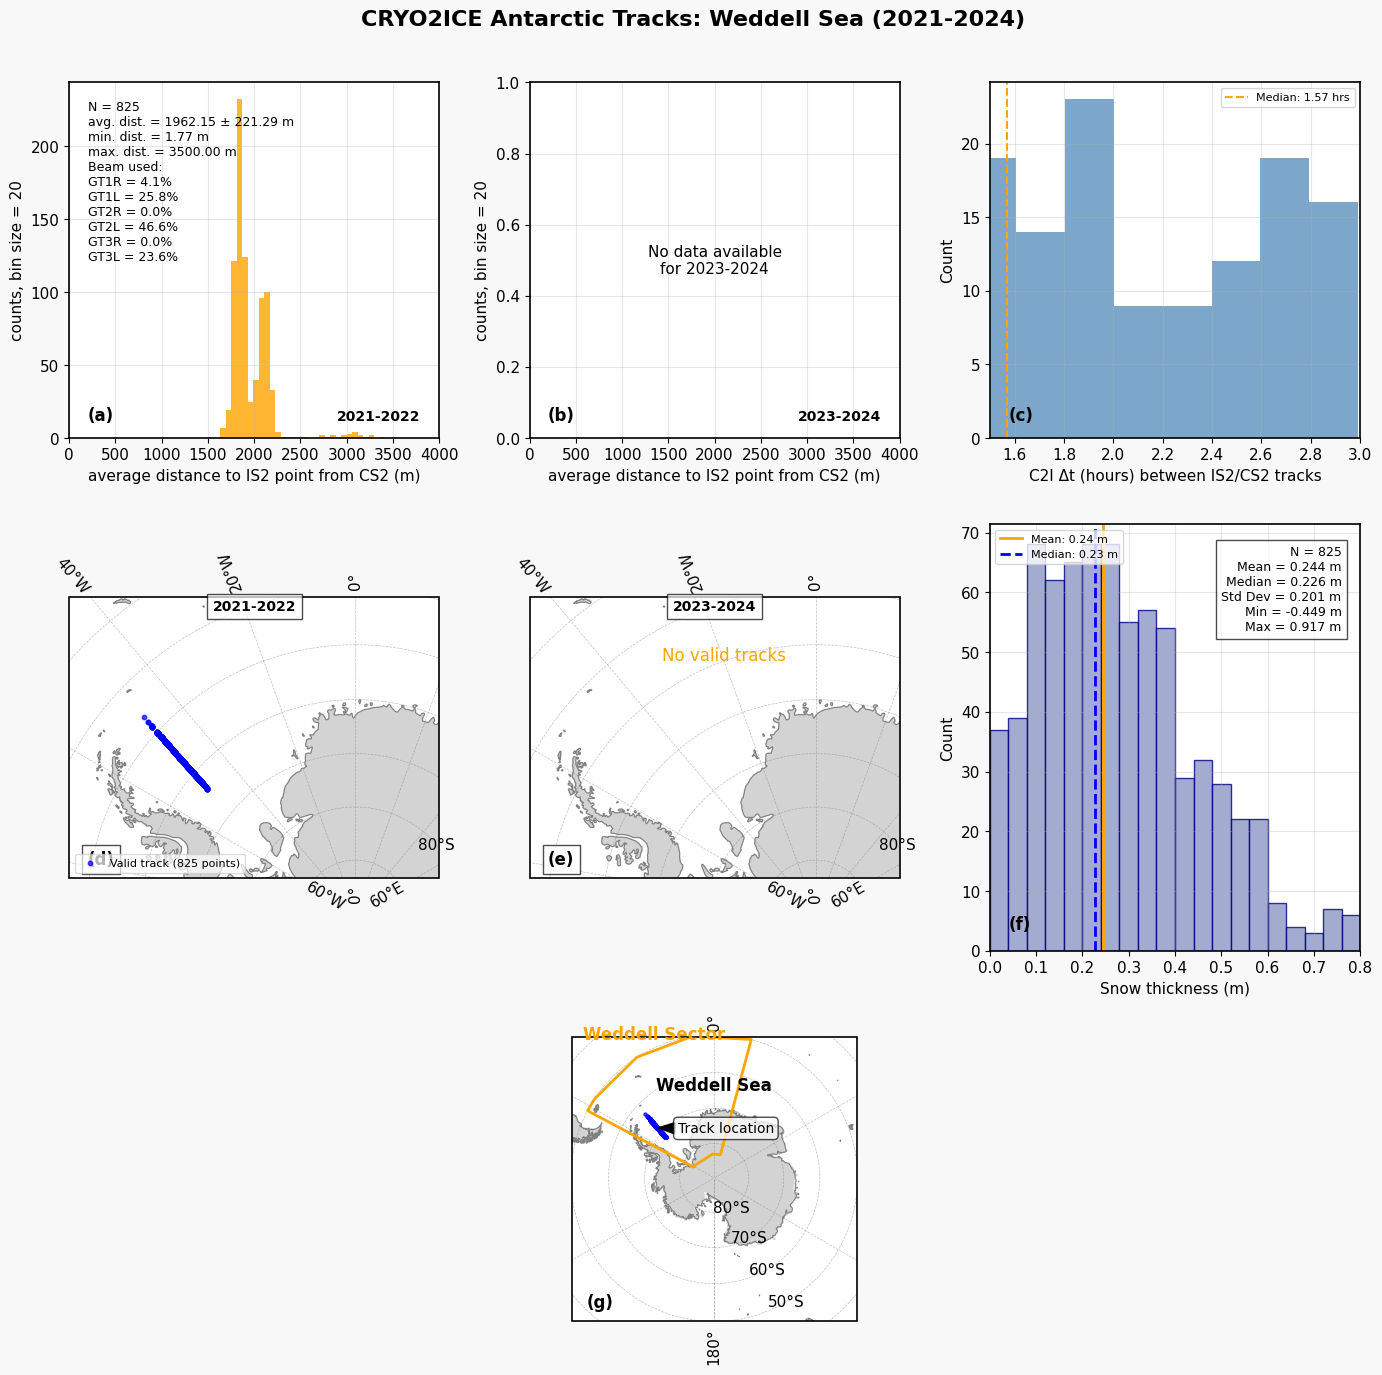

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from datetime import datetime
import os

# Set up the figure with multiple panels including a new panel for Antarctic overview
fig = plt.figure(figsize=(14, 14))
# Updated gridspec to include a third row for the Antarctic overview panel
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1.2, 0.8])

# ===== Panel (a): Distance histogram for our valid track =====
ax1 = plt.subplot(gs[0, 0])

# Since we only have one valid track, we'll use all the data rather than filtering by year
if not cryo2ice_data['integrated'].empty:
    # Create distance histogram - changed color from indianred to orange
    ax1.hist(cryo2ice_data['integrated']['IS2_dist_avg'], bins=30, color='orange', alpha=0.8)
    
    # Calculate statistics
    N = len(cryo2ice_data['integrated'])
    avg_dist = cryo2ice_data['integrated']['IS2_dist_avg'].mean()
    min_dist = cryo2ice_data['integrated']['IS2_dist_min'].min()
    max_dist = cryo2ice_data['integrated']['IS2_dist_max'].max()
    std_dist = cryo2ice_data['integrated']['IS2_dist_avg'].std()
    
    # Add statistics text
    stats_text = f"N = {N}\navg. dist. = {avg_dist:.2f} ± {std_dist:.2f} m\n"
    stats_text += f"min. dist. = {min_dist:.2f} m\nmax. dist. = {max_dist:.2f} m"
    
    # Add beam usage stats if available
    if 'GT1L_count' in cryo2ice_data['integrated'].columns:
        beam_text = "Beam used:\n"
        total_beam_points = cryo2ice_data['integrated'][['GT1L_count', 'GT1R_count', 'GT2L_count', 
                                       'GT2R_count', 'GT3L_count', 'GT3R_count']].sum().sum()
        
        if total_beam_points > 0:
            for beam, col in zip(['GT1R', 'GT1L', 'GT2R', 'GT2L', 'GT3R', 'GT3L'], 
                               ['GT1R_count', 'GT1L_count', 'GT2R_count', 'GT2L_count', 'GT3R_count', 'GT3L_count']):
                pct = cryo2ice_data['integrated'][col].sum() / total_beam_points * 100
                beam_text += f"{beam} = {pct:.1f}%\n"
            
            stats_text += "\n" + beam_text
    
    ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes, 
            verticalalignment='top', fontsize=9)
else:
    ax1.text(0.5, 0.5, 'No valid CRYO2ICE\ntrack data available', 
            transform=ax1.transAxes, ha='center', va='center')

ax1.set_xlabel('average distance to IS2 point from CS2 (m)')
ax1.set_ylabel('counts, bin size = 20')
ax1.set_xlim(0, 4000)
ax1.text(0.95, 0.05, '2021-2022', transform=ax1.transAxes, 
        horizontalalignment='right', fontsize=10, fontweight='bold')
ax1.text(0.05, 0.05, '(a)', transform=ax1.transAxes, fontsize=12, fontweight='bold')

# ===== Panel (b): Empty or alternate content since we don't have 2023-2024 data =====
ax2 = plt.subplot(gs[0, 1])
ax2.text(0.5, 0.5, 'No data available\nfor 2023-2024', 
        transform=ax2.transAxes, ha='center', va='center')
ax2.set_xlabel('average distance to IS2 point from CS2 (m)')
ax2.set_ylabel('counts, bin size = 20')
ax2.set_xlim(0, 4000)
ax2.text(0.95, 0.05, '2023-2024', transform=ax2.transAxes, 
        horizontalalignment='right', fontsize=10, fontweight='bold')
ax2.text(0.05, 0.05, '(b)', transform=ax2.transAxes, fontsize=12, fontweight='bold')

# ===== Panel (c): Time difference histogram =====
ax3 = plt.subplot(gs[0, 2])

# Load spatial stats from earlier analysis if available
spatial_stats_path = os.path.join(base_dir, "output", "cryo2ice_spatial_analysis", "cryo2ice_spatial_stats.csv")
if os.path.exists(spatial_stats_path):
    spatial_stats_df = pd.read_csv(spatial_stats_path)
    
    # Create histogram of time differences - changed from steelblue to a darker blue
    ax3.hist(spatial_stats_df['time_delta_hours'].abs(), bins=15, 
            alpha=0.7, color='steelblue')
    
    # Add vertical line for median - changed from red to orange
    ax3.axvline(spatial_stats_df['time_delta_hours'].abs().median(), 
              color='orange', linestyle='--', linewidth=1.5,
              label=f"Median: {spatial_stats_df['time_delta_hours'].abs().median():.2f} hrs")
    
    ax3.legend(loc='upper right', fontsize=8)
else:
    # Use time delta from the track we processed
    track_time_delta = valid_track['time_delta_hours'] if 'valid_track' in locals() else None
    
    if track_time_delta is not None:
        ax3.hist([abs(track_time_delta)], bins=15, color='steelblue')
        ax3.axvline(abs(track_time_delta), color='orange', linestyle='--',
                   label=f"Time Δ: {abs(track_time_delta):.2f} hrs")
        ax3.legend(loc='upper right', fontsize=8)
    else:
        ax3.text(0.5, 0.5, 'Time difference\ndata not available', 
                transform=ax3.transAxes, ha='center', va='center')

ax3.set_xlabel('C2I Δt (hours) between IS2/CS2 tracks')
ax3.set_ylabel('Count')
ax3.set_xlim(1.5, 3.0)
ax3.text(0.05, 0.05, '(c)', transform=ax3.transAxes, fontsize=12, fontweight='bold')

# ===== Panel (d): Polar map with our valid track - focused on Weddell Sector =====
ax4 = plt.subplot(gs[1, 0], projection=ccrs.SouthPolarStereo(central_longitude=0))
# Updated extent to match the Weddell Sector definition: longitude: 62W to 15E; latitude: 83S to 50S
ax4.set_extent([-62, 15, -83, -60], crs=ccrs.PlateCarree())
ax4.coastlines(resolution='50m', color='gray', linewidth=0.8)
ax4.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax4.add_feature(cfeature.LAND, color='lightgray')

# Plot our valid CRYO2ICE track
if not cryo2ice_data['integrated'].empty:
    # Use a single color for our track
    ax4.scatter(cryo2ice_data['integrated']['lon'], cryo2ice_data['integrated']['lat'], 
               transform=ccrs.PlateCarree(),
               color='blue', s=10, alpha=0.7,
               label=f"Valid track ({len(cryo2ice_data['integrated'])} points)")
    
    ax4.legend(loc='lower left', fontsize=8, framealpha=0.7)
else:
    ax4.text(-20, -65, 'No valid tracks', transform=ccrs.PlateCarree(), 
             fontsize=12, ha='center', color='orange')  # Changed from red to orange

ax4.text(0.05, 0.05, '(d)', transform=ax4.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.7))
ax4.text(0.5, 0.95, '2021-2022', transform=ax4.transAxes, fontsize=10, fontweight='bold',
        ha='center', bbox=dict(facecolor='white', alpha=0.7))

# ===== Panel (e): Empty map for 2023-2024 (no data) - focused on Weddell Sector =====
ax5 = plt.subplot(gs[1, 1], projection=ccrs.SouthPolarStereo(central_longitude=0))
# Updated extent to match the Weddell Sector definition
ax5.set_extent([-62, 15, -83, -60], crs=ccrs.PlateCarree())
ax5.coastlines(resolution='50m', color='gray', linewidth=0.8)
ax5.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax5.add_feature(cfeature.LAND, color='lightgray')

# Add "No data available" text - changed from red to orange
ax5.text(-20, -65, 'No valid tracks', transform=ccrs.PlateCarree(), 
         fontsize=12, ha='center', color='orange')

ax5.text(0.05, 0.05, '(e)', transform=ax5.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.7))
ax5.text(0.5, 0.95, '2023-2024', transform=ax5.transAxes, fontsize=10, fontweight='bold',
        ha='center', bbox=dict(facecolor='white', alpha=0.7))

# ===== Panel (f): Snow thickness distribution =====
ax6 = plt.subplot(gs[1, 2])
if not cryo2ice_data['integrated'].empty:
    # Create histogram of snow thickness
    snow_bins = np.linspace(0, 0.8, 21)  # 0 to 80cm in 4cm bins
    ax6.hist(cryo2ice_data['integrated']['snow_thickness'], bins=snow_bins, 
            color='#8c96c6', edgecolor='navy', alpha=0.8)
    
    # Add median and mean lines - changed red to orange for mean
    mean_snow = cryo2ice_data['integrated']['snow_thickness'].mean()
    median_snow = cryo2ice_data['integrated']['snow_thickness'].median()
    
    ax6.axvline(mean_snow, color='orange', linestyle='-', linewidth=2, 
              label=f'Mean: {mean_snow:.2f} m')
    ax6.axvline(median_snow, color='blue', linestyle='--', linewidth=2, 
              label=f'Median: {median_snow:.2f} m')
    
    # Add statistics text
    stats_text = (
        f"N = {len(cryo2ice_data['integrated'])}\n"
        f"Mean = {mean_snow:.3f} m\n"
        f"Median = {median_snow:.3f} m\n"
        f"Std Dev = {cryo2ice_data['integrated']['snow_thickness'].std():.3f} m\n"
        f"Min = {cryo2ice_data['integrated']['snow_thickness'].min():.3f} m\n"
        f"Max = {cryo2ice_data['integrated']['snow_thickness'].max():.3f} m"
    )
    
    ax6.text(0.95, 0.95, stats_text, transform=ax6.transAxes, 
            horizontalalignment='right', verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7), fontsize=9)
    
    ax6.legend(loc='upper left', fontsize=8)
else:
    ax6.text(0.5, 0.5, 'No snow thickness data available', 
            transform=ax6.transAxes, ha='center', va='center')

ax6.set_xlabel('Snow thickness (m)')
ax6.set_ylabel('Count')
ax6.set_xlim(0, 0.8)
ax6.text(0.05, 0.05, '(f)', transform=ax6.transAxes, fontsize=12, fontweight='bold')

# ===== NEW Panel (g): Overview map showing entire Antarctic with Weddell sector highlighted =====
ax7 = plt.subplot(gs[2, :], projection=ccrs.SouthPolarStereo(central_longitude=0))
ax7.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax7.coastlines(resolution='50m', color='gray', linewidth=0.8)
ax7.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax7.add_feature(cfeature.LAND, color='lightgray')

# Define Weddell sector boundaries
weddell_lon_min, weddell_lon_max = -62, 15
weddell_lat_min, weddell_lat_max = -83, -50

# Create a rectangular patch for the Weddell sector
# We need to create points for the rectangle in lat/lon space
weddell_box_lons = [weddell_lon_min, weddell_lon_max, weddell_lon_max, weddell_lon_min]
weddell_box_lats = [weddell_lat_min, weddell_lat_min, weddell_lat_max, weddell_lat_max]

# Draw the Weddell sector box with orange border
ax7.plot([weddell_lon_min, weddell_lon_max, weddell_lon_max, weddell_lon_min, weddell_lon_min], 
         [weddell_lat_min, weddell_lat_min, weddell_lat_max, weddell_lat_max, weddell_lat_min],
         transform=ccrs.PlateCarree(), color='orange', linewidth=2, linestyle='-')

# Add label for Weddell Sea
ax7.text(0, -65, 'Weddell Sea', transform=ccrs.PlateCarree(), fontsize=12, 
         ha='center', fontweight='bold')

# Add "Weddell Sector" label near the orange box
ax7.text(weddell_lon_min/2 + weddell_lon_max/2, weddell_lat_max + 2, 
         'Weddell Sector', transform=ccrs.PlateCarree(), 
         fontsize=12, ha='center', color='orange', fontweight='bold')

# Plot our valid track on the overview map if available
if not cryo2ice_data['integrated'].empty:
    ax7.scatter(cryo2ice_data['integrated']['lon'], cryo2ice_data['integrated']['lat'], 
               transform=ccrs.PlateCarree(),
               color='blue', s=5, alpha=0.7,
               label=f"Valid track")
    
    # Add label showing track location
    track_mean_lon = cryo2ice_data['integrated']['lon'].mean()
    track_mean_lat = cryo2ice_data['integrated']['lat'].mean()
    ax7.annotate("Track location", xy=(track_mean_lon, track_mean_lat), xytext=(track_mean_lon+10, track_mean_lat-5),
                transform=ccrs.PlateCarree(), fontsize=10, 
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

ax7.text(0.05, 0.05, '(g)', transform=ax7.transAxes, fontsize=12, fontweight='bold')

# Add a title for the entire figure
fig.suptitle('CRYO2ICE Antarctic Tracks: Weddell Sea (2021-2024)', 
           fontsize=16, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save the figure
output_dir = os.path.join(base_dir, "output", "cryo2ice_summary")
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "antarctic_cryo2ice_summary.png"), 
          dpi=600, bbox_inches='tight')

plt.show()

## Step 6: Creating a Professional CRYO2ICE Freeboard and Snow Thickness Analysis Figure

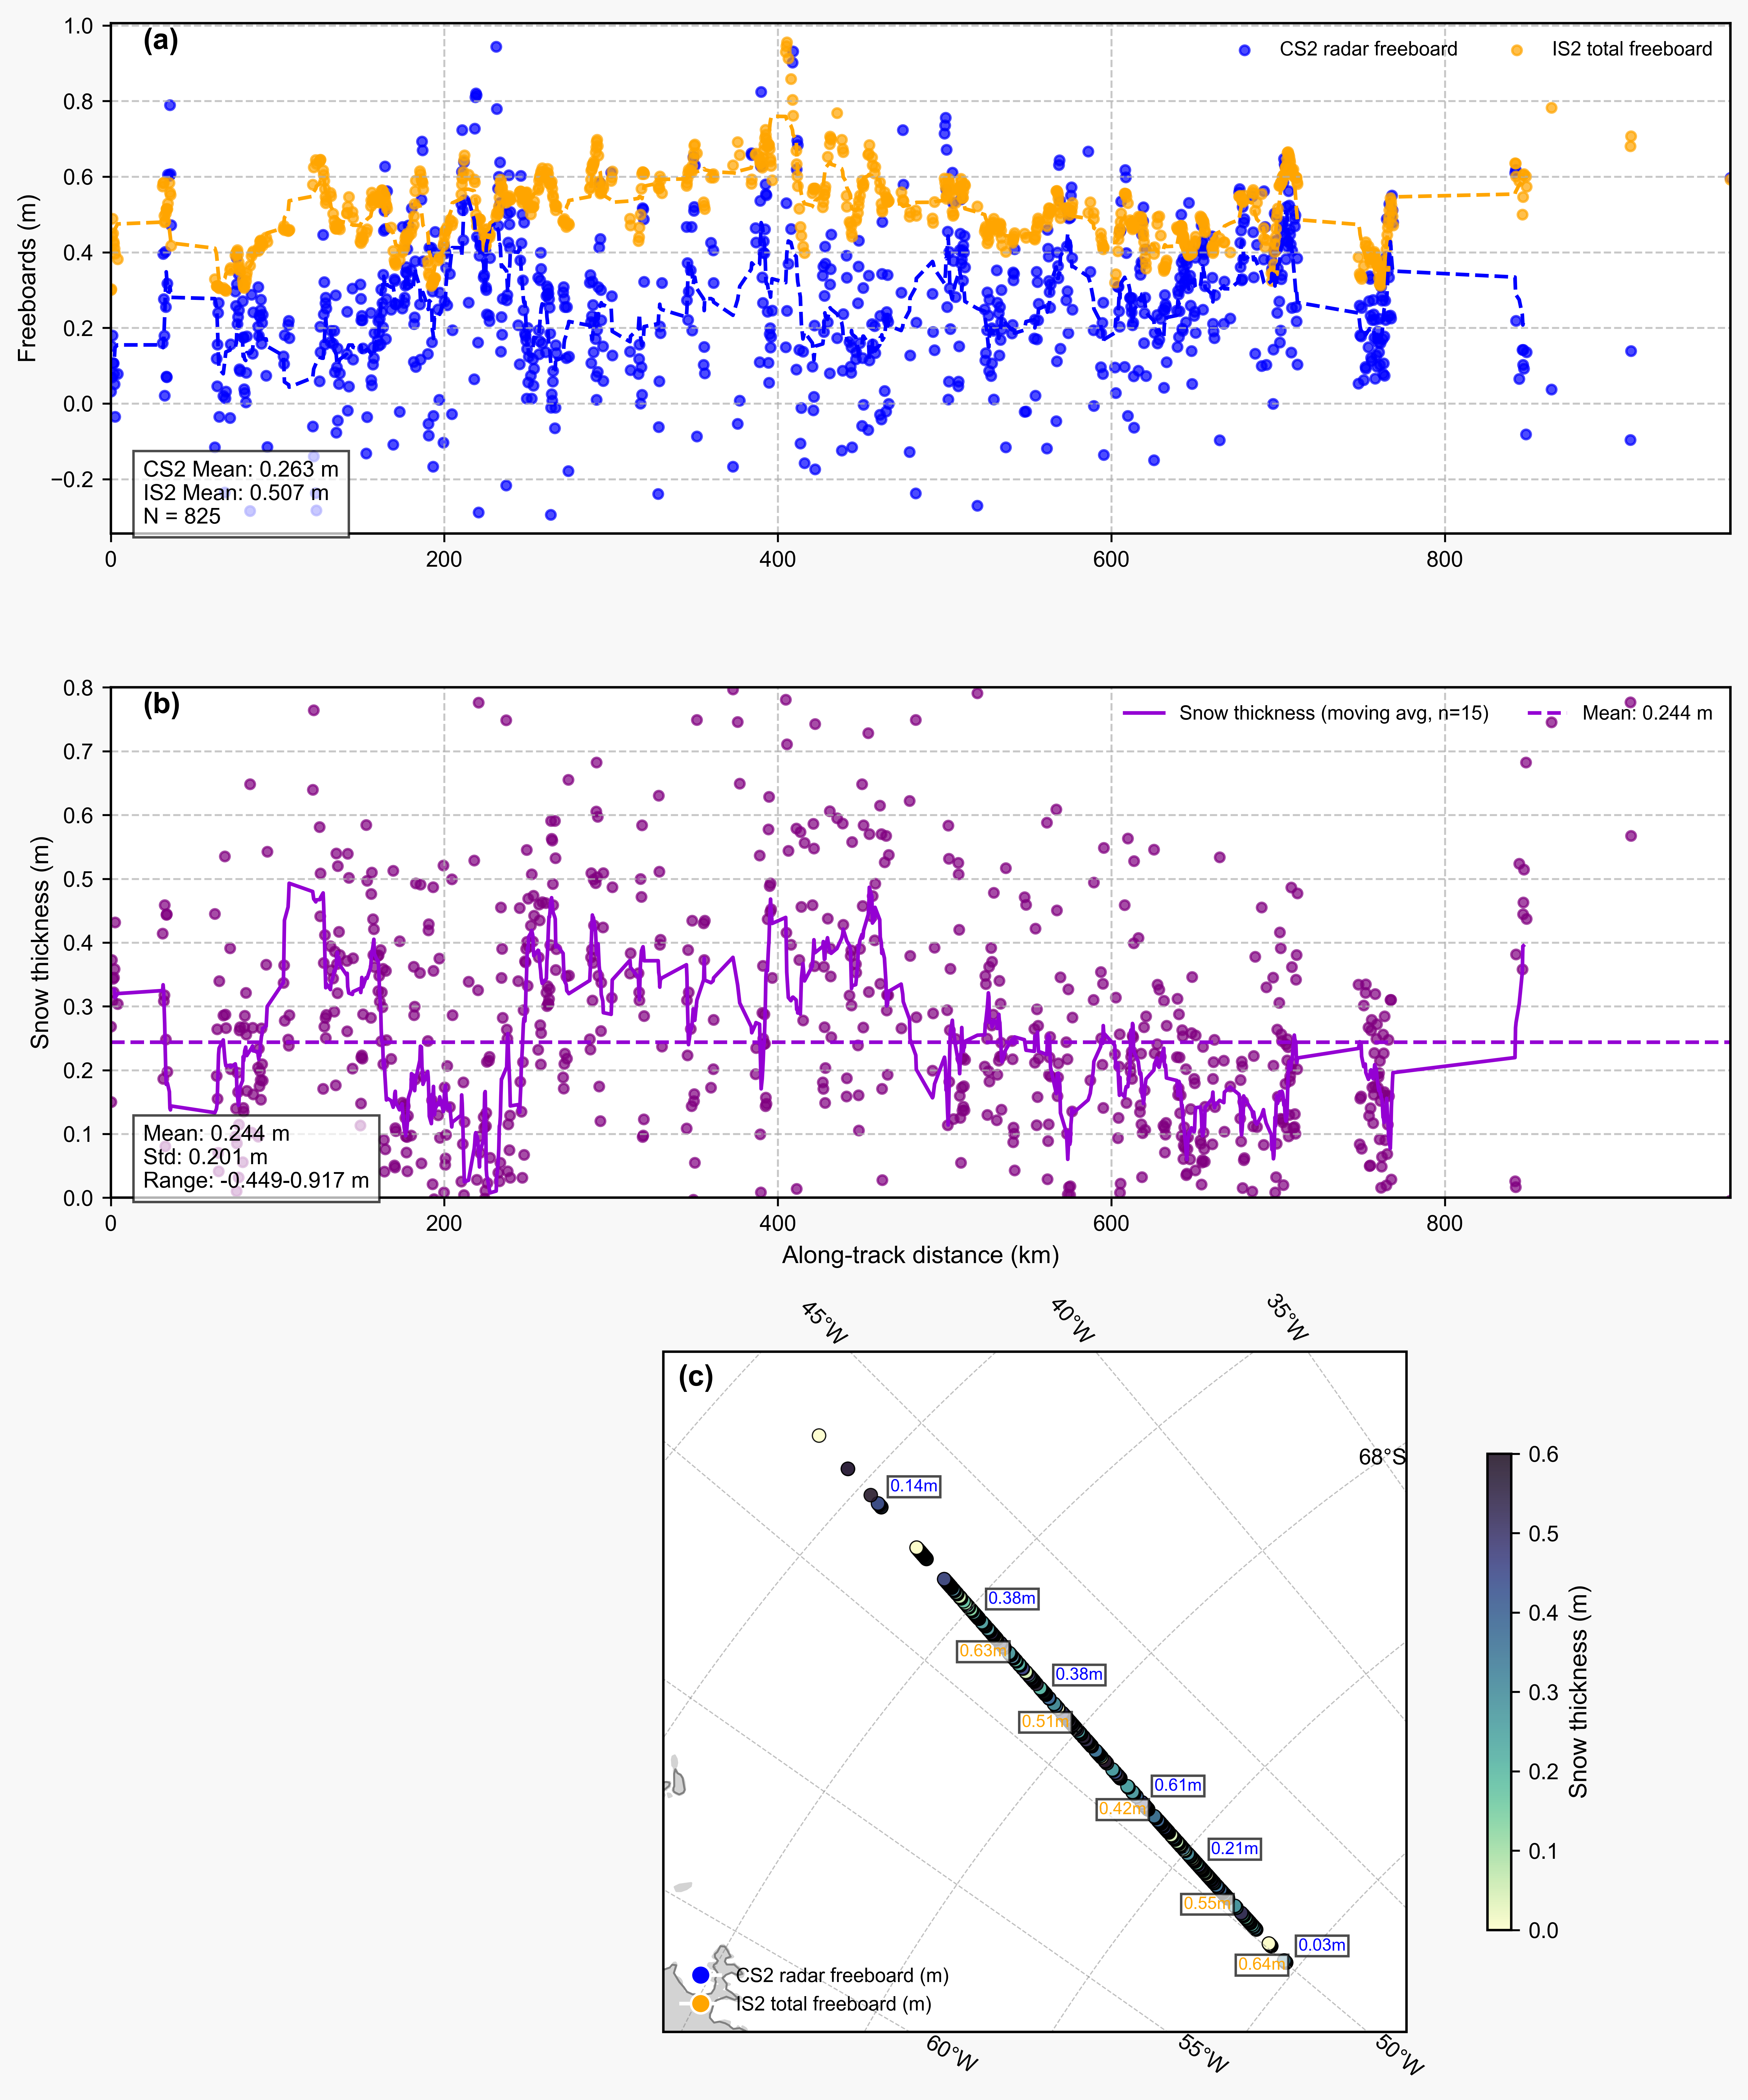

In [34]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import cmocean.cm as cmo
from matplotlib.lines import Line2D

# Remove custom font settings and adjust only necessary parameters
plt.rcParams.update({
    'font.size': 9,
    'axes.linewidth': 1,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 8,
    'figure.dpi': 600
})

# Create figure with increased width to accommodate text boxes
fig = plt.figure(figsize=(10, 12))

# Create GridSpec with 2 rows and 1 column to ensure all subplots have the same width
gs = gridspec.GridSpec(3, 1, height_ratios=[1.5, 1.5, 2])

# Sort data by along-track distance for proper plotting
if 'integrated' in cryo2ice_data and not cryo2ice_data['integrated'].empty:
    # Calculate along-track distance based on latitude
    # Start from the southernmost point (highest absolute latitude value)
    df = cryo2ice_data['integrated'].copy()
    start_idx = df['lat'].abs().idxmax()
    start_lat, start_lon = df.loc[start_idx, 'lat'], df.loc[start_idx, 'lon']
    
    # Calculate distance from start point (in km)
    from geopy.distance import geodesic
    df['along_track'] = df.apply(
        lambda row: geodesic((start_lat, start_lon), (row['lat'], row['lon'])).km,
        axis=1
    )
    
    # Sort by along-track distance
    df = df.sort_values('along_track')
    
    # Create x-axis with along-track distance
    x_dist = df['along_track']
    
    # Create panel (a): Freeboard comparison
    ax1 = plt.subplot(gs[0])
    
    # Plot CS2 radar freeboard
    ax1.scatter(x_dist, df['fb'], s=15, color='blue', alpha=0.7, 
               label='CS2 radar freeboard')
    
    # Plot IS2 total freeboard
    ax1.scatter(x_dist, df['IS2_mean_fb'], s=15, color='orange', alpha=0.7,
               label='IS2 total freeboard')
    
    # Add moving average lines for better visualization
    window_size = min(15, len(df) // 5)  # Adjust window size based on data length
    if window_size > 1:
        df['cs2_ma'] = df['fb'].rolling(window=window_size, center=True).mean()
        df['is2_ma'] = df['IS2_mean_fb'].rolling(window=window_size, center=True).mean()
        ax1.plot(x_dist, df['cs2_ma'], color='blue', linewidth=1.5, linestyle='--')
        ax1.plot(x_dist, df['is2_ma'], color='orange', linewidth=1.5, linestyle='--')
    
    # Set axis labels and limits
    ax1.set_ylabel('Freeboards (m)')
    ax1.set_xlim(x_dist.min(), x_dist.max())
    y_min = min(df['fb'].min(), df['IS2_mean_fb'].min()) - 0.05
    y_max = max(df['fb'].max(), df['IS2_mean_fb'].max()) + 0.05
    ax1.set_ylim(y_min, y_max)
    
    # Add grid and legend
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc='upper right', ncol=2)
    
    # Add panel label
    ax1.text(0.02, 0.95, '(a)', transform=ax1.transAxes, 
            fontsize=12, fontweight='bold')
    
    # Add statistics text
    stats_text = (
        f"CS2 Mean: {df['fb'].mean():.3f} m\n"
        f"IS2 Mean: {df['IS2_mean_fb'].mean():.3f} m\n"
        f"N = {len(df)}"
    )
    ax1.text(0.02, 0.02, stats_text, transform=ax1.transAxes,
            fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    
    # Create panel (b): Snow thickness
    ax2 = plt.subplot(gs[1], sharex=ax1)
    
    # Plot snow thickness (IS2 total freeboard - CS2 radar freeboard)
    ax2.scatter(x_dist, df['snow_thickness'], s=15, color='purple', alpha=0.7)
    
    # Add moving average for snow thickness
    if window_size > 1:
        df['snow_ma'] = df['snow_thickness'].rolling(window=window_size, center=True).mean()
        ax2.plot(x_dist, df['snow_ma'], color='darkviolet', linewidth=1.5,
                label=f'Snow thickness (moving avg, n={window_size})')
    else:
        ax2.plot(x_dist, df['snow_thickness'], color='darkviolet', linewidth=1.5,
                label='Snow thickness')
    
    # Add mean line
    ax2.axhline(df['snow_thickness'].mean(), color='darkviolet', linestyle='--', 
               label=f'Mean: {df["snow_thickness"].mean():.3f} m')
    
    # Set axis labels and limits
    ax2.set_ylabel('Snow thickness (m)')
    ax2.set_xlabel('Along-track distance (km)')
    ax2.set_xlim(x_dist.min(), x_dist.max())
    ax2.set_ylim(0, min(0.8, df['snow_thickness'].max() * 1.2))
    
    # Add grid and legend
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(loc='upper right', ncol=2)
    
    # Add panel label
    ax2.text(0.02, 0.95, '(b)', transform=ax2.transAxes, 
            fontsize=12, fontweight='bold')
    
    # Add statistics
    stats_text = (
        f"Mean: {df['snow_thickness'].mean():.3f} m\n"
        f"Std: {df['snow_thickness'].std():.3f} m\n"
        f"Range: {df['snow_thickness'].min():.3f}-{df['snow_thickness'].max():.3f} m"
    )
    ax2.text(0.02, 0.02, stats_text, transform=ax2.transAxes,
            fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    
    # Create panel (c): Spatial distributions - now with full width
    ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo(central_longitude=0))
    
    # Set extent based on data (with buffer)
    lon_min, lon_max = df['lon'].min() - 1, df['lon'].max() + 1
    lat_min, lat_max = df['lat'].min() - 1, df['lat'].max() + 1
    ax3.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    
    # Add map features
    ax3.coastlines(resolution='50m', color='gray', linewidth=0.8)
    ax3.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    ax3.add_feature(cfeature.LAND, color='lightgray')
    
    # Create colormap for snow thickness
    snow_norm = mcolors.Normalize(vmin=0, vmax=min(0.6, df['snow_thickness'].max()))
    snow_cmap = cmo.deep
    
    # Create scatter plot colored by snow thickness
    sc = ax3.scatter(df['lon'], df['lat'], c=df['snow_thickness'], 
                   transform=ccrs.PlateCarree(), 
                   cmap=snow_cmap, norm=snow_norm, 
                   s=30, alpha=0.9, edgecolor='k', linewidth=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax3, shrink=0.7, pad=0.05)
    cbar.set_label('Snow thickness (m)')
    
    # Add CS2 and IS2 freeboard as text labels at specific points
    # Choose a subset of points for clarity
    step = max(1, len(df) // 10)
    for i in range(0, len(df), step):
        # Add label for specific points
        if i % (step*2) == 0:  # Add labels for every other point to avoid clutter
            ax3.annotate(f"{df['fb'].iloc[i]:.2f}m", 
                        xy=(df['lon'].iloc[i], df['lat'].iloc[i]), 
                        xytext=(5, 5), textcoords='offset points',
                        transform=ccrs.PlateCarree(),
                        fontsize=7, color='blue', 
                        bbox=dict(facecolor='white', alpha=0.7, pad=1))
        else:
            ax3.annotate(f"{df['IS2_mean_fb'].iloc[i]:.2f}m", 
                        xy=(df['lon'].iloc[i], df['lat'].iloc[i]), 
                        xytext=(5, -30), textcoords='offset points',
                        transform=ccrs.PlateCarree(),
                        fontsize=7, color='orange', 
                        bbox=dict(facecolor='white', alpha=0.7, pad=1))
    
    # Add panel label
    ax3.text(0.02, 0.95, '(c)', transform=ax3.transAxes, 
            fontsize=12, fontweight='bold')
    
    # Add legend for CS2 and IS2 text labels
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
              markersize=8, label='CS2 radar freeboard (m)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', 
              markersize=8, label='IS2 total freeboard (m)')
    ]
    ax3.legend(handles=legend_elements, loc='lower left', 
              bbox_to_anchor=(0, 0), framealpha=0.9)
    
    # Adjust layout with proper spacing
    plt.subplots_adjust(hspace=0.3)
    
    # Save figure in high resolution
    output_dir = os.path.join(base_dir, "output", "cryo2ice_along_track")
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, "cryo2ice_along_track_analysis.png"), 
              dpi=600, bbox_inches='tight')
    
    # Display the figure
    plt.tight_layout()
    plt.show()
    
else:
    print("No integrated CRYO2ICE data available for plotting")

## Step 7: Uncertainty Analysis

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde, pearsonr
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
import os

print("===== CRYO2ICE Snow Thickness Uncertainty Analysis =====")

# Create output directory for uncertainty analysis
uncertainty_dir = os.path.join(base_dir, "output", "uncertainty_analysis")
os.makedirs(uncertainty_dir, exist_ok=True)

# Check if we have valid data to work with
if 'integrated' in cryo2ice_data and not cryo2ice_data['integrated'].empty:
    df = cryo2ice_data['integrated'].copy()
    print(f"Analyzing uncertainty for {len(df)} collocated CRYO2ICE points")
    
    # ====================================================================
    # 1. Component-wise Uncertainty Analysis
    # ====================================================================
    
    # 1.1 Freeboard Measurement Uncertainties
    # ---------------------------------------
    # CS2 radar freeboard uncertainty - from literature with different components
    cs2_range_precision = 0.10  # meters, range measurement precision
    cs2_ssh_uncertainty = 0.05  # meters, sea surface height uncertainty
    cs2_fb_uncertainty = np.sqrt(cs2_range_precision**2 + cs2_ssh_uncertainty**2)
    
    # IS2 total freeboard uncertainty - from beam_fb_unc when available
    if 'IS2_fb_unc' in df.columns and not df['IS2_fb_unc'].isna().all():
        is2_fb_uncertainty = df['IS2_fb_unc'].mean()
    else:
        # From Kwok et al. (2019) - more conservative estimate
        is2_fb_uncertainty = 0.05  # meters
    
    # 1.2 Spatial Collocation Uncertainty
    # -----------------------------------
    # Estimate uncertainty based on spatial heterogeneity of sea ice
    # Literature suggests ~0.02m per km of separation as reasonable estimate
    mean_separation = df['IS2_dist_avg'].mean() / 1000  # Convert to km
    spatial_uncertainty = mean_separation * 0.02  # meters per km
    
    # 1.3 Temporal Uncertainty
    # -----------------------
    # Estimate uncertainty due to time lag between measurements
    # Accounts for potential changes in snow conditions between acquisitions
    time_lag_hours = abs(df['time_delta_hours'].mean() if 'time_delta_hours' in df else 3.0)
    temporal_uncertainty = time_lag_hours * 0.01  # 1cm per hour based on literature
    
    # 1.4 Processing Algorithm Uncertainties
    # -------------------------------------
    # Uncertainty from processing choices (search radius, filtering, etc.)
    processing_uncertainty = 0.02  # meters, conservative estimate
    
    # 1.5 Physical Assumptions Uncertainties
    # ------------------------------------
    # Radar penetration uncertainty - key source of uncertainty in snow thickness
    # CryoSat-2 radar signal penetration is affected by snow properties
    penetration_uncertainty = 0.04  # meters, from Nandan et al. (2020)
    
    # ====================================================================
    # 2. Combined Uncertainty Calculation (Gaussian error propagation)
    # ====================================================================
    
    # 2.1 Calculate total systematic uncertainty (root sum of squares)
    total_systematic_uncertainty = np.sqrt(
        cs2_fb_uncertainty**2 + 
        is2_fb_uncertainty**2 + 
        penetration_uncertainty**2 +
        processing_uncertainty**2
    )
    
    # 2.2 Calculate total random uncertainty (includes spatial and temporal components)
    total_random_uncertainty = np.sqrt(
        spatial_uncertainty**2 + 
        temporal_uncertainty**2
    )
    
    # 2.3 Combine for total uncertainty
    total_uncertainty = np.sqrt(total_systematic_uncertainty**2 + total_random_uncertainty**2)
    
    # 2.4 Calculate point-by-point uncertainty for each snow thickness estimate
    # Use distance and measurement-specific components
    df['point_spatial_uncertainty'] = df['IS2_dist_avg'] / 1000 * 0.02  # Specific to each point
    
    df['point_uncertainty'] = np.sqrt(
        cs2_fb_uncertainty**2 + 
        is2_fb_uncertainty**2 + 
        df['point_spatial_uncertainty']**2 +
        penetration_uncertainty**2 + 
        temporal_uncertainty**2 +
        processing_uncertainty**2
    )
    
    # Calculate relative uncertainty (as percentage of snow thickness)
    df['relative_uncertainty'] = (df['point_uncertainty'] / df['snow_thickness']) * 100
    df['relative_uncertainty'] = df['relative_uncertainty'].replace([np.inf, -np.inf], np.nan)
    
    # ====================================================================
    # 3. Uncertainty Breakdown and Summary
    # ====================================================================
    
    print("\n=== Component-wise Uncertainty Breakdown ===")
    print(f"CS2 freeboard uncertainty: {cs2_fb_uncertainty:.4f} m")
    print(f"IS2 freeboard uncertainty: {is2_fb_uncertainty:.4f} m")
    print(f"Spatial collocation uncertainty: {spatial_uncertainty:.4f} m (based on {mean_separation:.2f} km separation)")
    print(f"Temporal uncertainty (time lag: {time_lag_hours:.2f} hrs): {temporal_uncertainty:.4f} m")
    print(f"Processing algorithm uncertainty: {processing_uncertainty:.4f} m")
    print(f"Radar penetration uncertainty: {penetration_uncertainty:.4f} m")
    print(f"Total systematic uncertainty: {total_systematic_uncertainty:.4f} m")
    print(f"Total random uncertainty: {total_random_uncertainty:.4f} m")
    print(f"Total combined uncertainty: {total_uncertainty:.4f} m")
    
    # Snow thickness statistics
    mean_thickness = df['snow_thickness'].mean()
    median_thickness = df['snow_thickness'].median()
    std_thickness = df['snow_thickness'].std()
    
    print("\n=== Snow Thickness Statistics with Uncertainty ===")
    print(f"Mean snow thickness: {mean_thickness:.4f} ± {total_uncertainty:.4f} m")
    print(f"Median snow thickness: {median_thickness:.4f} ± {total_uncertainty:.4f} m")
    print(f"Snow thickness standard deviation: {std_thickness:.4f} m")
    print(f"Mean point-wise uncertainty: {df['point_uncertainty'].mean():.4f} m")
    print(f"Mean relative uncertainty: {df['relative_uncertainty'].mean():.1f}%")
    
    # ====================================================================
    # 4. Uncertainty Visualization
    # ====================================================================
    
    # Create a figure with multiple panels for uncertainty analysis
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
    
    # Panel 1: Snow Thickness with Uncertainty Bands
    ax1 = plt.subplot(gs[0, 0])
    
    # Calculate or use along-track distance
    if 'along_track' not in df:
        # Sort by latitude for a simple proxy of along-track distance
        df = df.sort_values('lat')
        df['along_track'] = np.arange(len(df))
    
    # Sort by along-track distance
    df = df.sort_values('along_track')
    x_dist = df['along_track']
    
    # Plot snow thickness with uncertainty bands
    ax1.plot(x_dist, df['snow_thickness'], '-o', color='darkviolet', markersize=4, alpha=0.7)
    ax1.fill_between(x_dist, 
                   df['snow_thickness'] - df['point_uncertainty'], 
                   df['snow_thickness'] + df['point_uncertainty'], 
                   color='purple', alpha=0.2, label=f'Point-wise uncertainty')
    
    # Add mean line with total uncertainty
    ax1.axhline(mean_thickness, color='red', linestyle='-', linewidth=1.5, 
               label=f'Mean: {mean_thickness:.3f} m')
    ax1.axhline(mean_thickness + total_uncertainty, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax1.axhline(mean_thickness - total_uncertainty, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax1.fill_between([x_dist.min(), x_dist.max()], 
                   mean_thickness - total_uncertainty,
                   mean_thickness + total_uncertainty,
                   color='red', alpha=0.1, label=f'Total uncertainty: ±{total_uncertainty:.3f} m')
    
    # Customize the plot
    ax1.set_xlabel('Along-track distance (km)')
    ax1.set_ylabel('Snow thickness (m)')
    ax1.set_title('Snow Thickness with Uncertainty', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best', framealpha=0.7)
    
    # Panel 2: Histogram of point-wise uncertainty
    ax2 = plt.subplot(gs[0, 1])
    
    # Create histogram of point uncertainties
    sns.histplot(df['point_uncertainty'], bins=20, kde=True, ax=ax2, color='darkblue')
    ax2.axvline(df['point_uncertainty'].mean(), color='red', linestyle='-', linewidth=1.5, 
               label=f'Mean: {df["point_uncertainty"].mean():.3f} m')
    ax2.axvline(total_uncertainty, color='green', linestyle='--', linewidth=1.5, 
               label=f'Total: {total_uncertainty:.3f} m')
    
    # Customize the plot
    ax2.set_xlabel('Uncertainty (m)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Point-wise Uncertainty', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best', framealpha=0.7)
    
    # Panel 3: Uncertainty components breakdown
    ax3 = plt.subplot(gs[1, 0])
    
    # Create bar chart of uncertainty components
    components = ['CS2 freeboard', 'IS2 freeboard', 'Spatial', 'Temporal', 
                  'Processing', 'Penetration']
    values = [cs2_fb_uncertainty, is2_fb_uncertainty, spatial_uncertainty, 
             temporal_uncertainty, processing_uncertainty, penetration_uncertainty]
    
    # Calculate percentage contribution to variance
    total_var = sum([v**2 for v in values])
    percentages = [100 * (v**2) / total_var for v in values]
    
    # Create horizontal bar chart with color gradient
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(components)))
    bars = ax3.barh(components, percentages, color=colors)
    
    # Add percentage labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax3.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f"{percentages[i]:.1f}%", ha='left', va='center')
    
    # Customize the plot
    ax3.set_xlabel('Contribution to total variance (%)')
    ax3.set_title('Uncertainty Component Breakdown', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    ax3.set_xlim(0, max(percentages) * 1.2)
    
    # Panel 4: Scatter plot of snow thickness vs uncertainty
    ax4 = plt.subplot(gs[1, 1])
    
    # Create scatter plot
    scatter = ax4.scatter(df['snow_thickness'], df['point_uncertainty'], 
                        c=df['IS2_dist_avg']/1000, cmap='viridis', 
                        alpha=0.7, s=30, edgecolor='k', linewidth=0.5)
    
    # Add regression line
    m, b = np.polyfit(df['snow_thickness'], df['point_uncertainty'], 1)
    x_range = np.linspace(df['snow_thickness'].min(), df['snow_thickness'].max(), 100)
    ax4.plot(x_range, m * x_range + b, 'r--', 
            label=f'Slope: {m:.3f}, Intercept: {b:.3f}')
    
    # Calculate correlation
    correlation, p_value = pearsonr(df['snow_thickness'], df['point_uncertainty'])
    
    # Add colorbar for distance
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Avg. distance to IS2 points (km)')
    
    # Customize the plot
    ax4.set_xlabel('Snow thickness (m)')
    ax4.set_ylabel('Uncertainty (m)')
    ax4.set_title(f'Uncertainty vs Snow Thickness (r={correlation:.3f}, p={p_value:.3f})', 
                 fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.legend(loc='best', framealpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(uncertainty_dir, "snow_thickness_uncertainty_analysis.png"), 
              dpi=600, bbox_inches='tight')
    plt.close()
    
    # ====================================================================
    # 5. Advanced Statistical Analysis
    # ====================================================================
    
    print("\n=== Advanced Statistical Analysis ===")
    
    # Calculate 95% confidence interval for mean snow thickness
    n = len(df)
    from scipy import stats
    ci_95 = stats.t.ppf(0.975, n-1) * std_thickness / np.sqrt(n)
    print(f"95% confidence interval for mean: {mean_thickness:.4f} ± {ci_95:.4f} m")
    
    # Create spatial analysis figure
    plt.figure(figsize=(10, 8))
    
    # Set up Antarctic polar stereographic projection
    projection = ccrs.SouthPolarStereo(central_longitude=0.0)
    ax = plt.axes(projection=projection)
    
    # Set extent based on data with buffer
    buffer = 0.5
    min_lon, max_lon = df['lon'].min() - buffer, df['lon'].max() + buffer
    min_lat, max_lat = df['lat'].min() - buffer, df['lat'].max() + buffer
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.coastlines(resolution='50m', color='gray', linewidth=0.8)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    ax.add_feature(cfeature.LAND, color='lightgray')
    
    # Plot uncertainty as color, snow thickness as marker size
    sc = ax.scatter(df['lon'], df['lat'], 
                  c=df['point_uncertainty'], s=df['snow_thickness']*200,  # Adjusted scale
                  transform=ccrs.PlateCarree(), cmap='viridis',
                  alpha=0.7, edgecolor='k', linewidth=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(sc, shrink=0.7, pad=0.05)
    cbar.set_label('Uncertainty (m)')
    
    # Add legend for marker sizes
    legend_elements = []
    # Create size legend with relevant snow thickness values
    snow_range = np.linspace(df['snow_thickness'].min(), df['snow_thickness'].max(), 4)
    for val in snow_range:
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                 markersize=np.sqrt(val*200/np.pi), label=f'{val:.2f} m')
        )
    
    ax.legend(handles=legend_elements, loc='lower left', title='Snow Thickness', framealpha=0.7)
    
    # Add title
    plt.title('Spatial Distribution of Snow Thickness and Uncertainty', fontweight='bold')
    
    # Save spatial uncertainty figure
    plt.savefig(os.path.join(uncertainty_dir, "snow_thickness_spatial_uncertainty.png"), 
              dpi=600, bbox_inches='tight')
    plt.close()
    
    # ====================================================================
    # 6. Monte Carlo Uncertainty Propagation
    # ====================================================================
    
    print("\n=== Monte Carlo Uncertainty Propagation ===")
    
    # Set number of Monte Carlo iterations
    n_iterations = 10000
    
    # Initialize array to store Monte Carlo results
    mc_results = np.zeros((len(df), n_iterations))
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Perform Monte Carlo simulation with appropriate error correlations
    for i in range(n_iterations):
        # Generate correlated random errors for systematic uncertainties
        # These are consistent across all points for each iteration
        cs2_sys_error = np.random.normal(0, cs2_fb_uncertainty)
        is2_sys_error = np.random.normal(0, is2_fb_uncertainty)
        penetration_error = np.random.normal(0, penetration_uncertainty)
        processing_error = np.random.normal(0, processing_uncertainty)
        
        # Common systematic error component
        systematic_error = cs2_sys_error + is2_sys_error + penetration_error + processing_error
        
        # Generate point-specific random errors
        # These vary between points but are spatially correlated
        point_spatial_errors = np.random.normal(0, df['point_spatial_uncertainty'])
        temporal_errors = np.random.normal(0, temporal_uncertainty, len(df))
        
        # Total error for this iteration
        total_errors = systematic_error + point_spatial_errors + temporal_errors
        
        # Calculate snow thickness with added errors
        mc_results[:, i] = df['snow_thickness'] + total_errors
    
    # Ensure physically meaningful results (no negative snow)
    mc_results = np.maximum(mc_results, 0)
    
    # Calculate statistics from Monte Carlo results
    mc_means = np.mean(mc_results, axis=1)
    mc_std = np.std(mc_results, axis=1)
    mc_lower = np.percentile(mc_results, 2.5, axis=1)  # 2.5th percentile
    mc_upper = np.percentile(mc_results, 97.5, axis=1)  # 97.5th percentile
    
    # Store results in dataframe
    df['mc_mean'] = mc_means
    df['mc_std'] = mc_std
    df['mc_lower_95'] = mc_lower
    df['mc_upper_95'] = mc_upper
    
    # Calculate overall statistics from Monte Carlo simulation
    all_mc = mc_results.flatten()
    
    # Print Monte Carlo statistics
    print(f"Monte Carlo mean snow thickness: {np.mean(all_mc):.4f} m")
    print(f"Monte Carlo std dev: {np.std(all_mc):.4f} m")
    print(f"Monte Carlo 95% CI: [{np.percentile(all_mc, 2.5):.4f}, {np.percentile(all_mc, 97.5):.4f}] m")
    
    # Create Monte Carlo distribution figure
    plt.figure(figsize=(10, 6))
    
    # Create histogram of Monte Carlo results
    sns.histplot(all_mc, bins=50, kde=True, color='slateblue')
    
    # Add vertical lines for statistics
    plt.axvline(np.mean(all_mc), color='red', linestyle='-', linewidth=2, 
               label=f'Mean: {np.mean(all_mc):.4f} m')
    plt.axvline(np.percentile(all_mc, 2.5), color='orange', linestyle='--', linewidth=1.5, 
               label=f'2.5%: {np.percentile(all_mc, 2.5):.4f} m')
    plt.axvline(np.percentile(all_mc, 97.5), color='orange', linestyle='--', linewidth=1.5, 
               label=f'97.5%: {np.percentile(all_mc, 97.5):.4f} m')
    
    # Customize the plot
    plt.xlabel('Snow Thickness (m)')
    plt.ylabel('Frequency')
    plt.title('Monte Carlo Simulation of Snow Thickness Distribution', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', framealpha=0.7)
    
    # Save Monte Carlo figure
    plt.savefig(os.path.join(uncertainty_dir, "snow_thickness_monte_carlo.png"), 
              dpi=600, bbox_inches='tight')
    plt.close()
    
    # Save dataframe with uncertainty analysis
    df.to_csv(os.path.join(uncertainty_dir, "snow_thickness_with_uncertainty.csv"), index=False)
    
    print(f"\nUncertainty analysis complete. Results saved to: {uncertainty_dir}")
    
else:
    print("No valid CRYO2ICE data available for uncertainty analysis")

===== CRYO2ICE Snow Thickness Uncertainty Analysis =====
Analyzing uncertainty for 825 collocated CRYO2ICE points

=== Component-wise Uncertainty Breakdown ===
CS2 freeboard uncertainty: 0.1118 m
IS2 freeboard uncertainty: 0.0500 m
Spatial collocation uncertainty: 0.0392 m (based on 1.96 km separation)
Temporal uncertainty (time lag: 3.00 hrs): 0.0300 m
Processing algorithm uncertainty: 0.0200 m
Radar penetration uncertainty: 0.0400 m
Total systematic uncertainty: 0.1304 m
Total random uncertainty: 0.0494 m
Total combined uncertainty: 0.1394 m

=== Snow Thickness Statistics with Uncertainty ===
Mean snow thickness: 0.2439 ± 0.1394 m
Median snow thickness: 0.2263 ± 0.1394 m
Snow thickness standard deviation: 0.2014 m
Mean point-wise uncertainty: 0.1395 m
Mean relative uncertainty: 40.1%

=== Advanced Statistical Analysis ===
95% confidence interval for mean: 0.2439 ± 0.0138 m

=== Monte Carlo Uncertainty Propagation ===
Monte Carlo mean snow thickness: 0.2643 m
Monte Carlo std dev: 0.21